<a href="https://colab.research.google.com/github/IvanovAdrew/python-for-big-data-and-data-science/blob/main/GUNPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Важлива термінологія щодо глобальних мереж

### Кроки навчання GAN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.datasets import fashion_mnist as mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings , os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.6 MB/s eta 0:00:00


In [ ]:
import umap
import umap.plot

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# input image dimension
img_shape = (img_rows, img_cols, channels)

# size of noise vector to be used as generator input
z_dim = 100

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()

    # Genearator -> Discriminator
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# Creating and Compiling discriminator Models
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# Preserve the parameters of the discriminator while training the generator
discriminator.trainable = False

In [ ]:
# Create a generator model
generator = build_generator(z_dim)

# Create and compile a GAN model with frozen discriminators to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # [0, 255] scales black and white pixel values between [-1, 1]
    X_train = x_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Real Image Label: All 1
    real = np.ones((batch_size, 1))

    # Fake Image Labels: All 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Discriminant training
        # -------------------------

        # Get random batches from real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Create fake image batches
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Training
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Training generator
        # ---------------------

        # Create fake image batches
        z = np.random.normal(0, 1, (batch_size, 100))

        if iteration == 0:
            print("\nRandom noise input image")
            sample_images(x_train[idx],y_train[idx],generator)

        g_loss = gan.train_on_batch(z, real)

        if iteration < 200 and (iteration + 1) % 20 == 0:
            # Save loss and accuracy to plot graphs after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Generated image sample output
            sample_images(x_train[idx],y_train[idx],generator)

        elif (iteration + 1) % sample_interval == 0:
            # Save loss and accuracy to plot graphs after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Generated image sample output
            sample_images(x_train[idx],y_train[idx],generator)

In [ ]:
image_grid_rows=4
image_grid_columns=4

def plot_dim_reduction(imgs, gen_imgs, img_labels):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    markers=['o','v','^','<','>','8','s','P','*','X','+','*']
    plt.figure(figsize=(9,9))
    reshape_real_imgs = imgs.reshape(imgs.shape[0], -1)
    reshape_gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], -1)*255
    concat_imgs = np.concatenate([reshape_real_imgs,reshape_gen_imgs])
    fake_label = np.empty((image_grid_rows * image_grid_columns))
    fake_label[:] = 11
    concat_label = np.concatenate([img_labels,fake_label])
    mapper = umap.UMAP().fit_transform(concat_imgs)
    for i,marker in enumerate(markers):
        mask = concat_label == i
        if i == 11:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=100, alpha=1,marker=marker, c ='yellow')
        else:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=10, alpha=1,marker=marker)
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)
    plt.title("Plotting real and generated images after dimension reduction",fontsize = 15)

In [ ]:
def plot_dist(gen_imgs):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    sns.distplot(gen_imgs,color='purple',kde=True)
    plt.title("Generated Images Distribution",fontsize = 20)
    plt.show()

In [ ]:
def sample_images(imgs, img_labels, generator):
    # random noise sampling
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate Image from Random Noise
    gen_imgs = generator.predict(z)

    # Scale image pixel values between [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    plot_dim_reduction(imgs, gen_imgs, img_labels)
    plot_dist(gen_imgs)

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(11, 11),
                            sharey=True,
                            sharex=True)

    cnt = 0
    #plt.figure(figsize=(9,9))
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Greys_r')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [ ]:
# Setting Hyperparameter
iterations = 10000
batch_size = 128
sample_interval = 400

### Навчання

4/4 [==============================] - 0s 3ms/step

Random noise input image
1/1 [==============================] - 0s 17ms/step


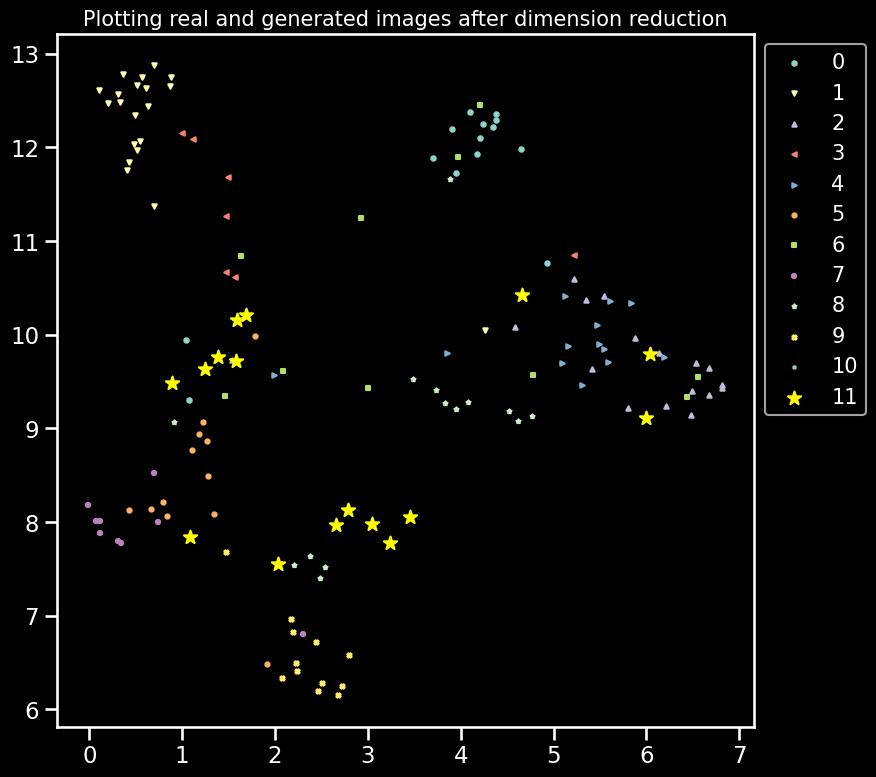

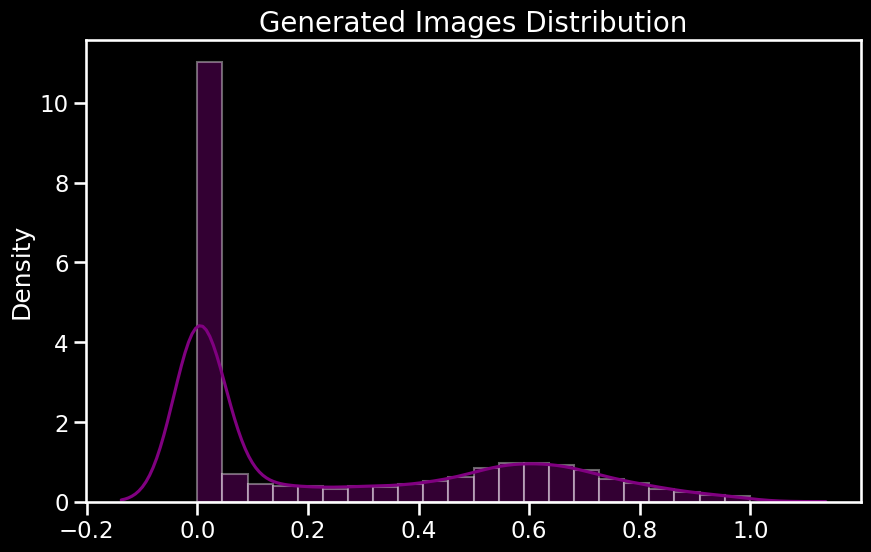

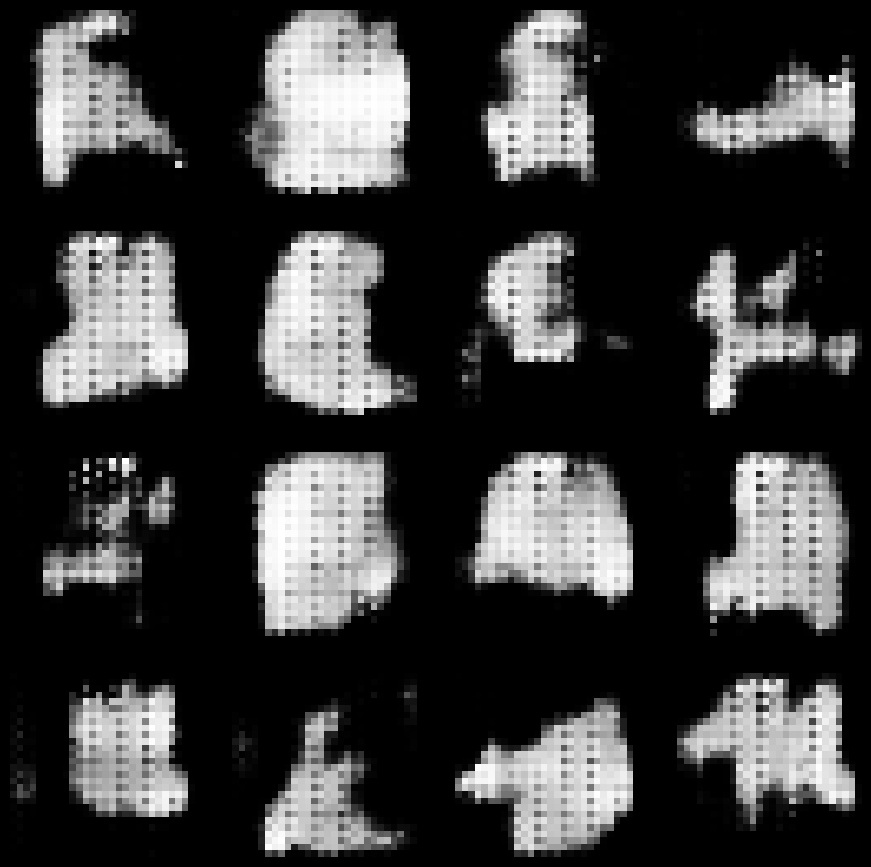

4/4 [==============================] - 0s 3ms/step
20 [D loss: 0.567021, accuracy: 71.48%] [G loss: 1.448381]
1/1 [==============================] - 0s 17ms/step


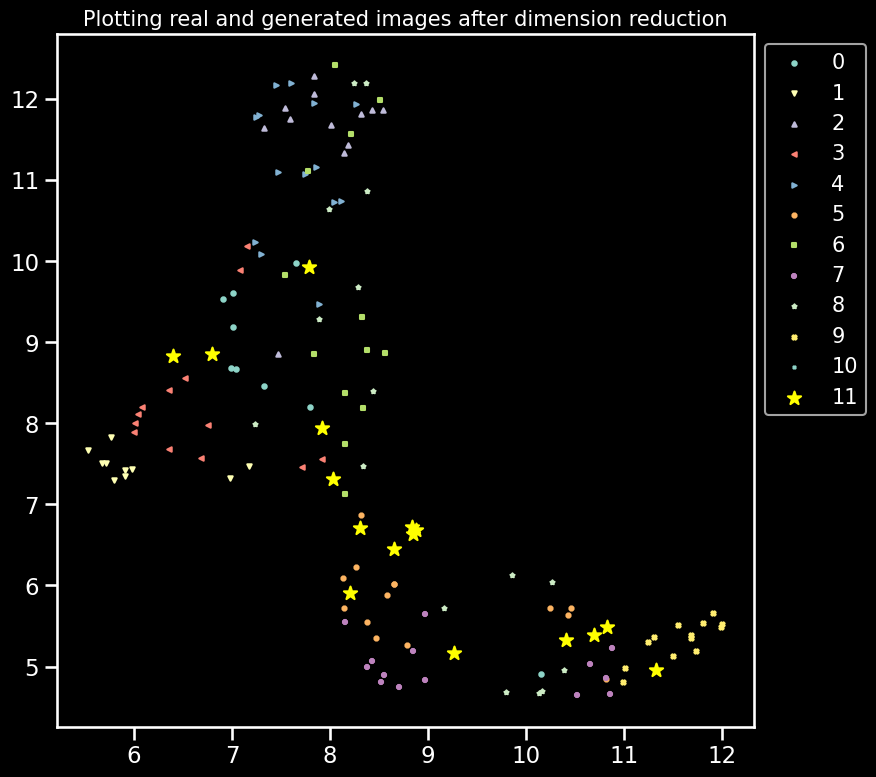

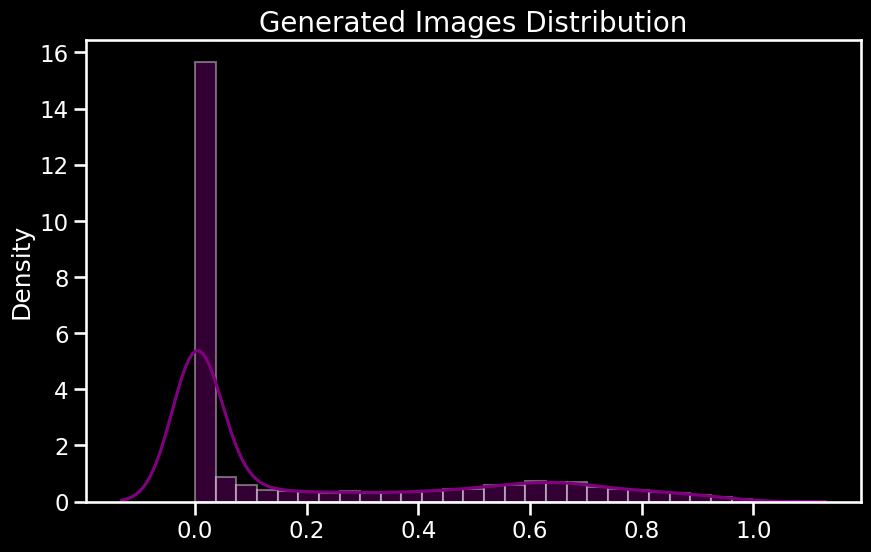

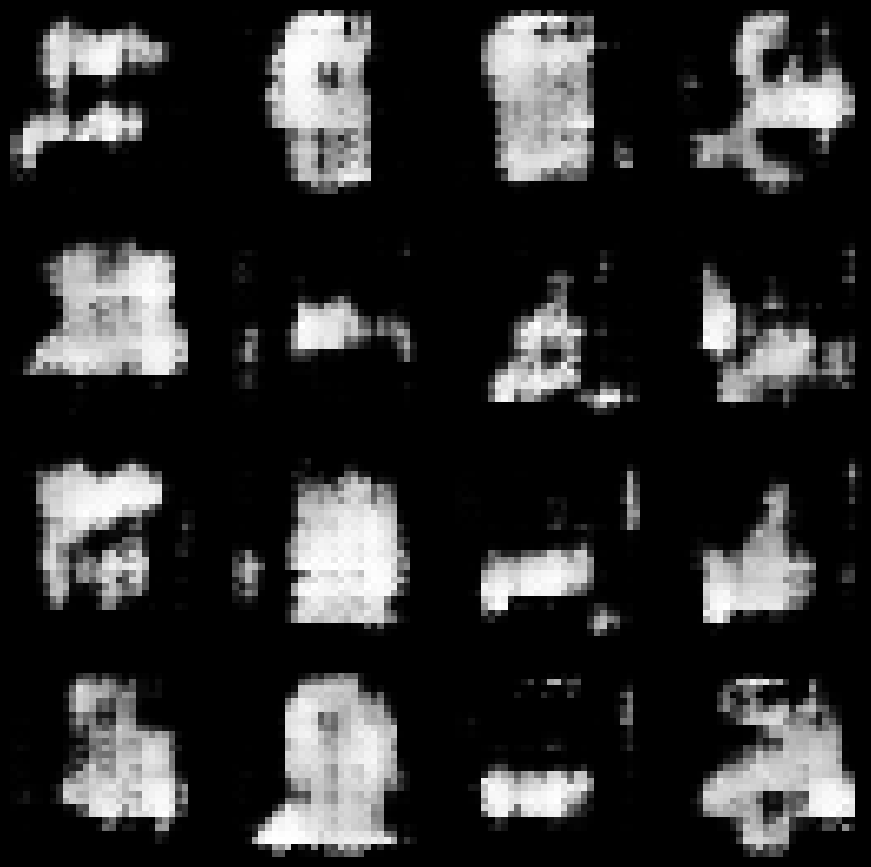

4/4 [==============================] - 0s 3ms/step
40 [D loss: 0.184204, accuracy: 92.97%] [G loss: 2.180628]
1/1 [==============================] - 0s 16ms/step


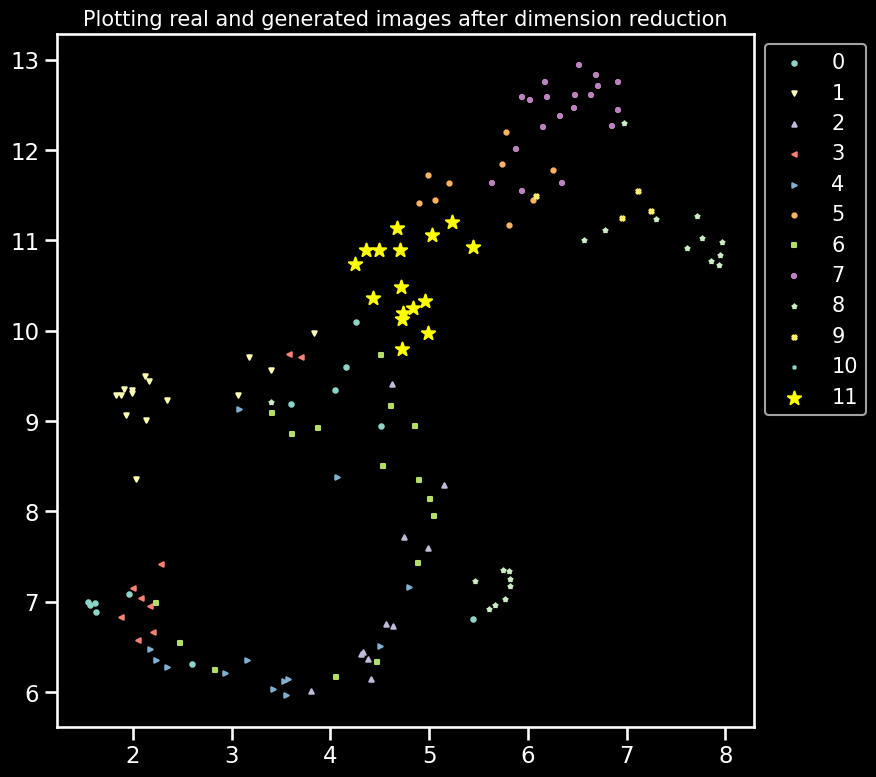

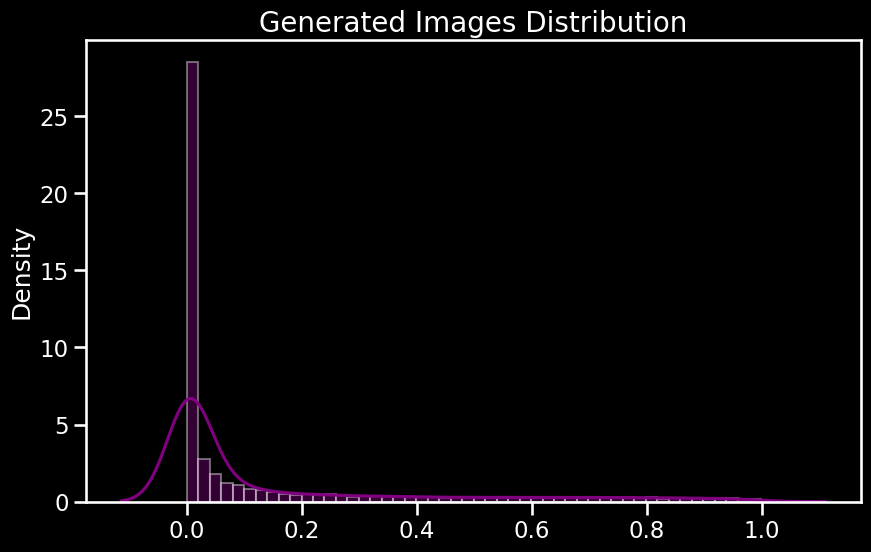

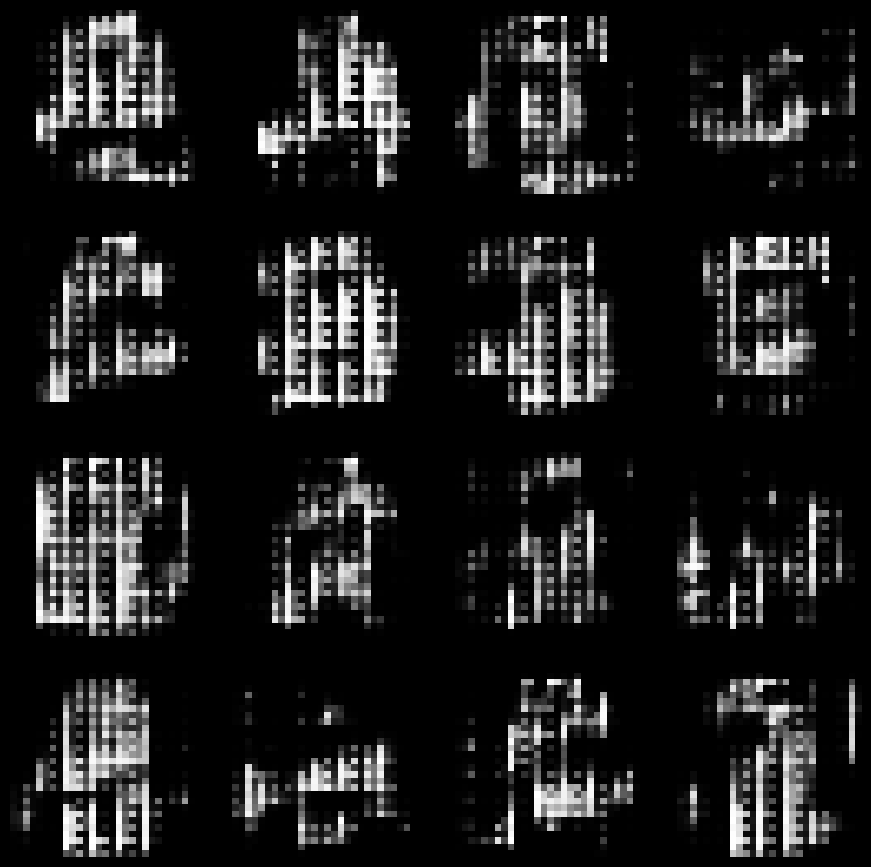

4/4 [==============================] - 0s 3ms/step
60 [D loss: 0.391825, accuracy: 83.59%] [G loss: 1.855356]
1/1 [==============================] - 0s 16ms/step


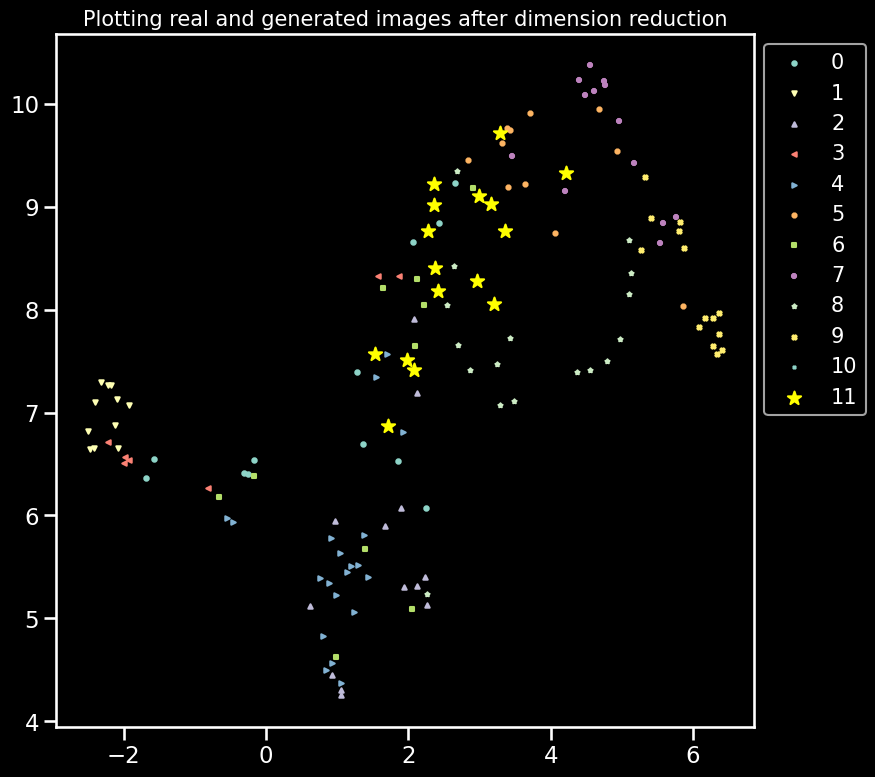

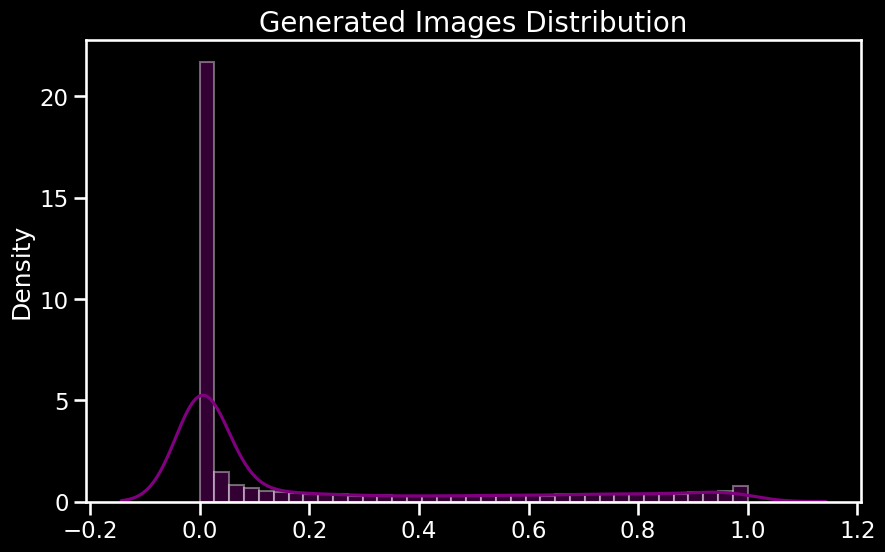

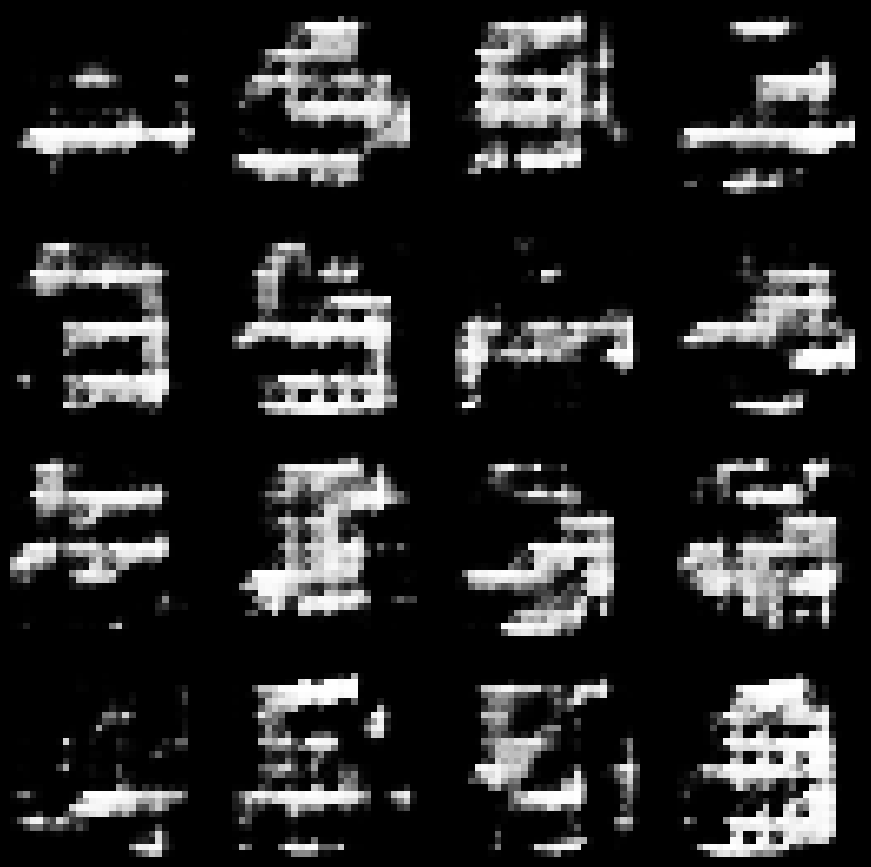

4/4 [==============================] - 0s 3ms/step
80 [D loss: 0.340480, accuracy: 85.55%] [G loss: 2.092744]
1/1 [==============================] - 0s 17ms/step


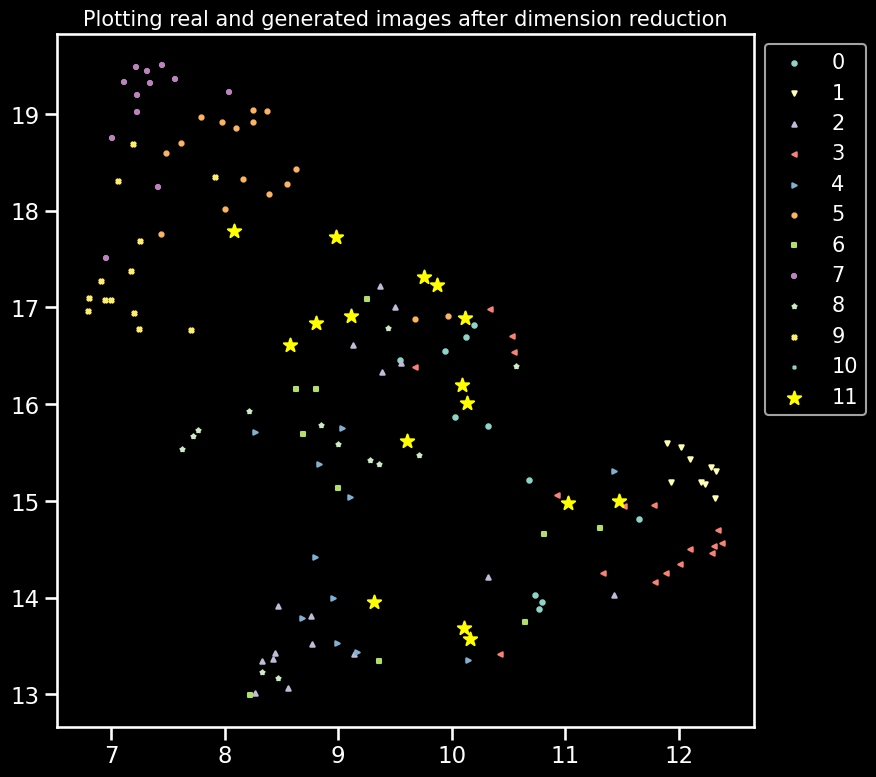

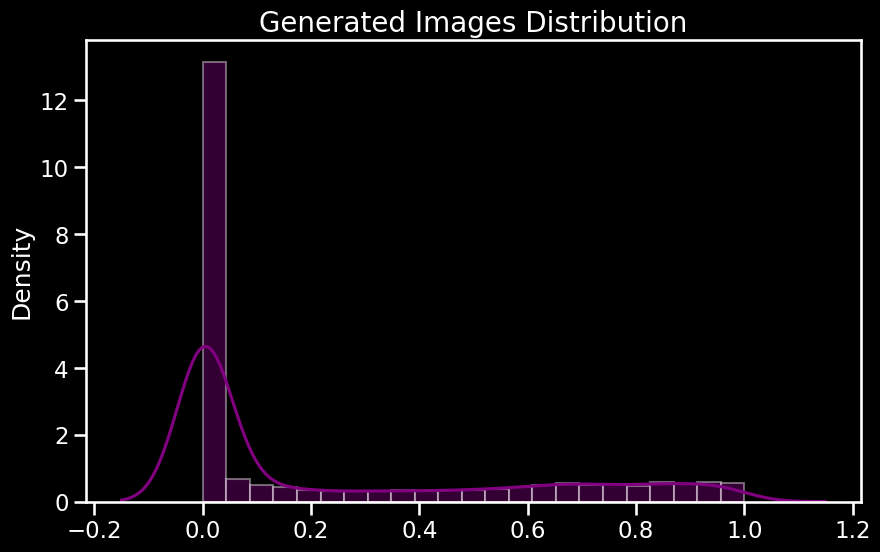

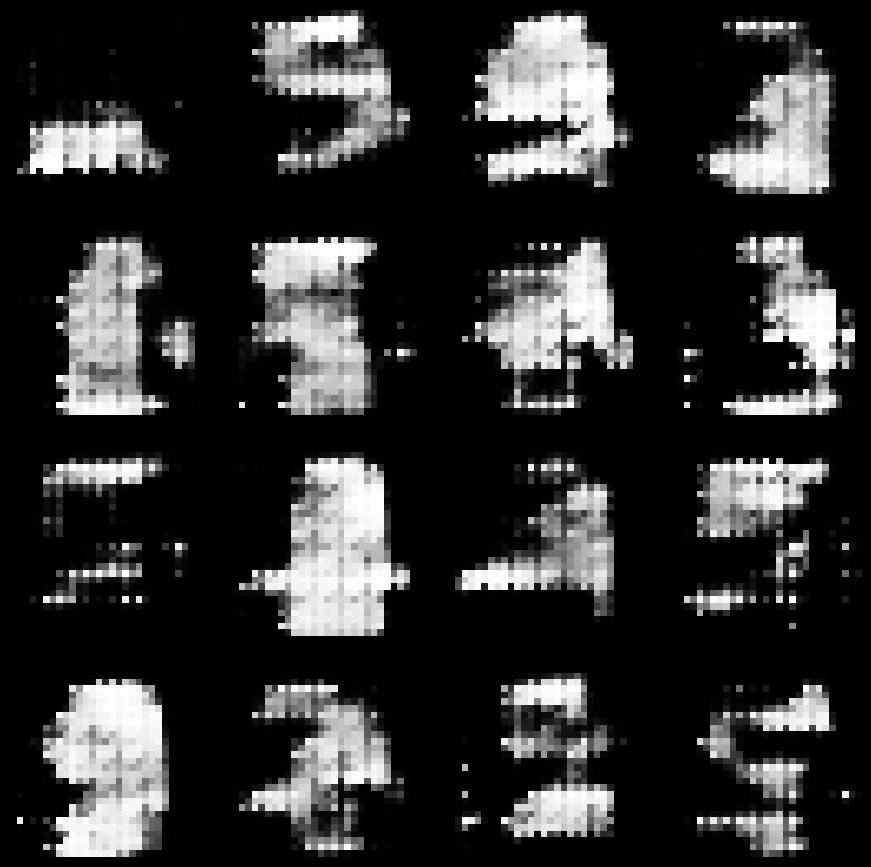

4/4 [==============================] - 0s 3ms/step
100 [D loss: 0.317386, accuracy: 87.11%] [G loss: 2.205071]
1/1 [==============================] - 0s 27ms/step


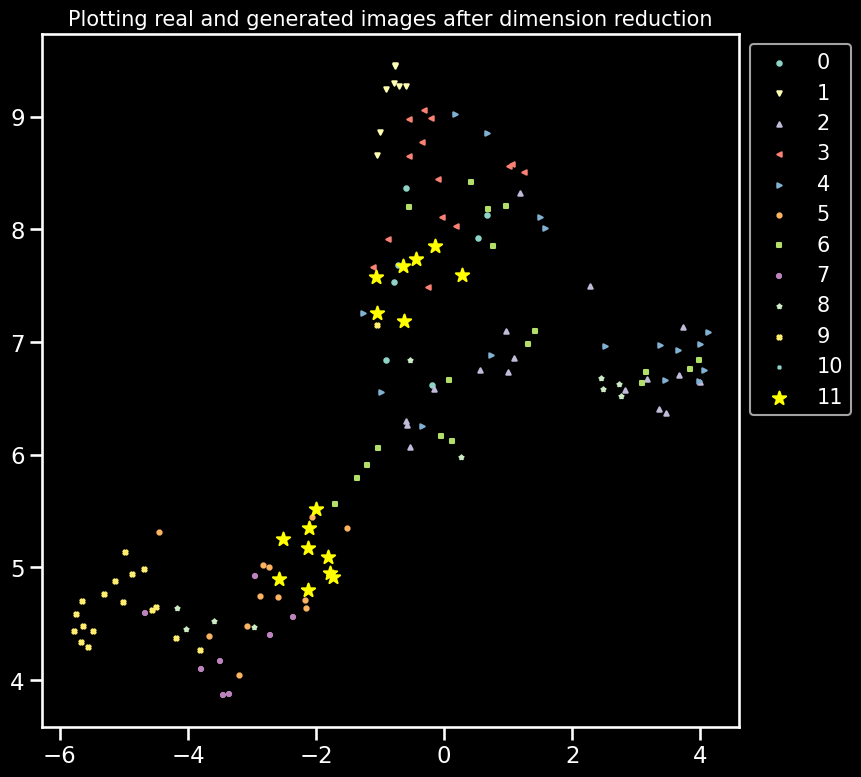

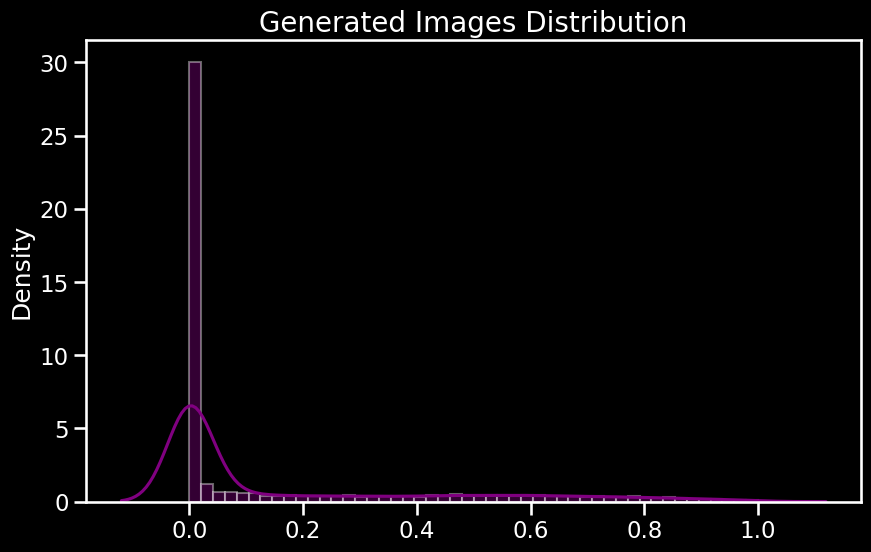

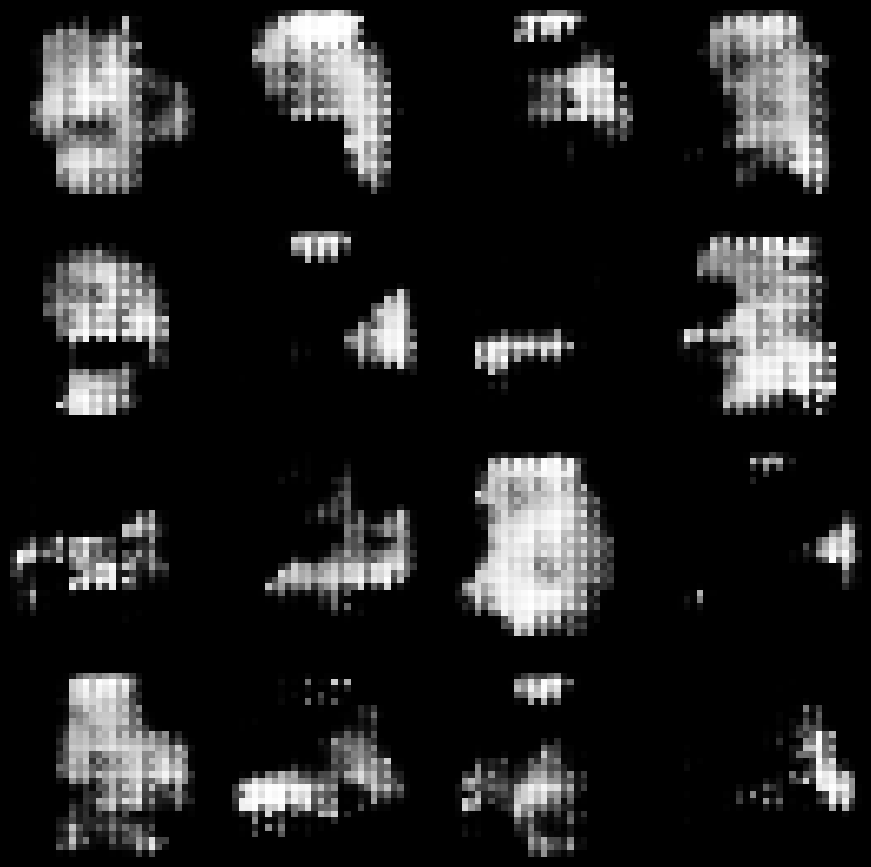

4/4 [==============================] - 0s 3ms/step
120 [D loss: 0.277013, accuracy: 88.67%] [G loss: 2.149350]
1/1 [==============================] - 0s 16ms/step


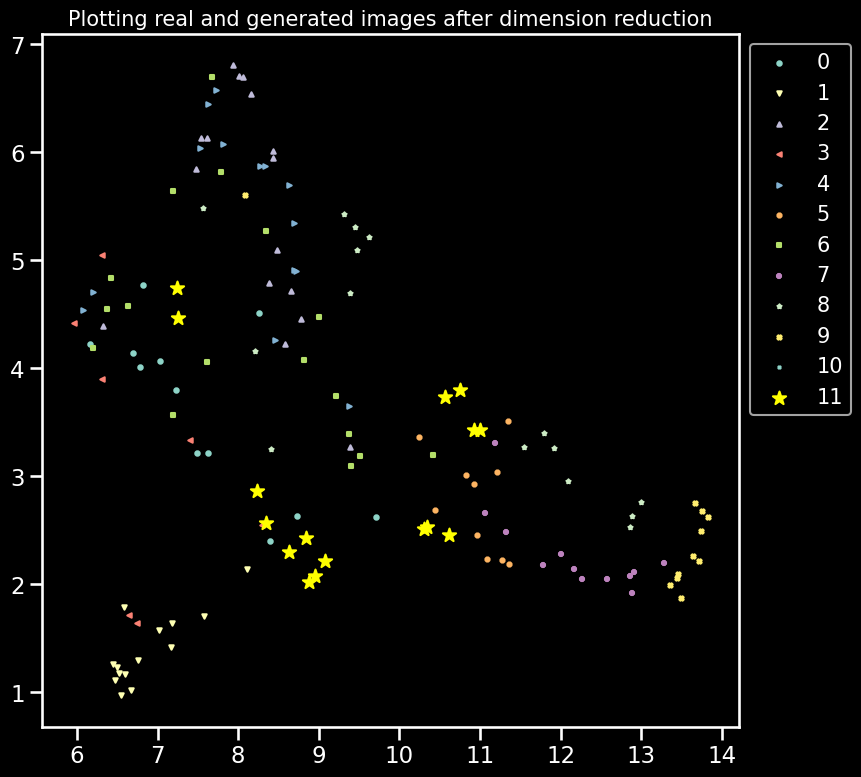

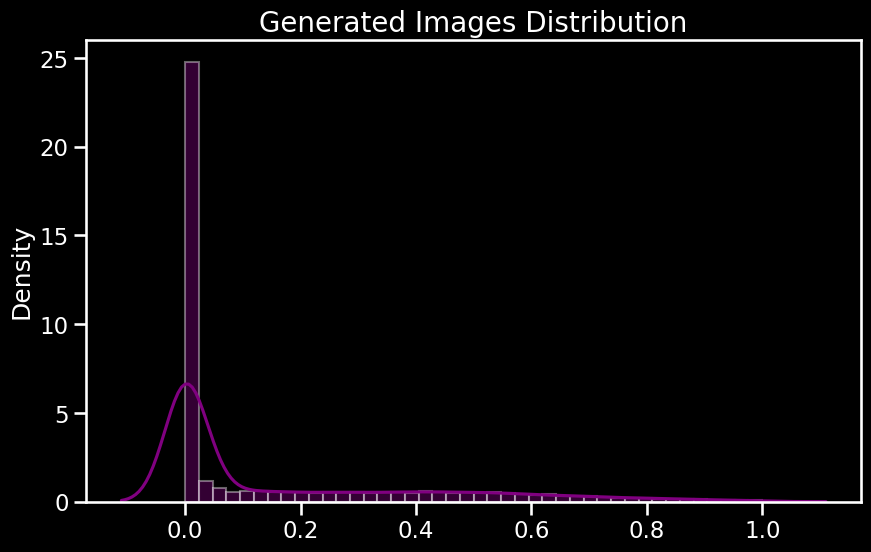

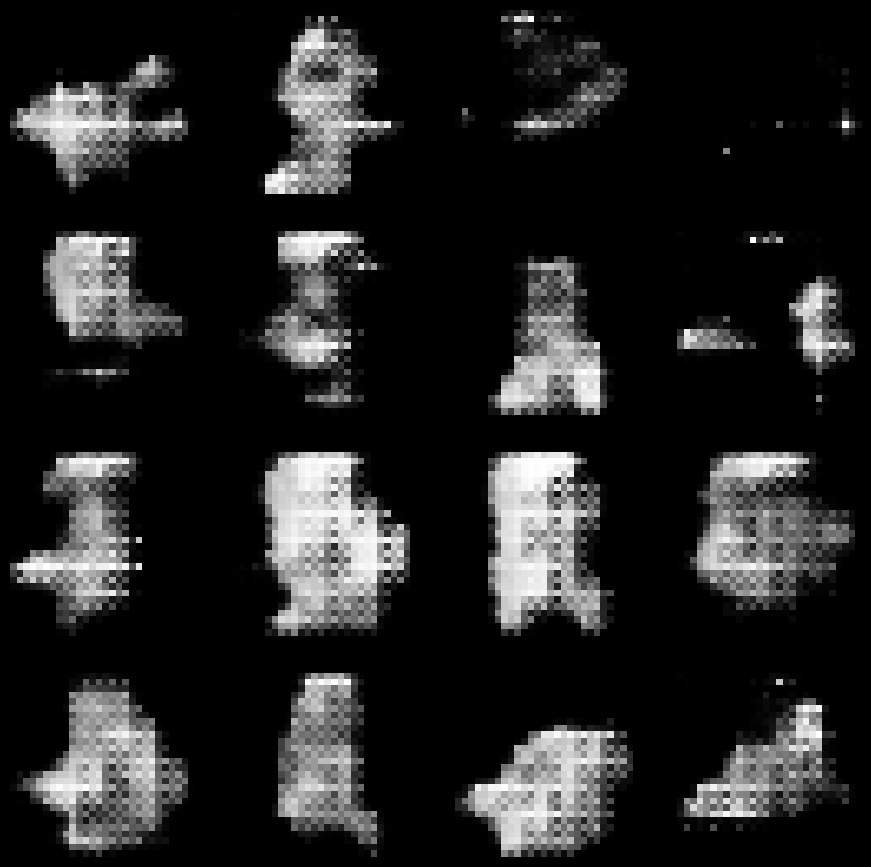

4/4 [==============================] - 0s 3ms/step
140 [D loss: 0.338168, accuracy: 84.77%] [G loss: 1.545975]
1/1 [==============================] - 0s 17ms/step


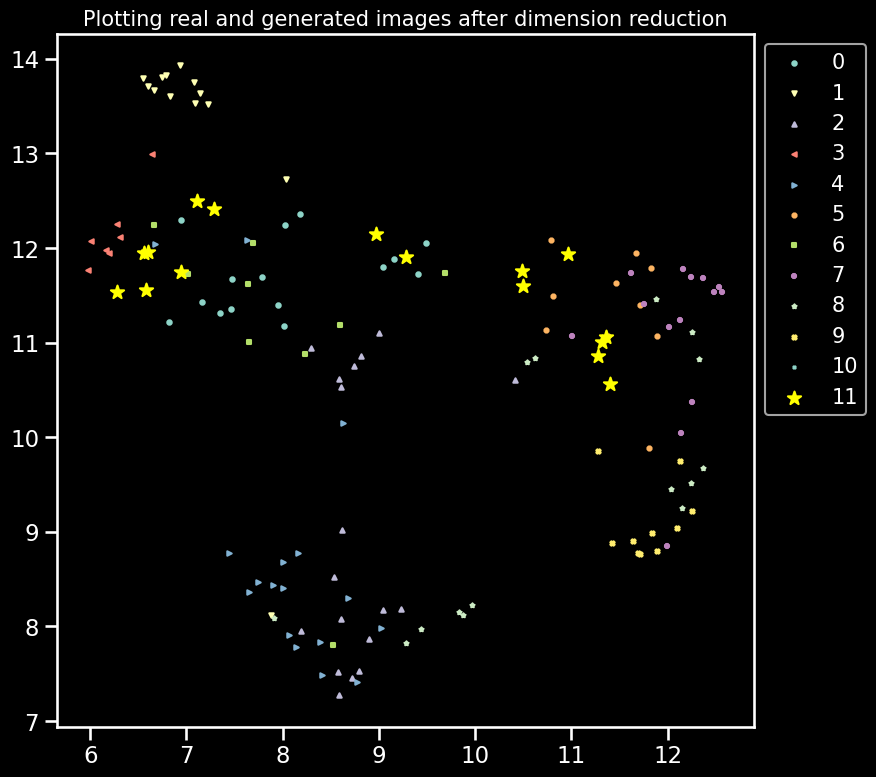

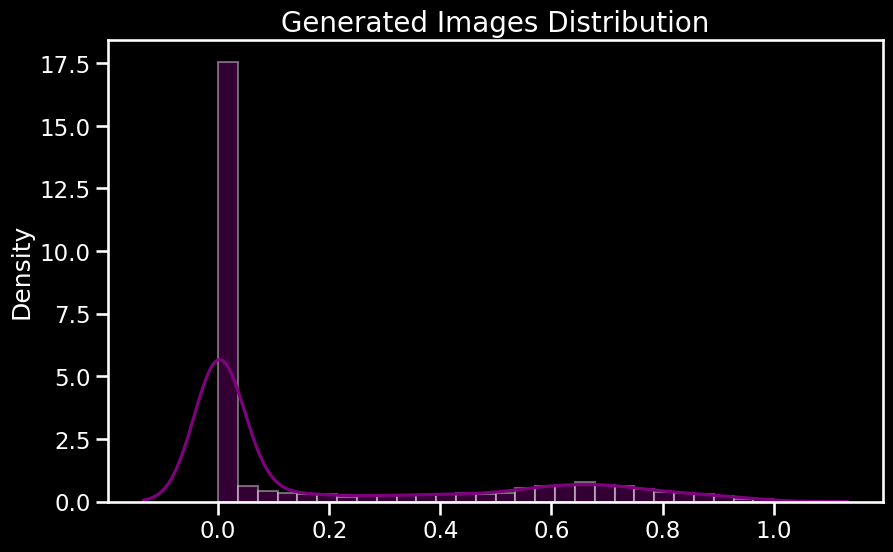

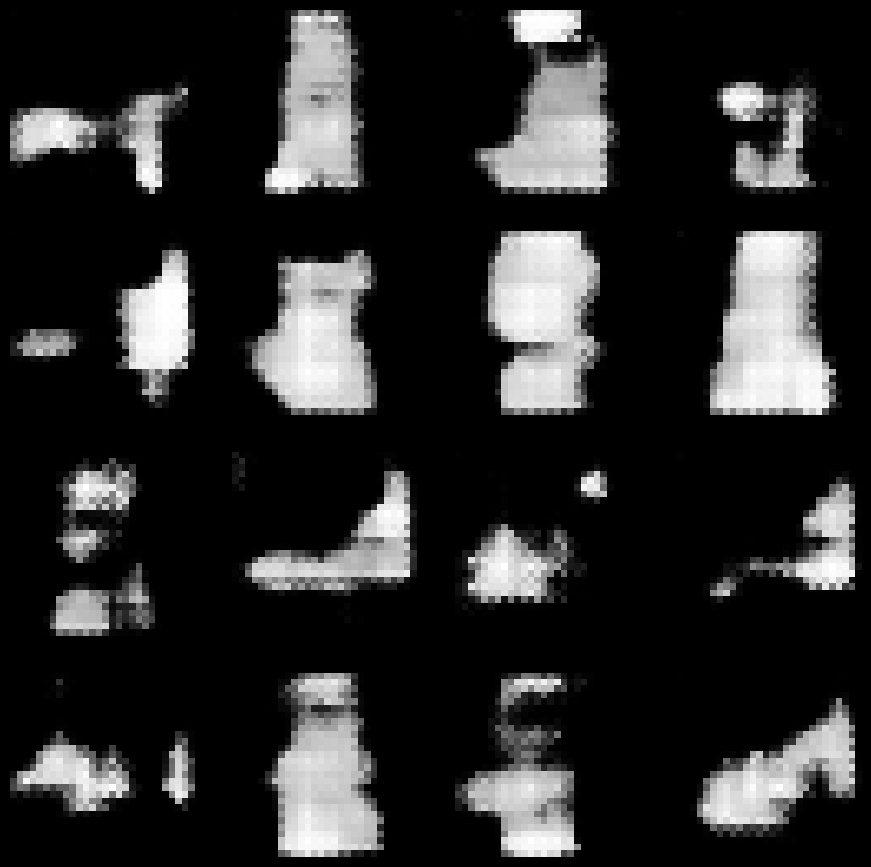

4/4 [==============================] - 0s 3ms/step
160 [D loss: 0.383728, accuracy: 83.59%] [G loss: 1.610501]
1/1 [==============================] - 0s 18ms/step


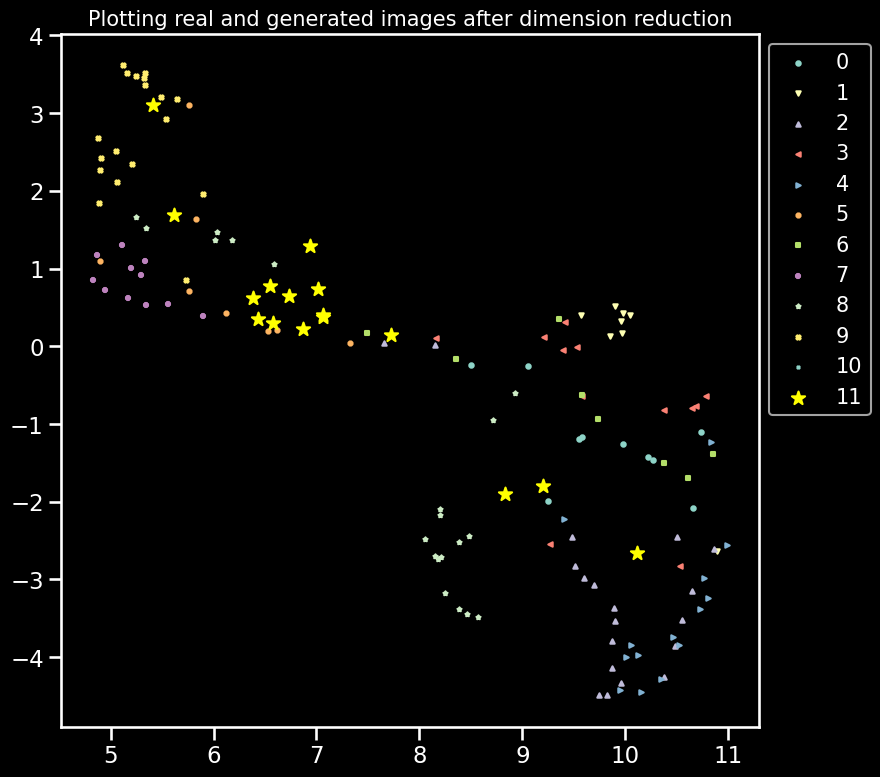

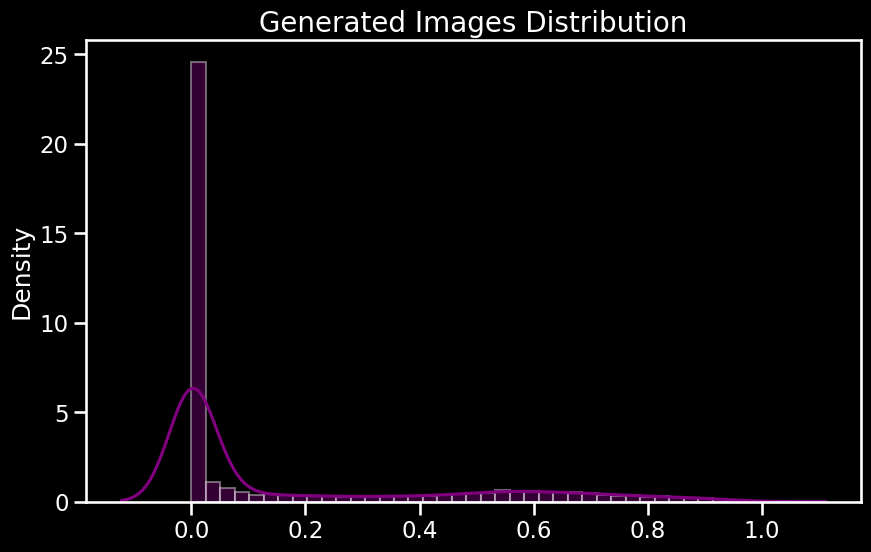

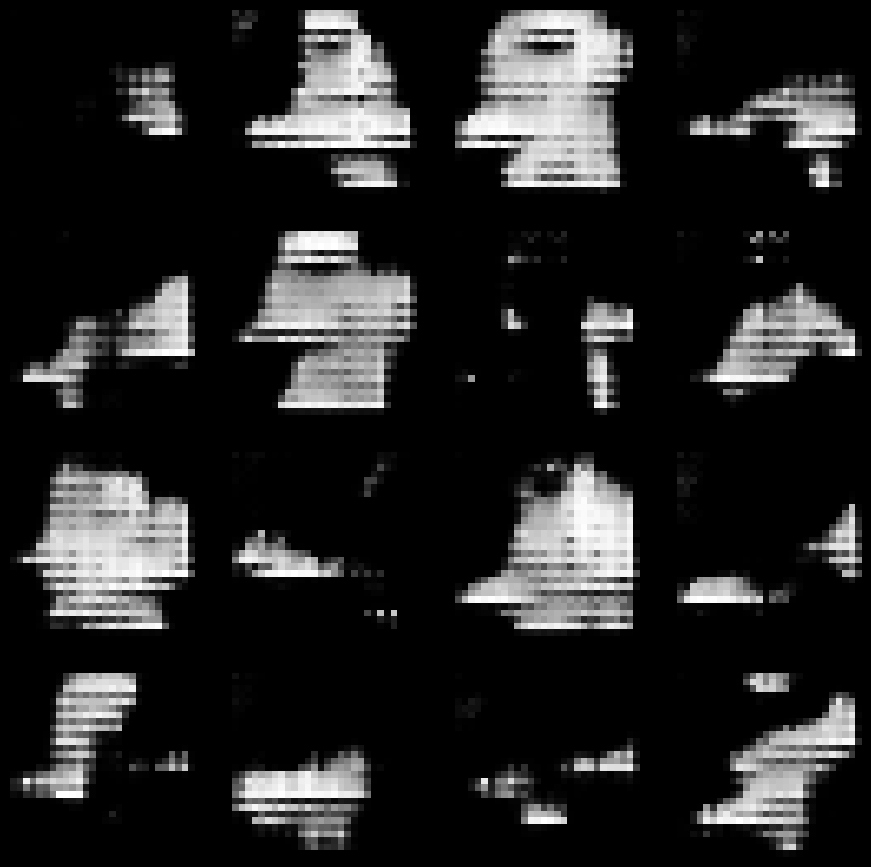

4/4 [==============================] - 0s 3ms/step
180 [D loss: 0.346591, accuracy: 85.55%] [G loss: 1.669906]
1/1 [==============================] - 0s 17ms/step


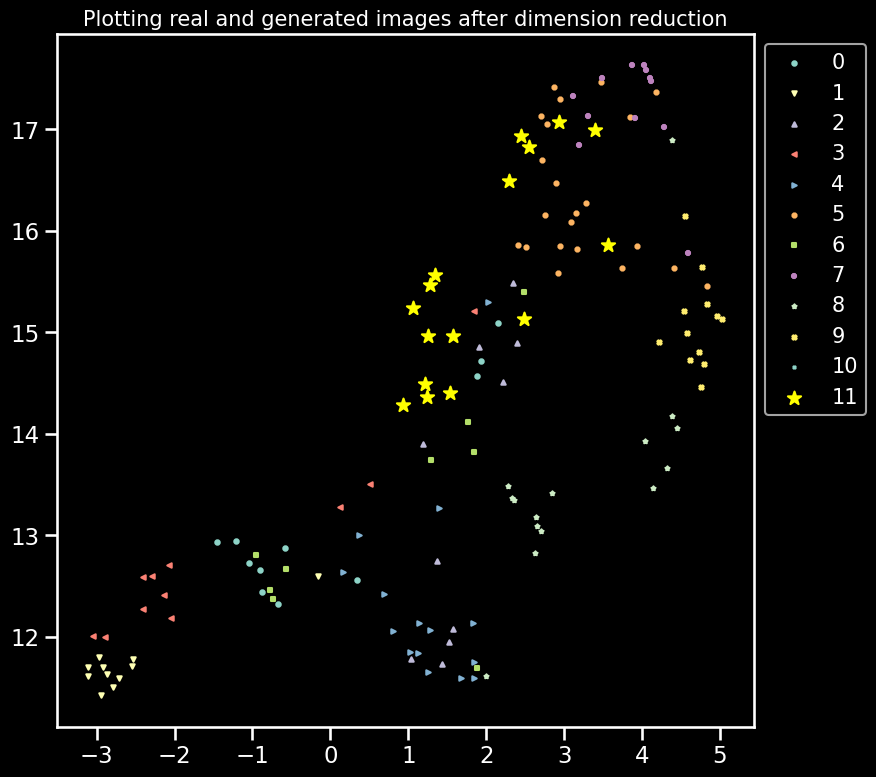

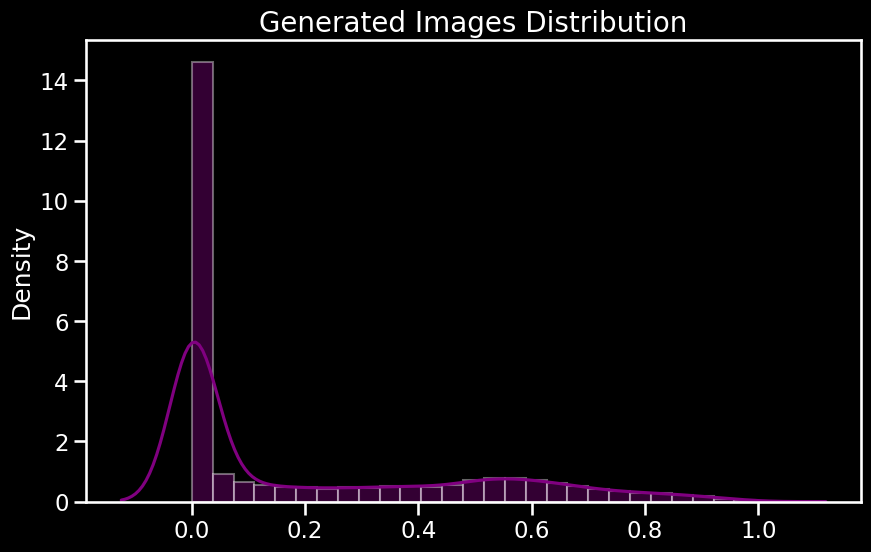

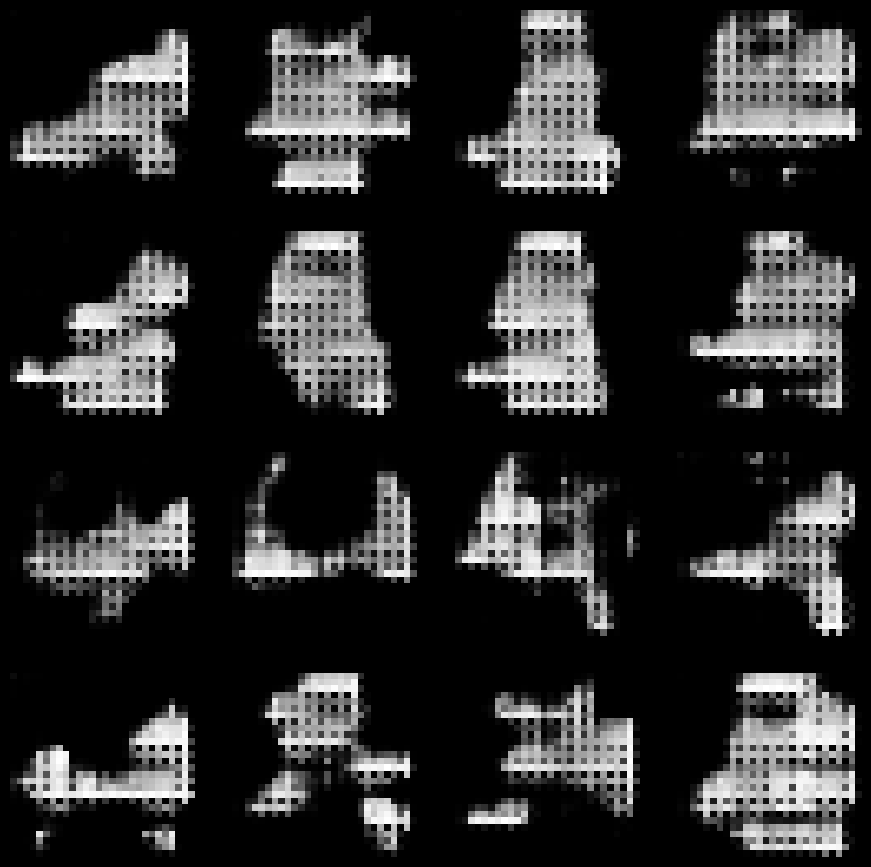

4/4 [==============================] - 0s 3ms/step
200 [D loss: 0.318763, accuracy: 86.72%] [G loss: 1.776404]
1/1 [==============================] - 0s 18ms/step


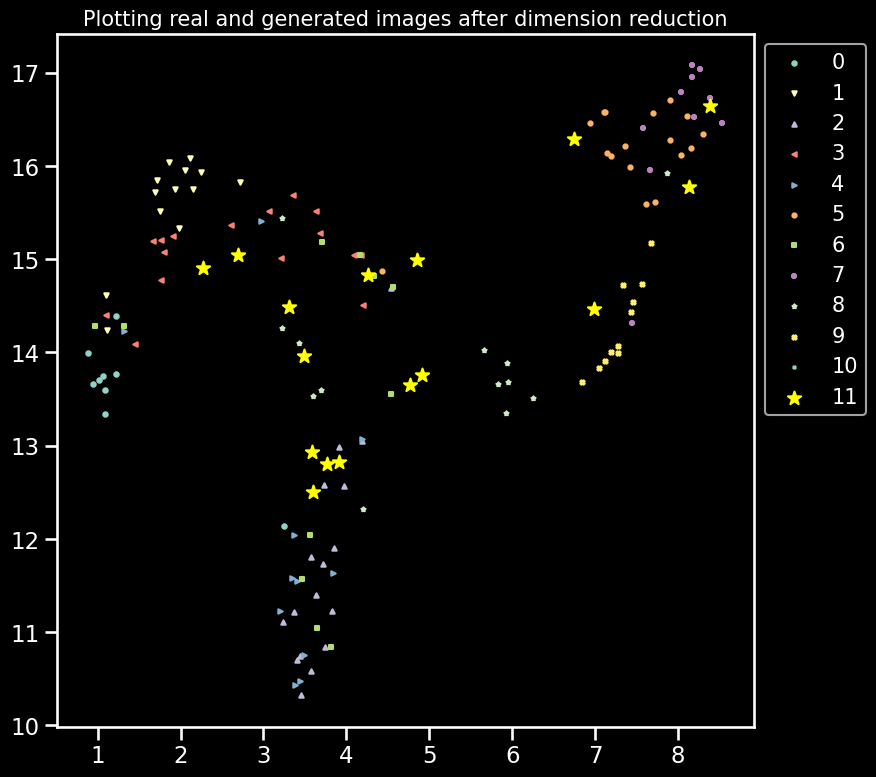

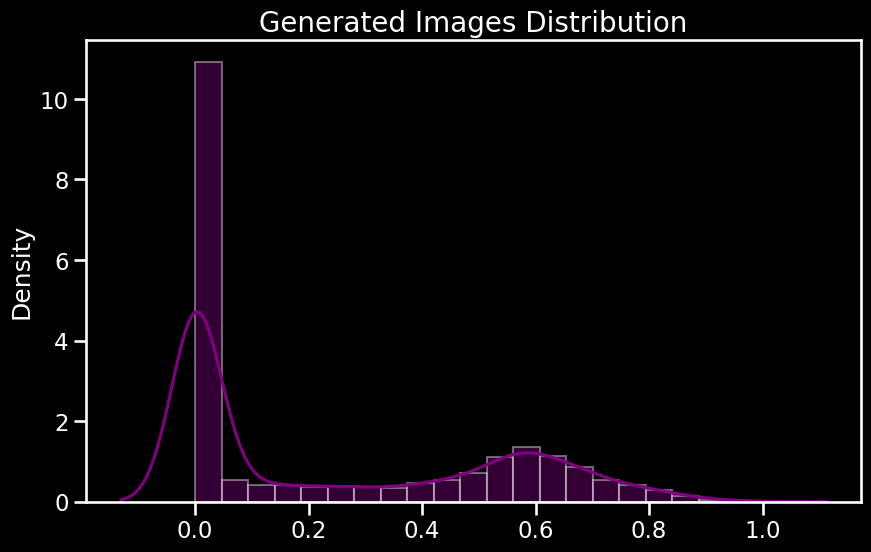

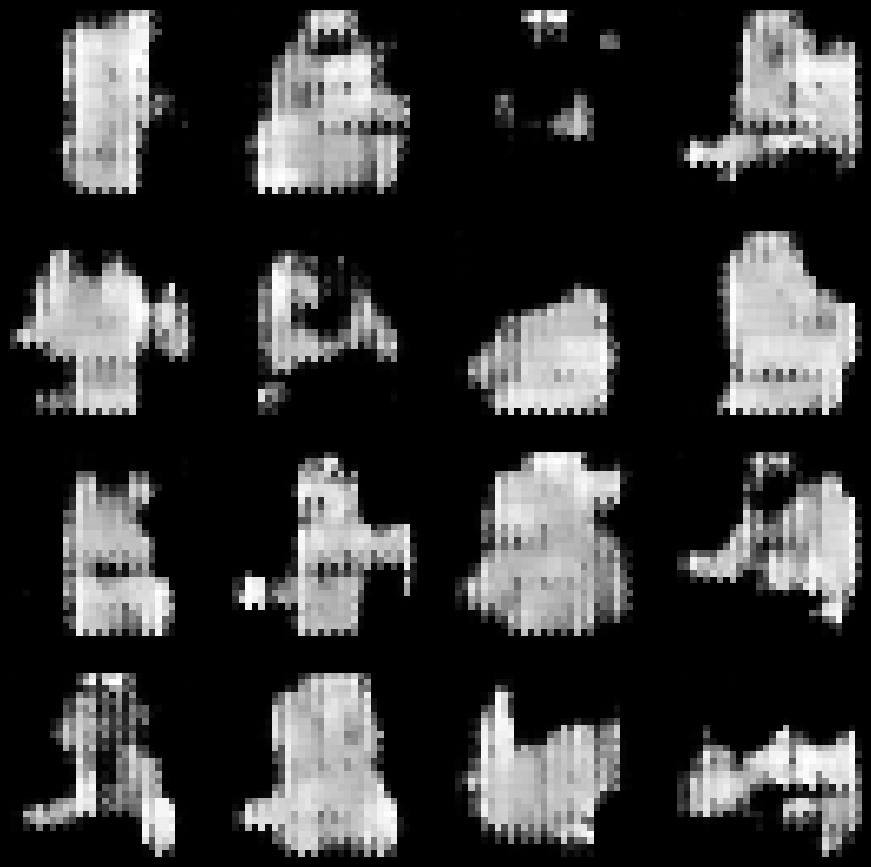

4/4 [==============================] - 0s 3ms/step
400 [D loss: 0.184764, accuracy: 94.14%] [G loss: 1.921408]
1/1 [==============================] - 0s 16ms/step


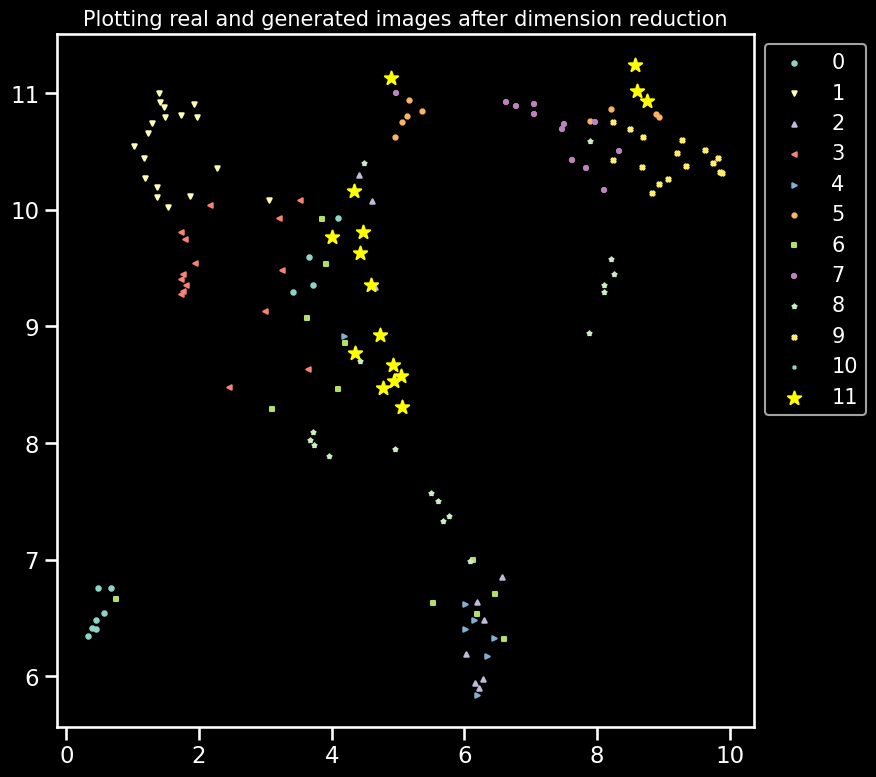

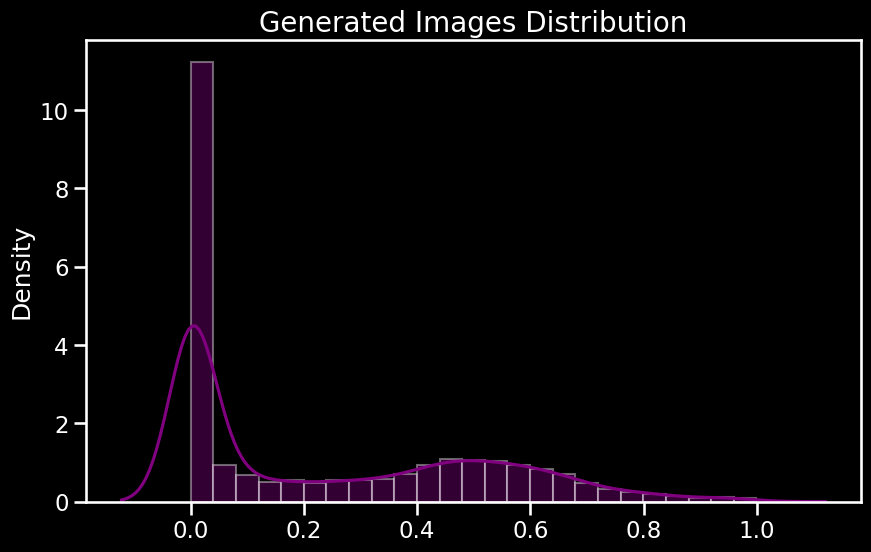

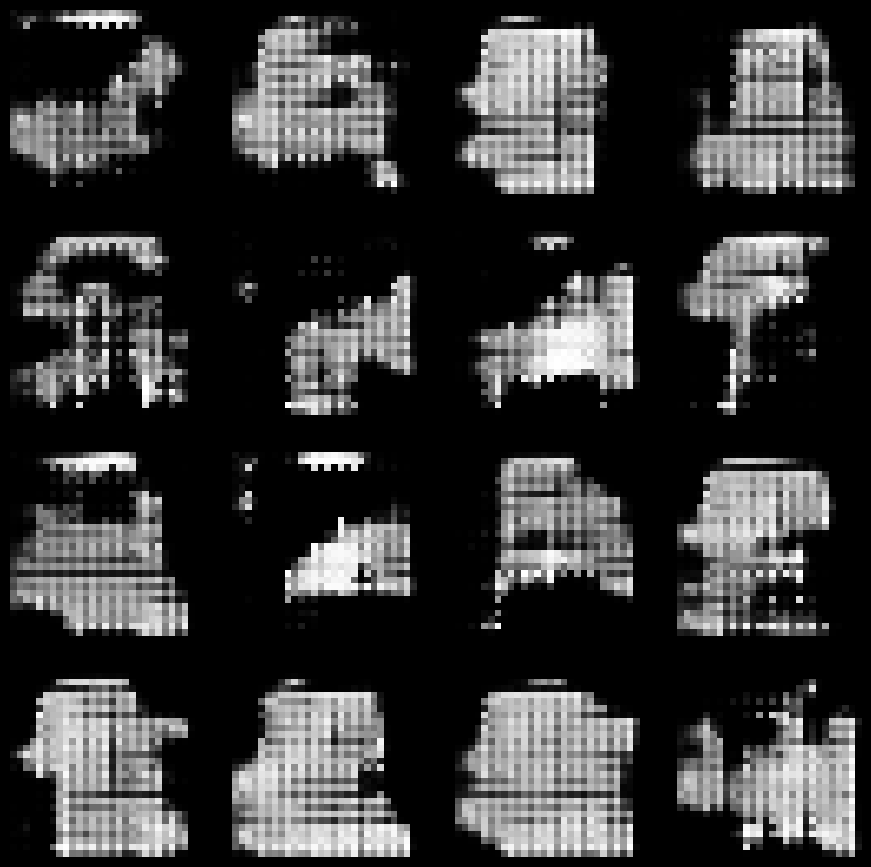

4/4 [==============================] - 0s 3ms/step
800 [D loss: 0.270844, accuracy: 90.23%] [G loss: 2.651870]
1/1 [==============================] - 0s 23ms/step


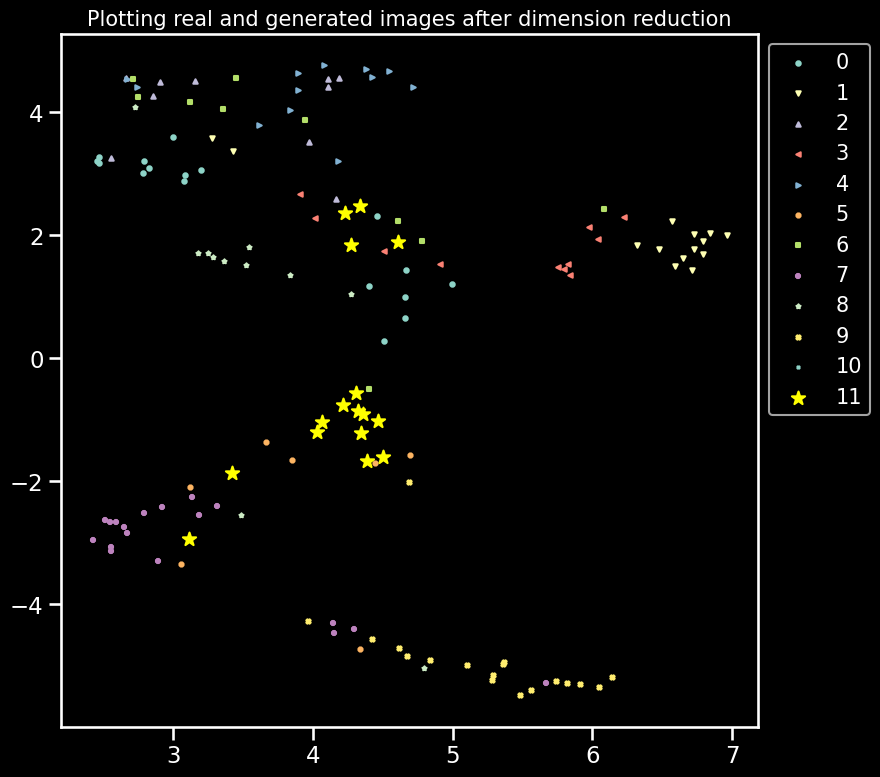

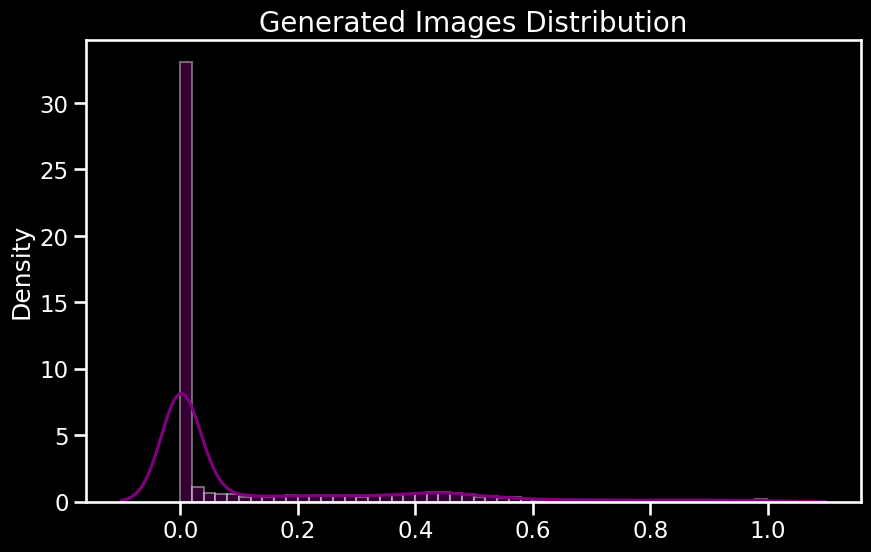

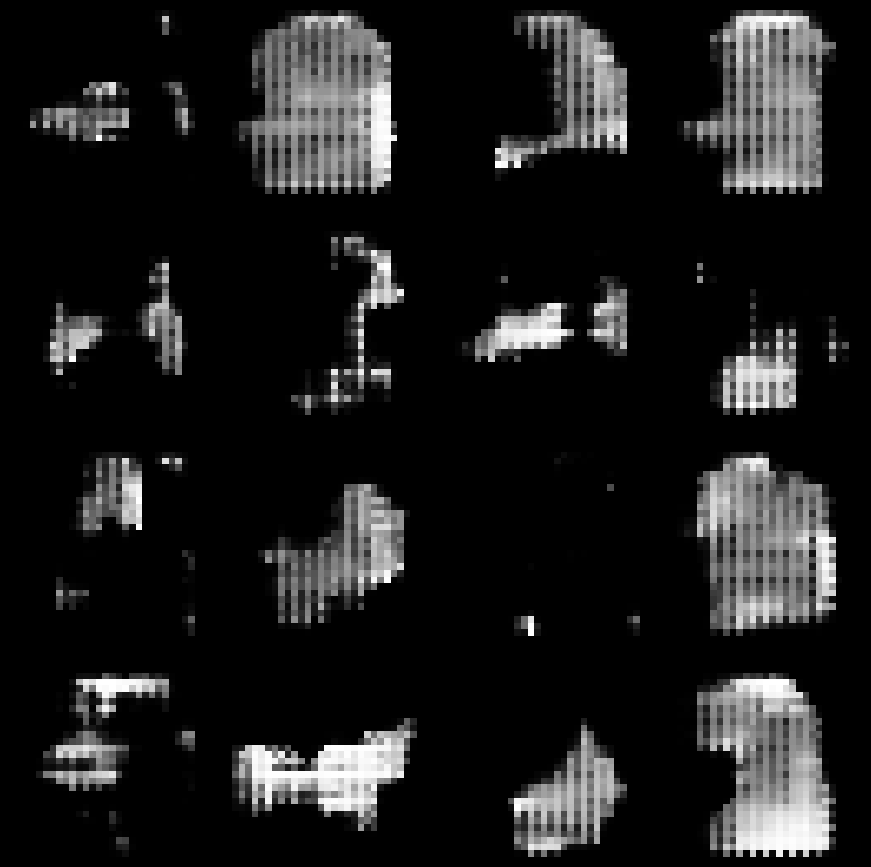

4/4 [==============================] - 0s 3ms/step
1200 [D loss: 0.183004, accuracy: 93.75%] [G loss: 4.189177]
1/1 [==============================] - 0s 16ms/step


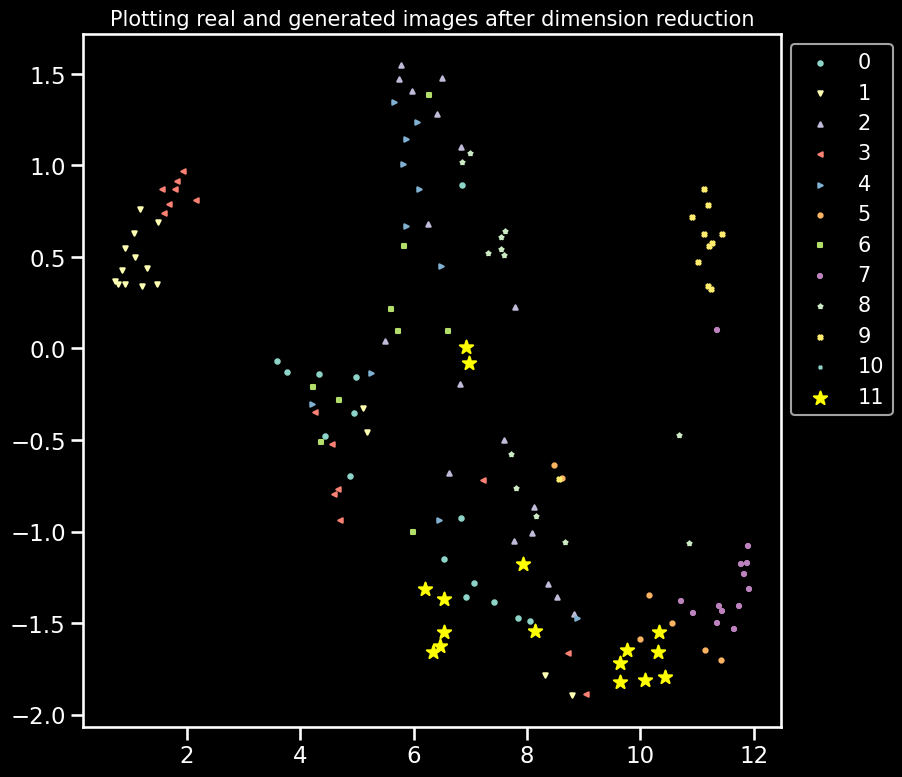

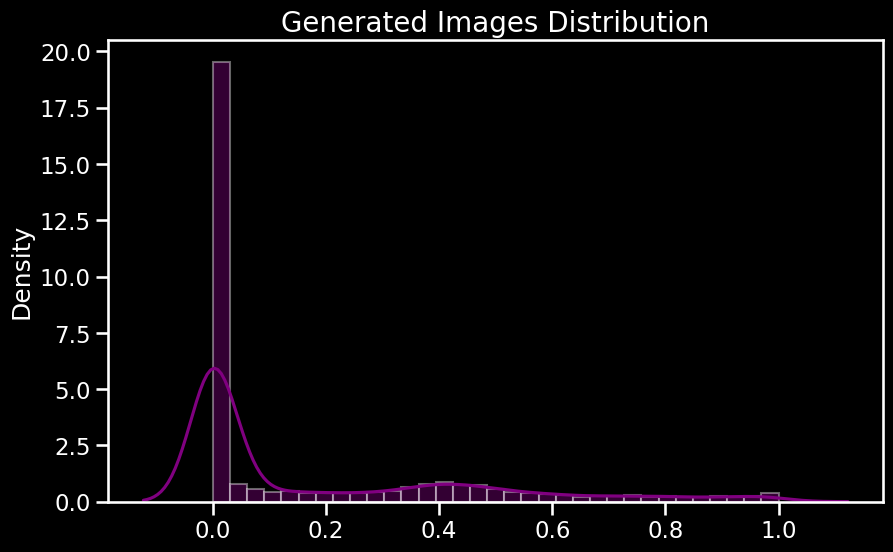

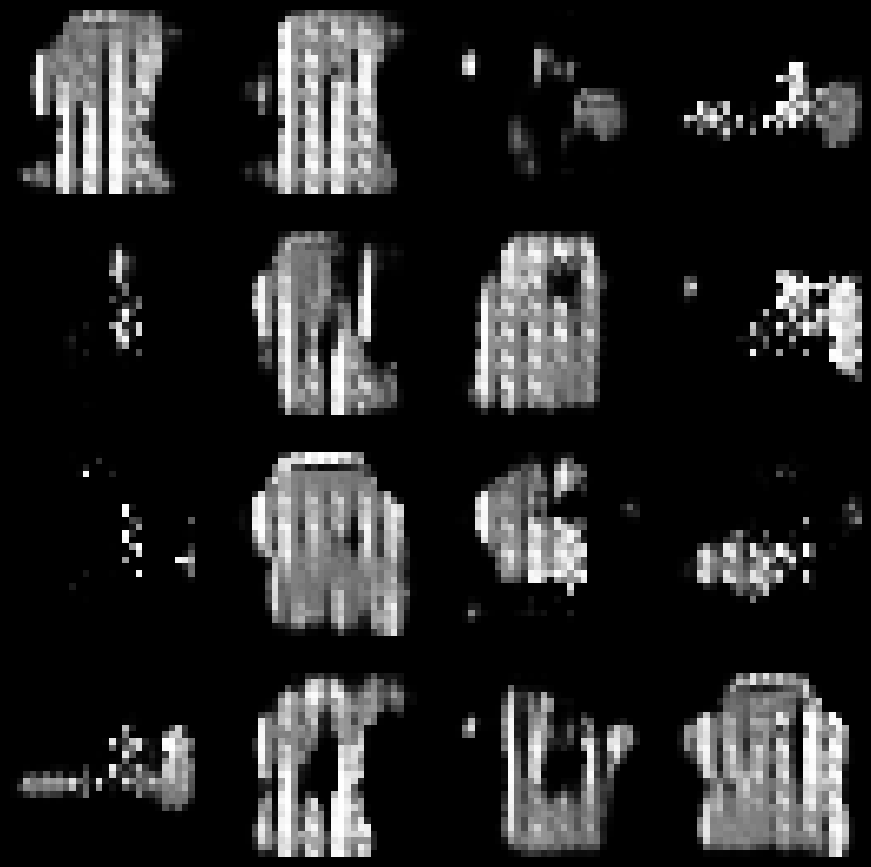

4/4 [==============================] - 0s 3ms/step
1600 [D loss: 0.190234, accuracy: 93.36%] [G loss: 3.339975]
1/1 [==============================] - 0s 17ms/step


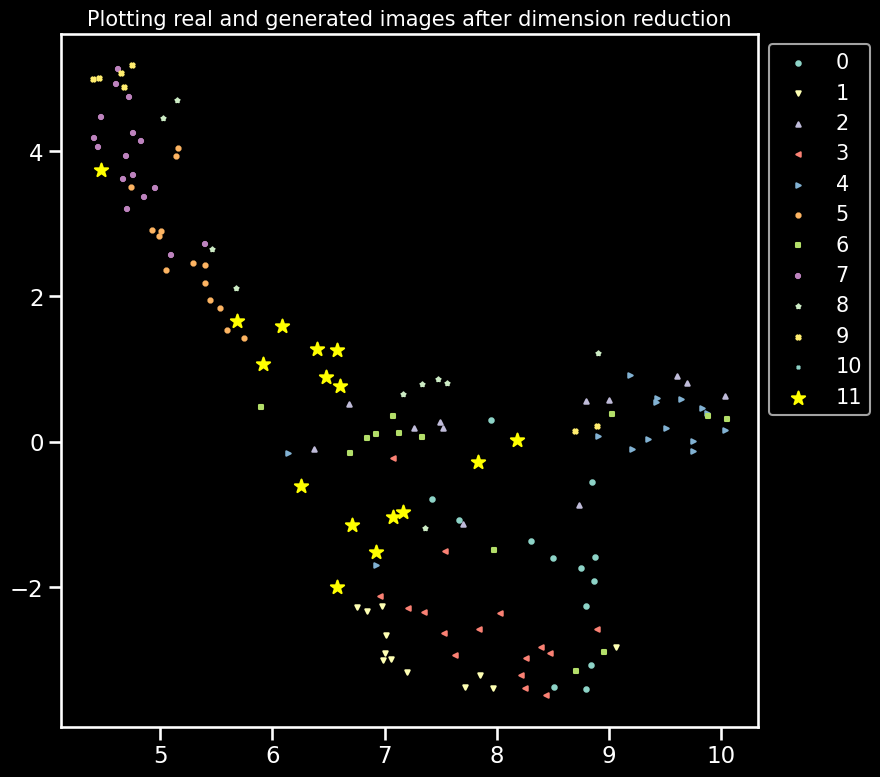

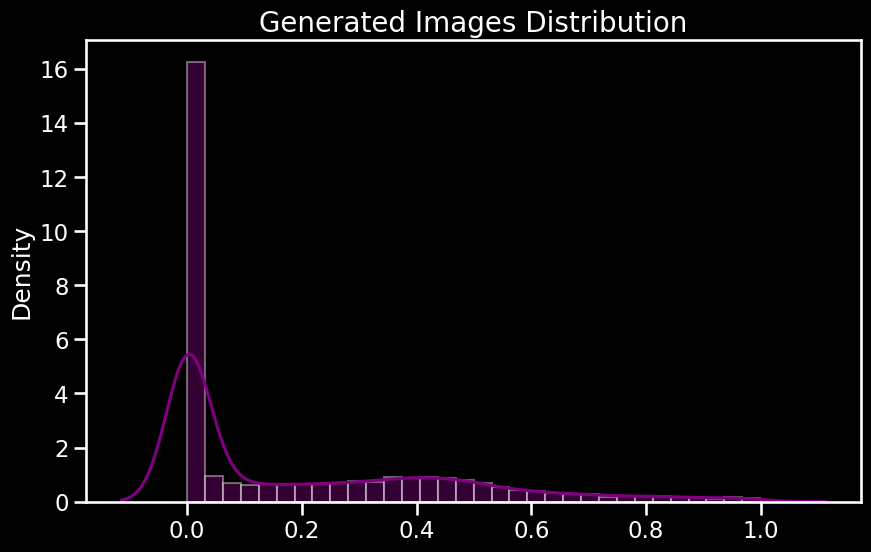

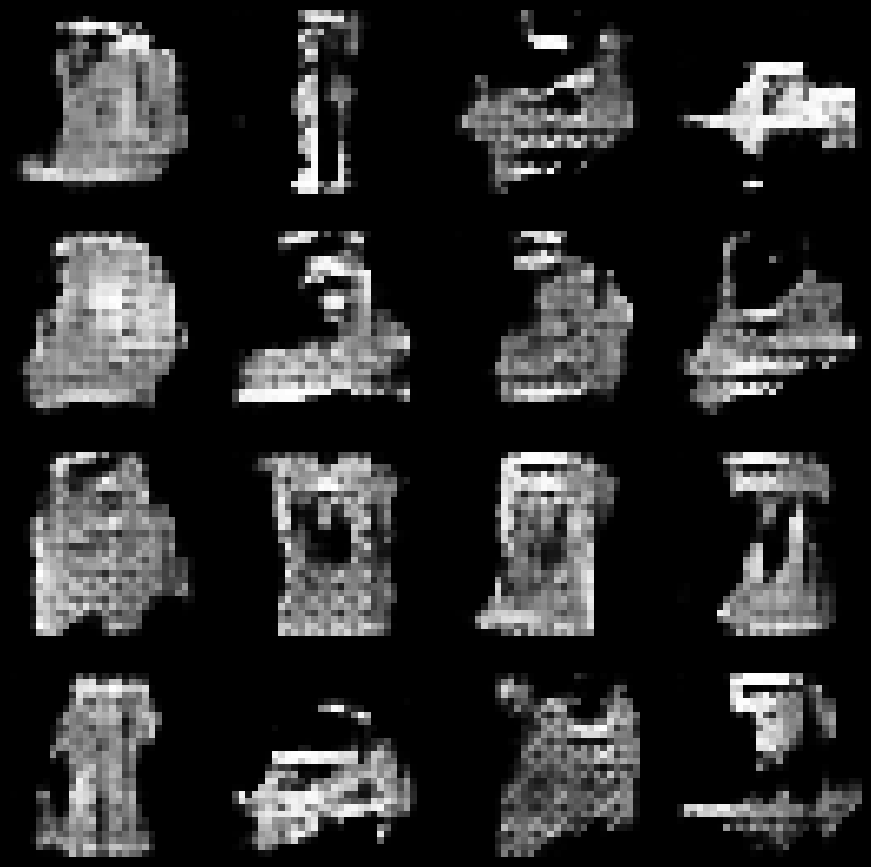

4/4 [==============================] - 0s 5ms/step
2000 [D loss: 0.157328, accuracy: 94.53%] [G loss: 3.442654]
1/1 [==============================] - 0s 27ms/step


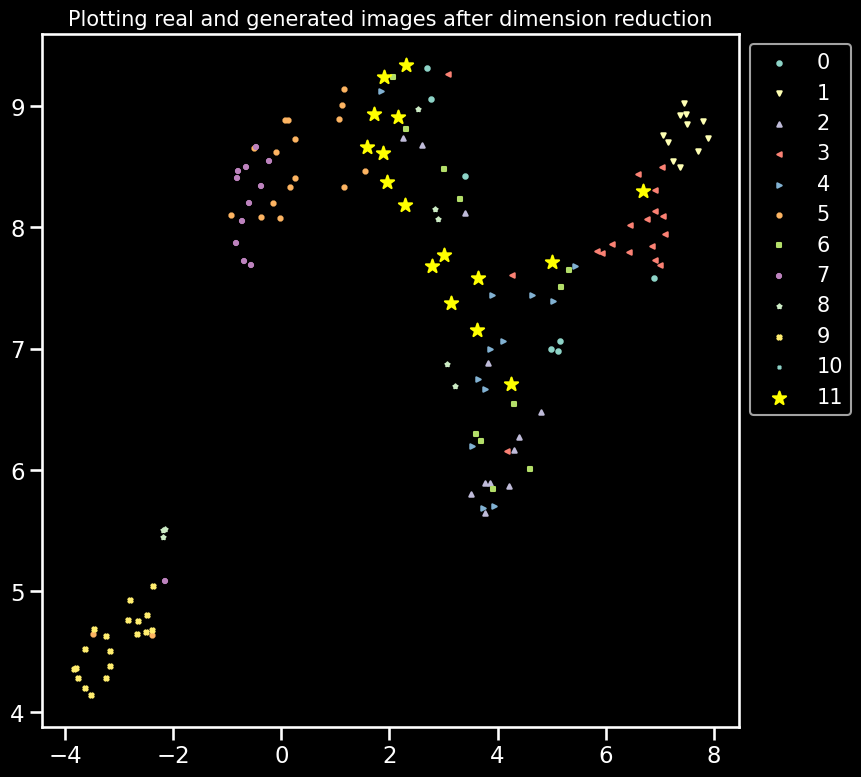

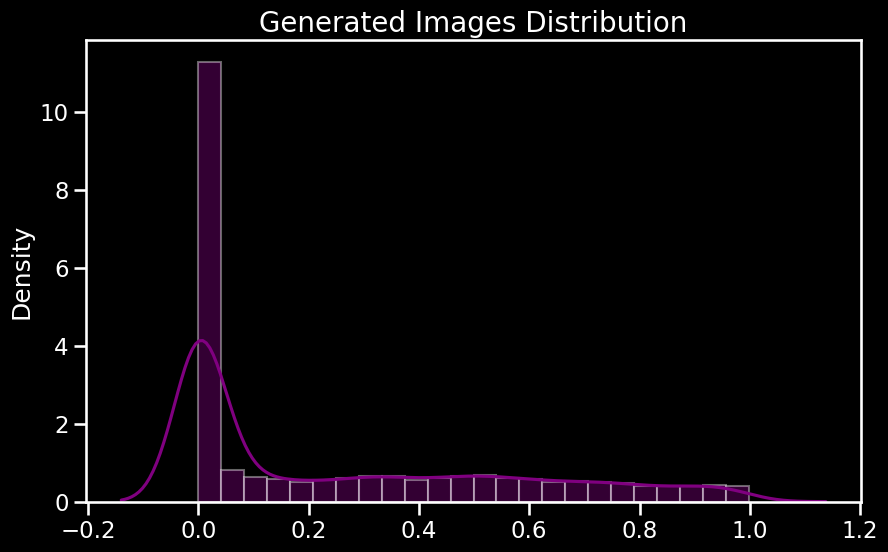

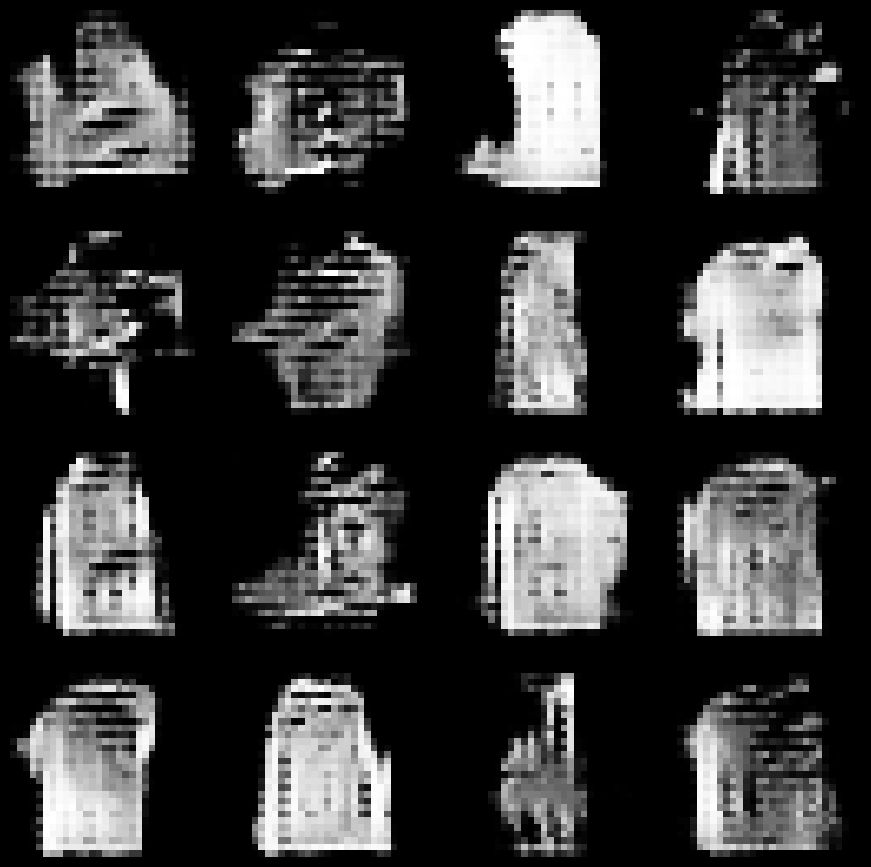

4/4 [==============================] - 0s 3ms/step
2400 [D loss: 0.289474, accuracy: 87.50%] [G loss: 2.506536]
1/1 [==============================] - 0s 17ms/step


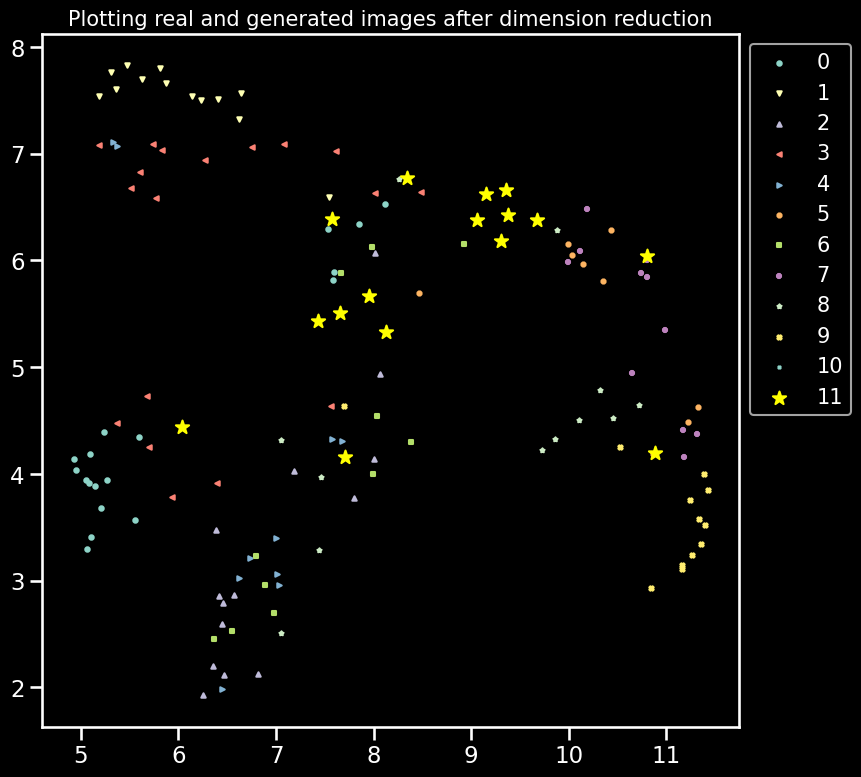

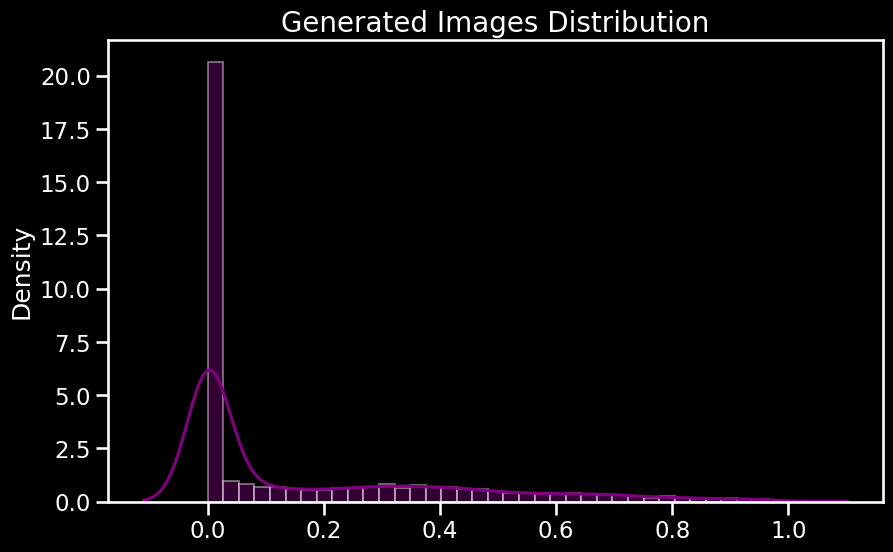

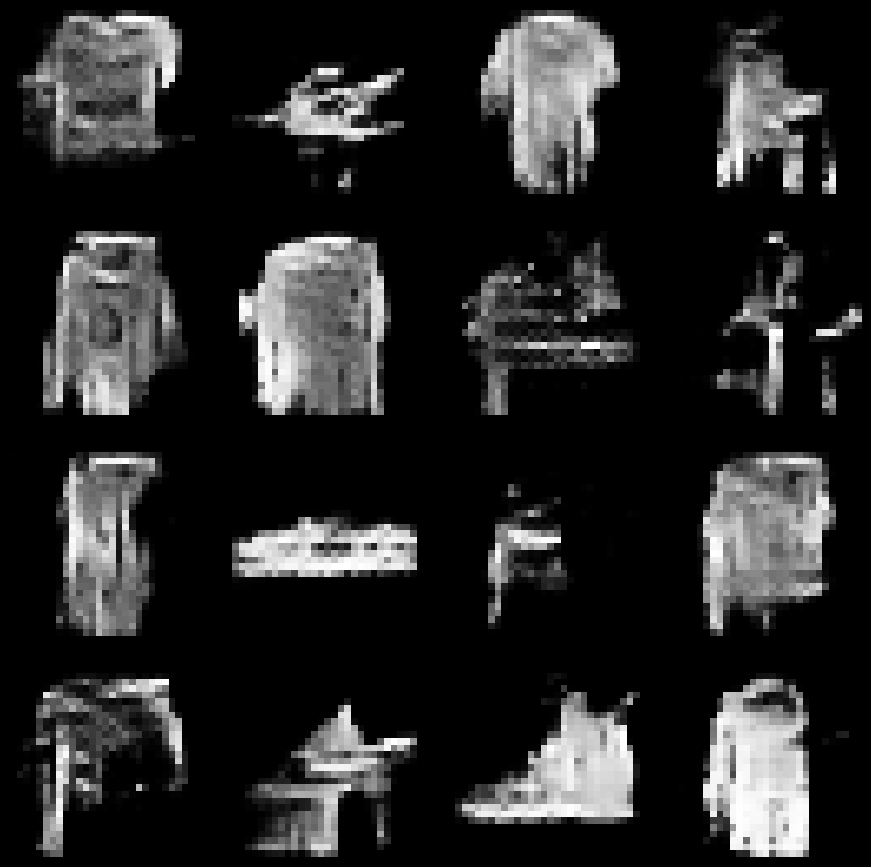

4/4 [==============================] - 0s 3ms/step
2800 [D loss: 0.244276, accuracy: 89.84%] [G loss: 2.865574]
1/1 [==============================] - 0s 17ms/step


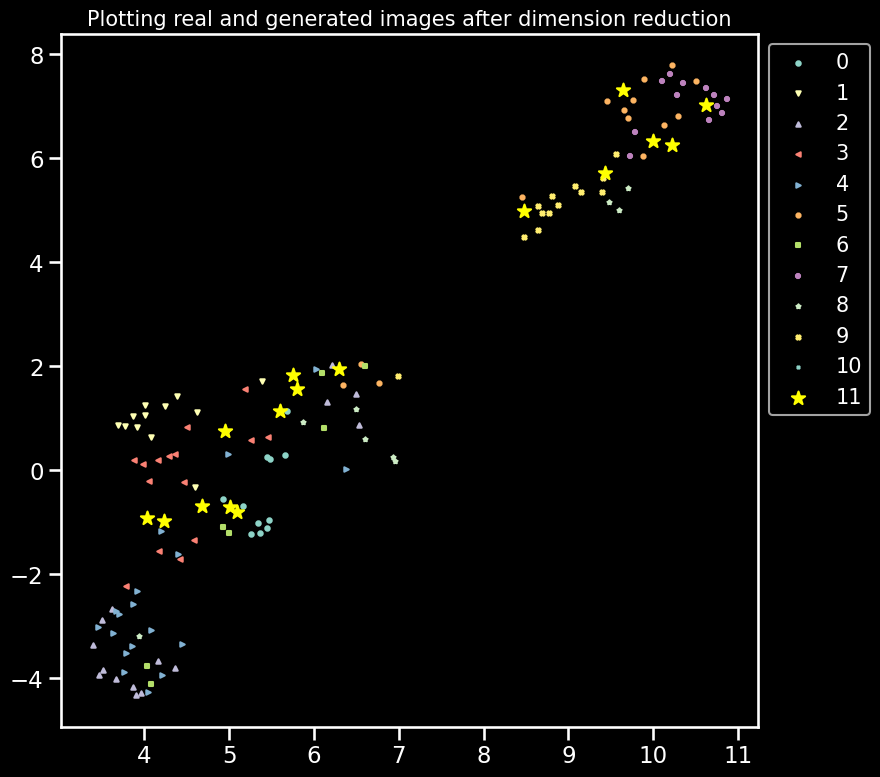

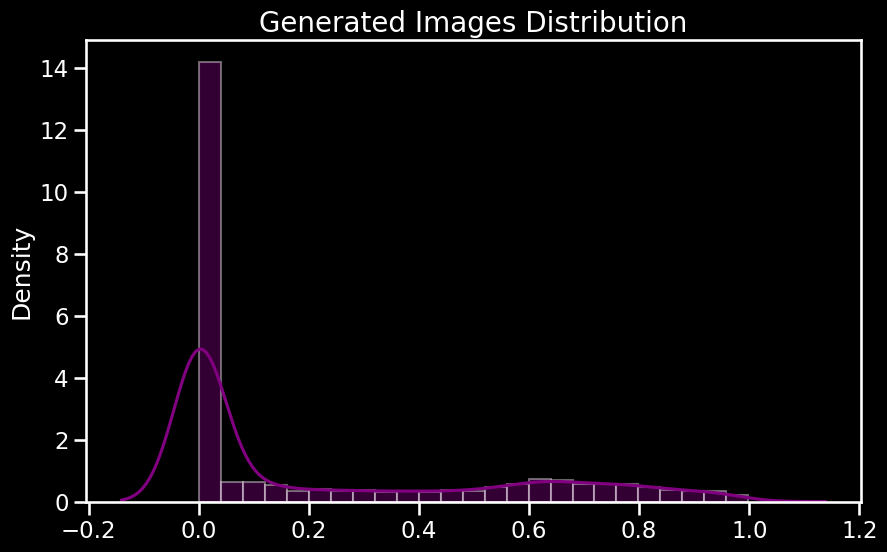

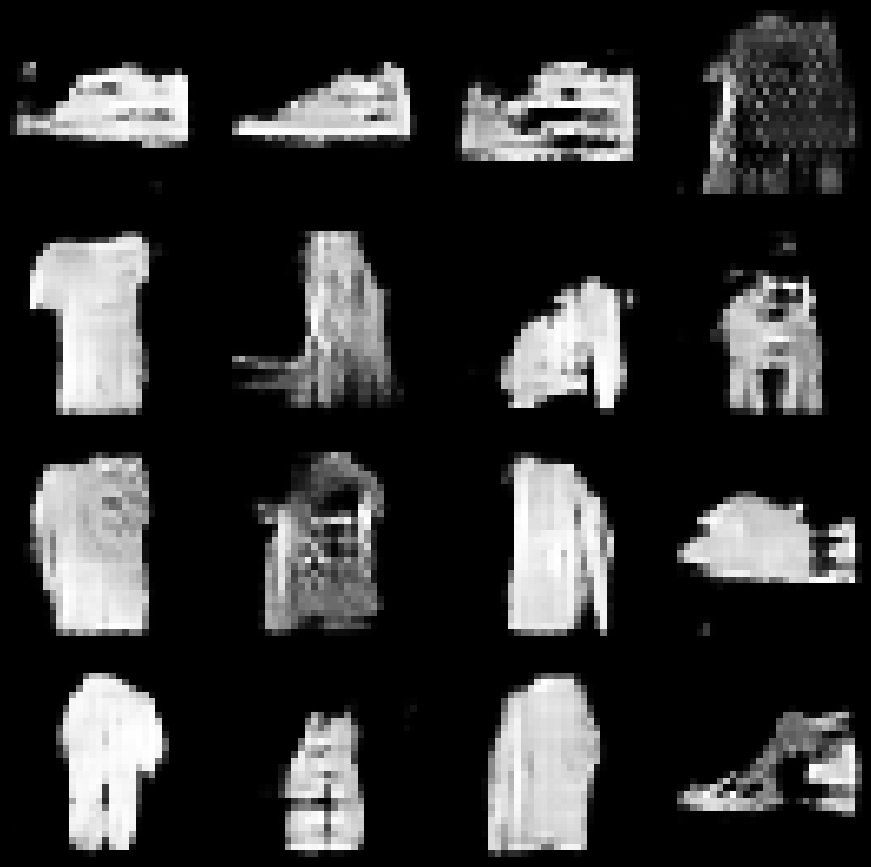

4/4 [==============================] - 0s 3ms/step
3200 [D loss: 0.186428, accuracy: 93.36%] [G loss: 2.516640]
1/1 [==============================] - 0s 16ms/step


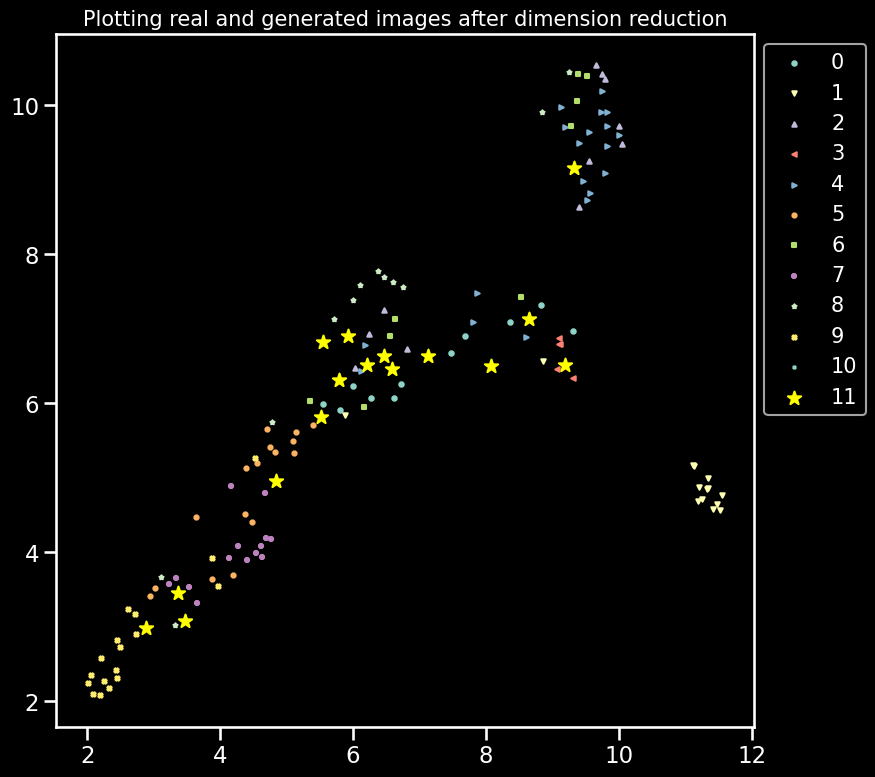

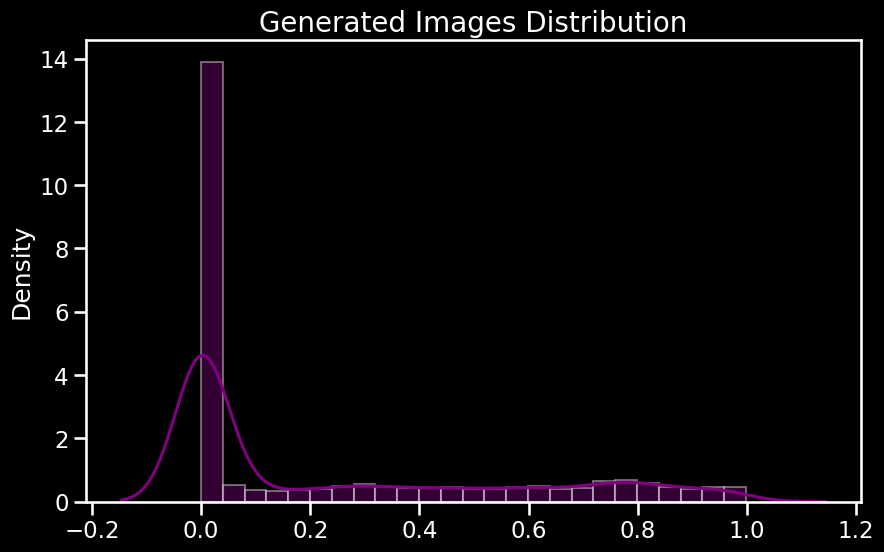

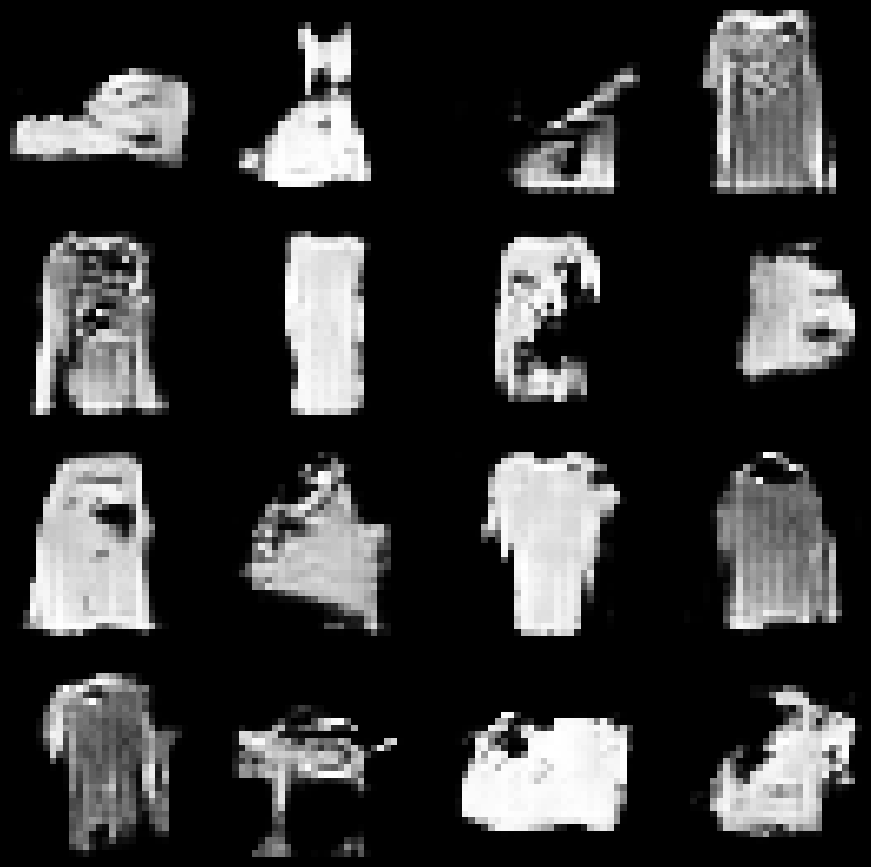

4/4 [==============================] - 0s 3ms/step
3600 [D loss: 0.194364, accuracy: 93.75%] [G loss: 3.359566]
1/1 [==============================] - 0s 17ms/step


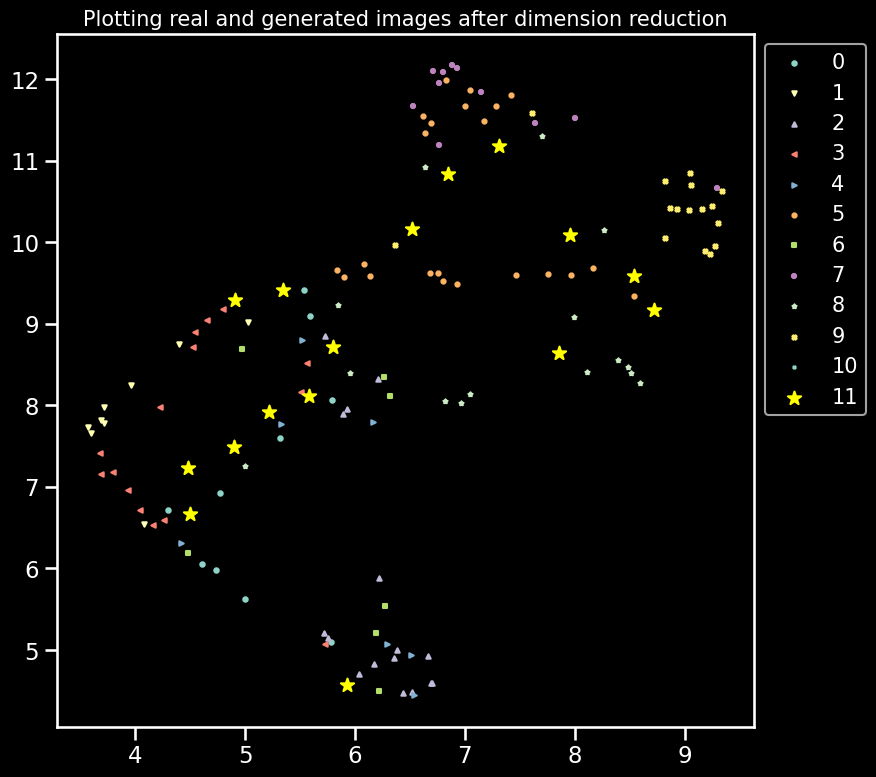

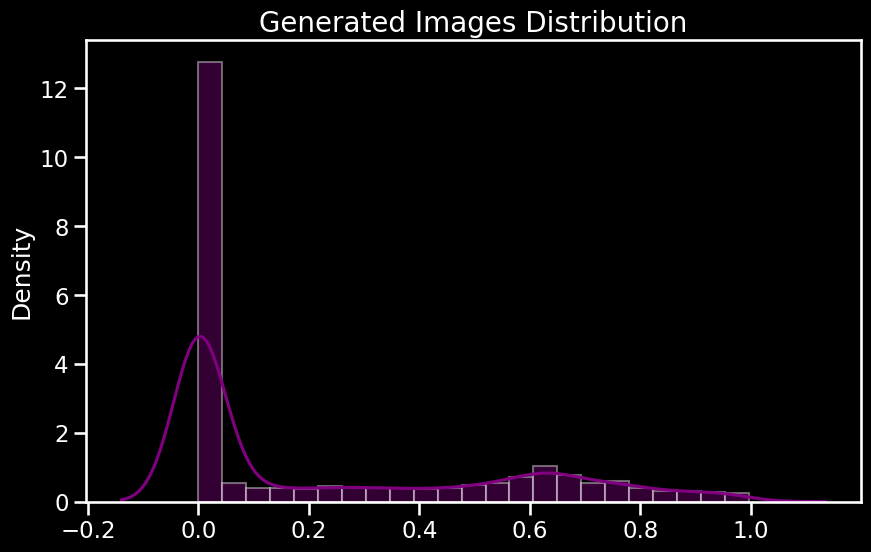

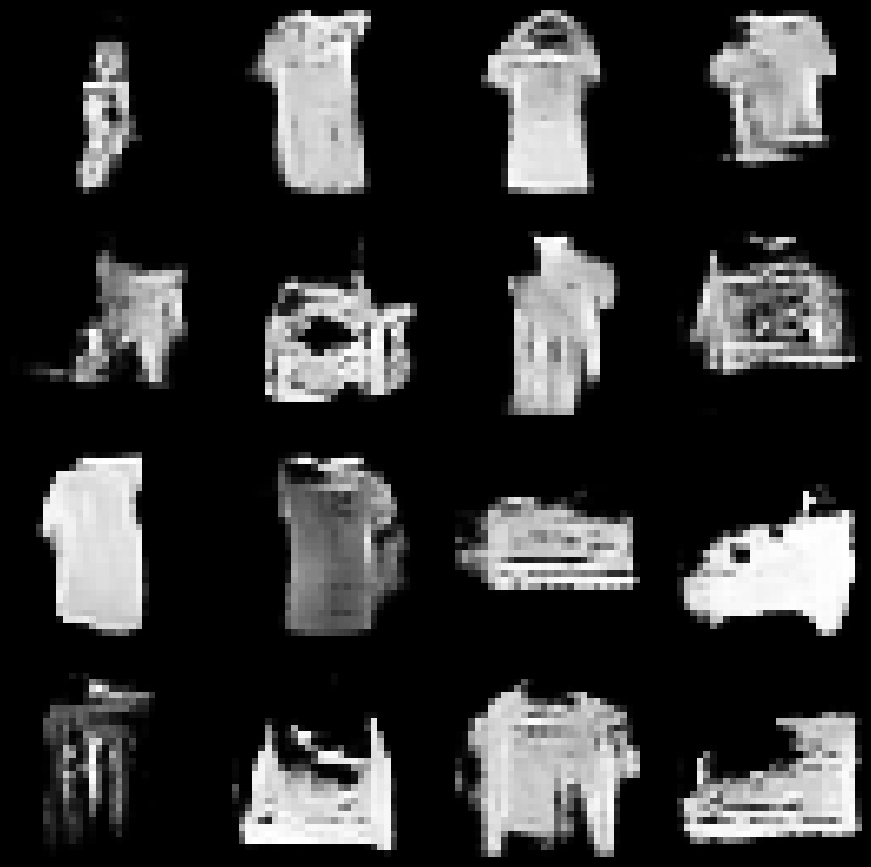

4/4 [==============================] - 0s 3ms/step
4000 [D loss: 0.224909, accuracy: 91.02%] [G loss: 2.379977]
1/1 [==============================] - 0s 17ms/step


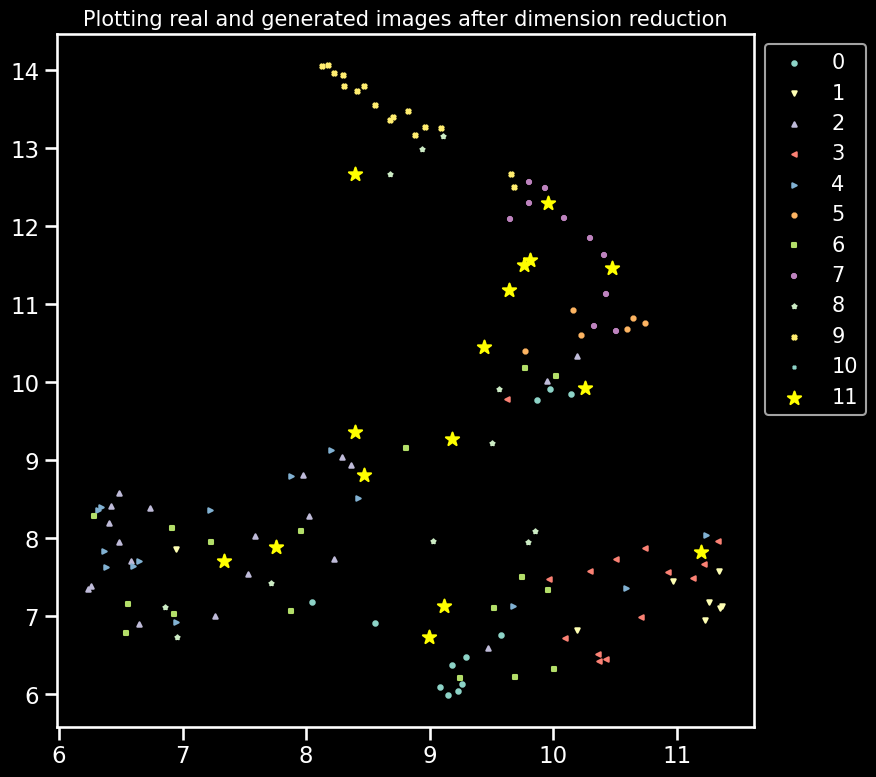

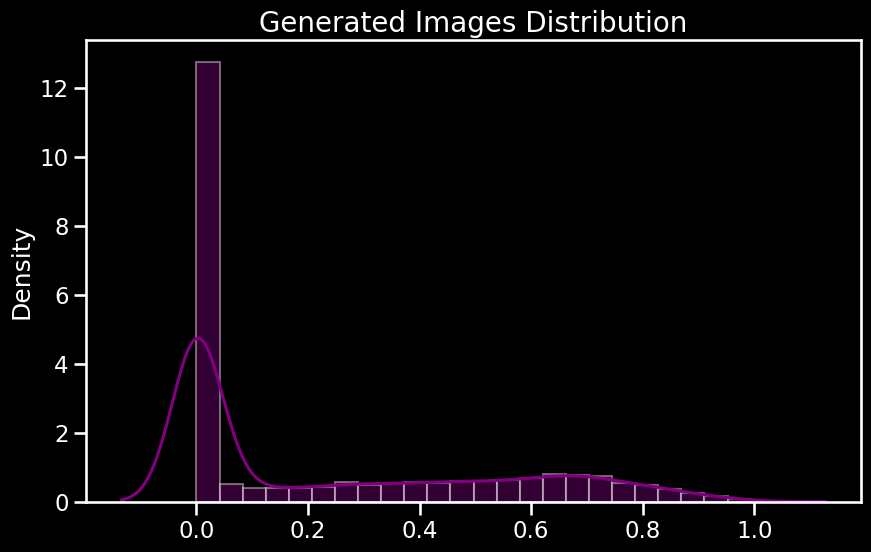

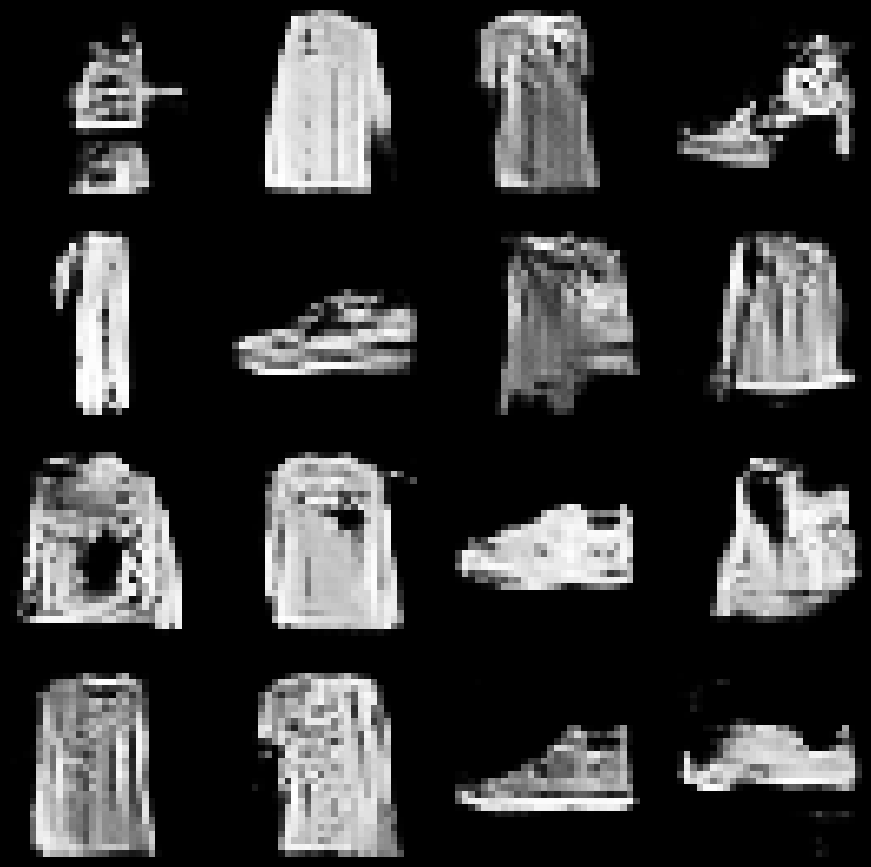

4/4 [==============================] - 0s 5ms/step
4400 [D loss: 0.221783, accuracy: 90.23%] [G loss: 2.711084]
1/1 [==============================] - 0s 18ms/step


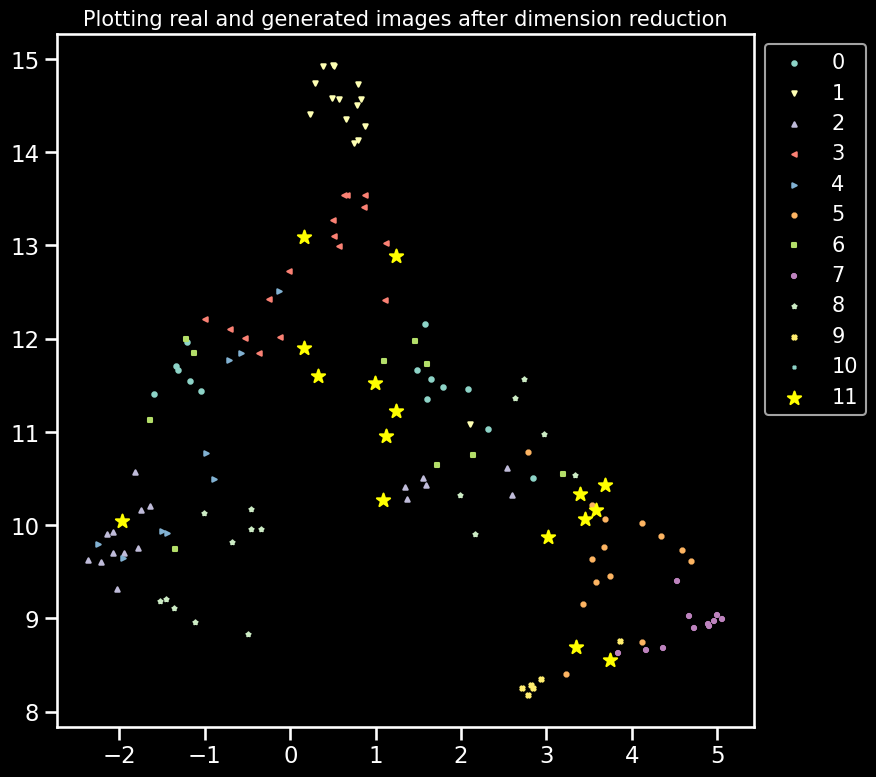

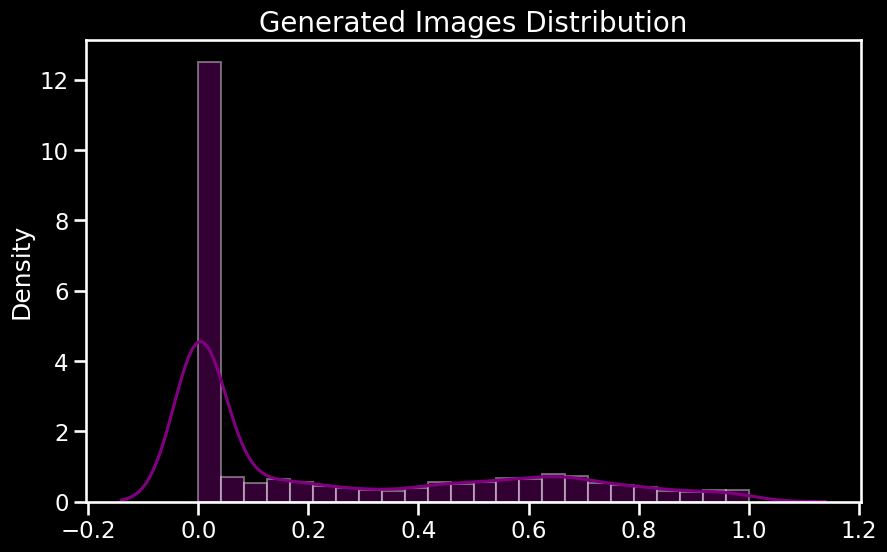

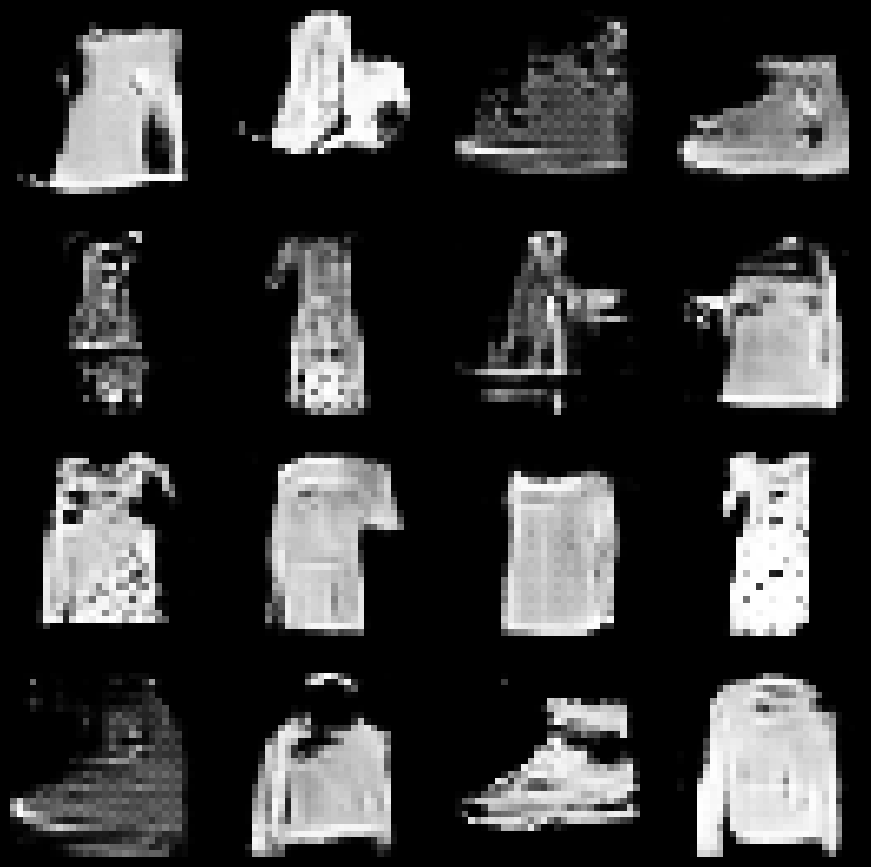

4/4 [==============================] - 0s 3ms/step
4800 [D loss: 0.237241, accuracy: 90.62%] [G loss: 2.304961]
1/1 [==============================] - 0s 19ms/step


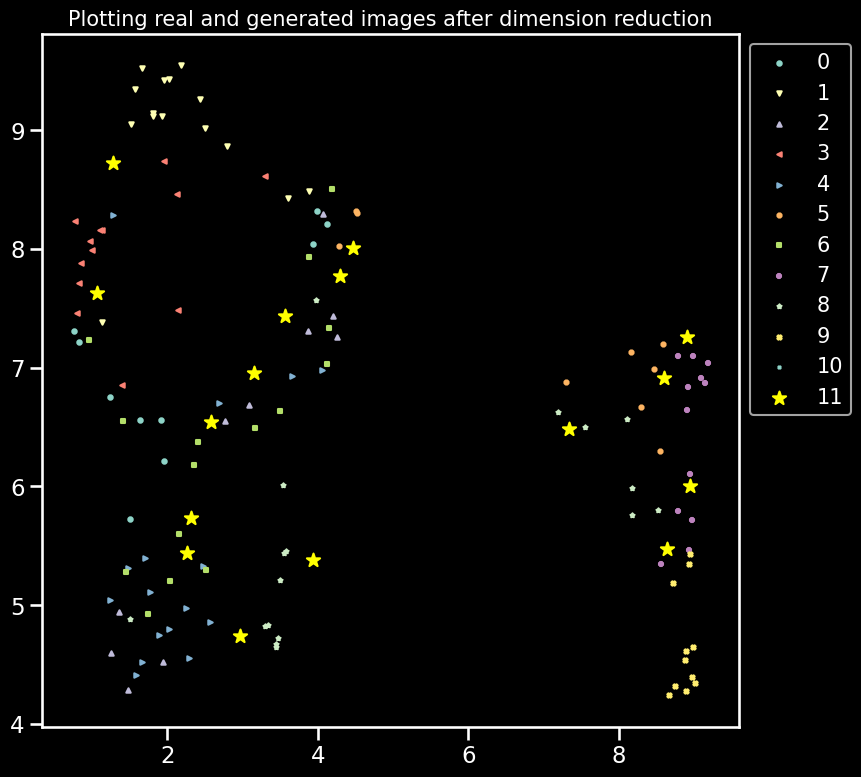

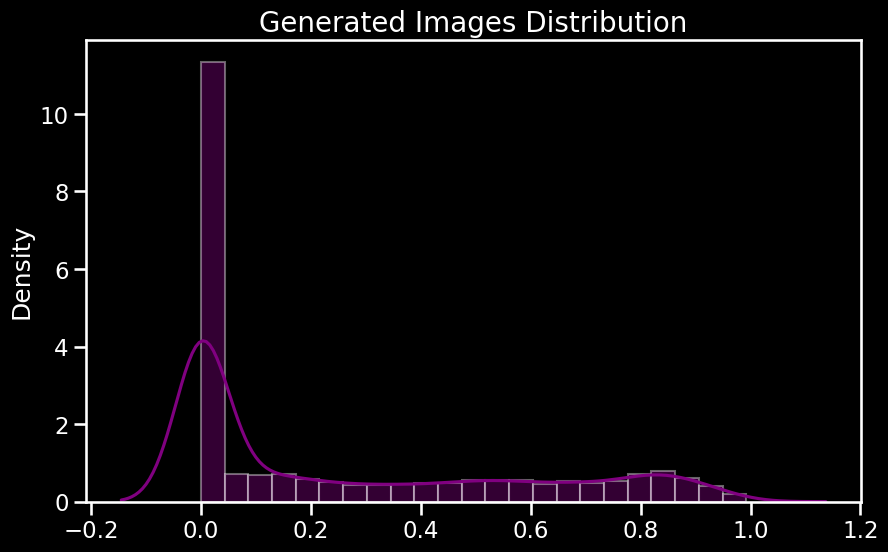

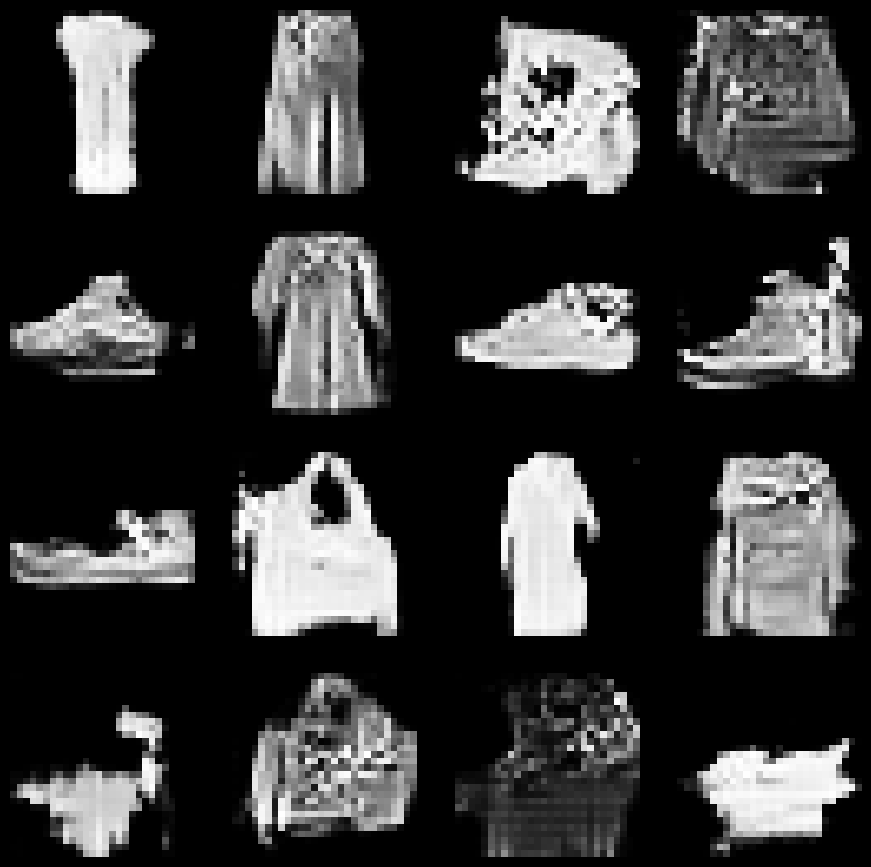

4/4 [==============================] - 0s 3ms/step
5200 [D loss: 0.262775, accuracy: 88.67%] [G loss: 2.131627]
1/1 [==============================] - 0s 26ms/step


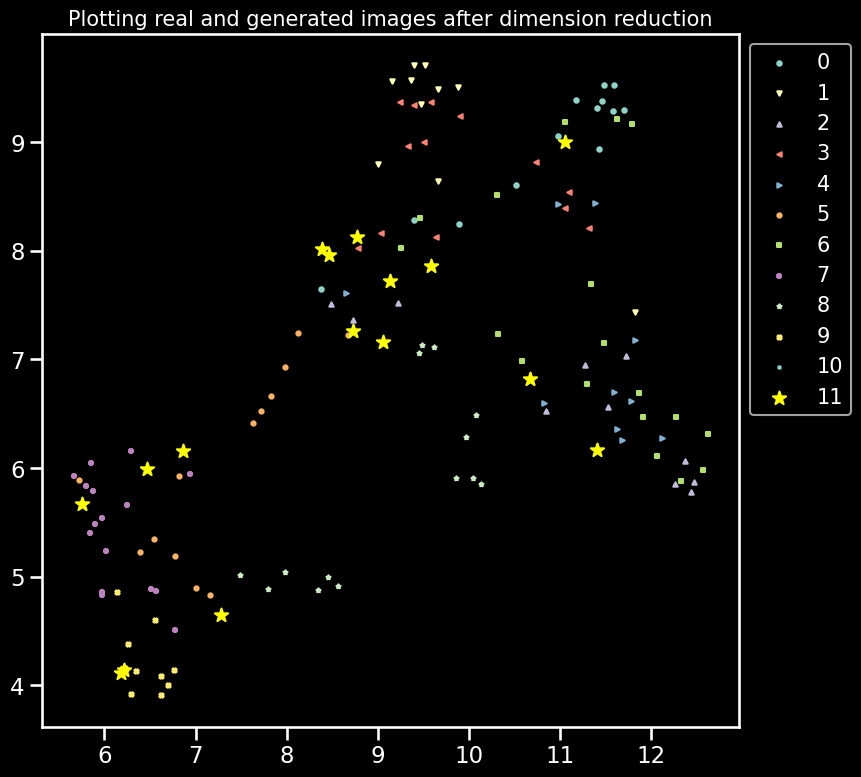

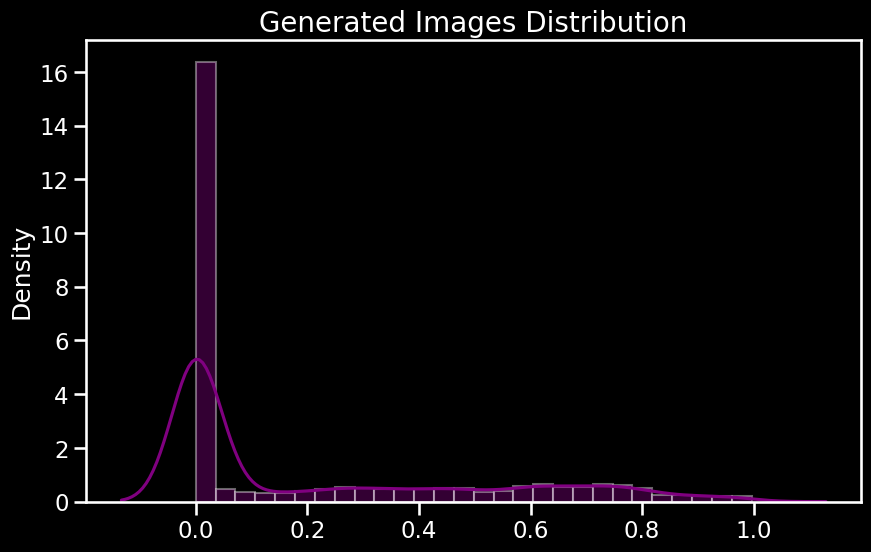

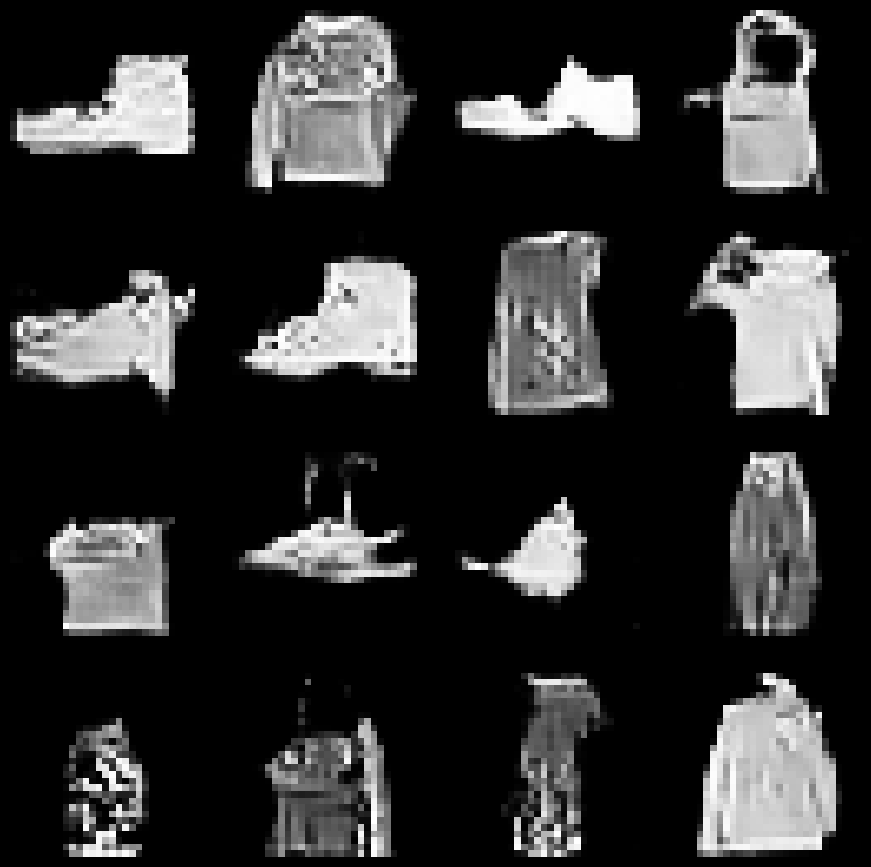

4/4 [==============================] - 0s 5ms/step
5600 [D loss: 0.327539, accuracy: 84.77%] [G loss: 1.774158]
1/1 [==============================] - 0s 17ms/step


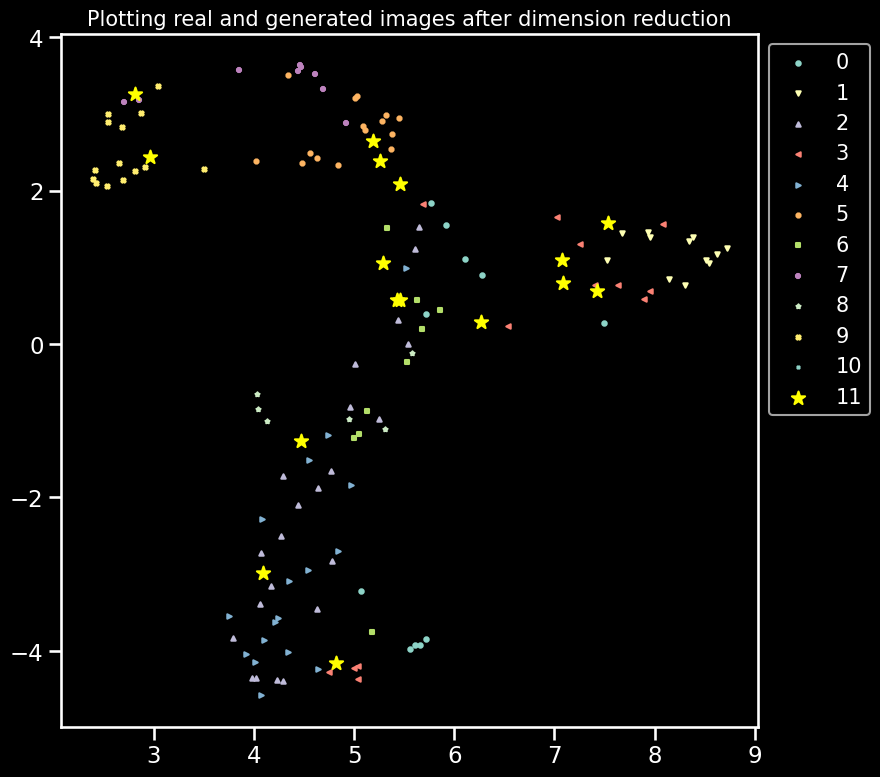

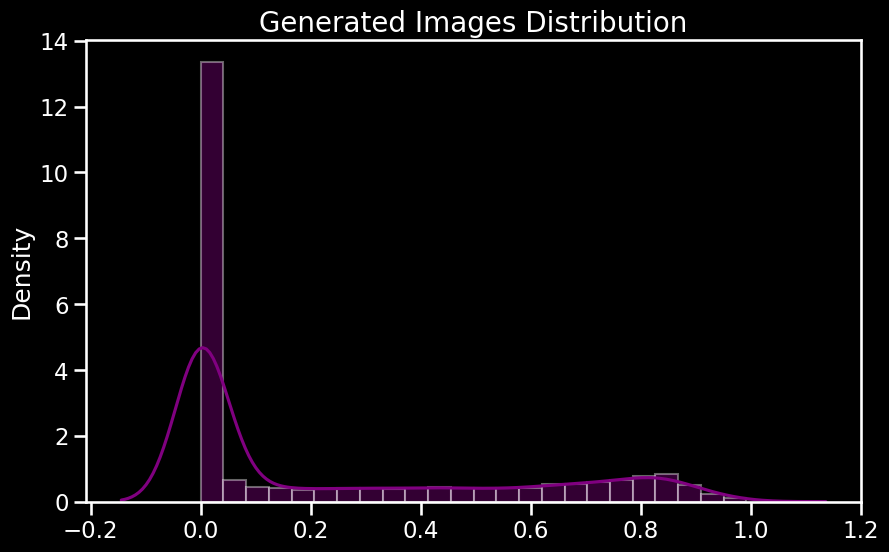

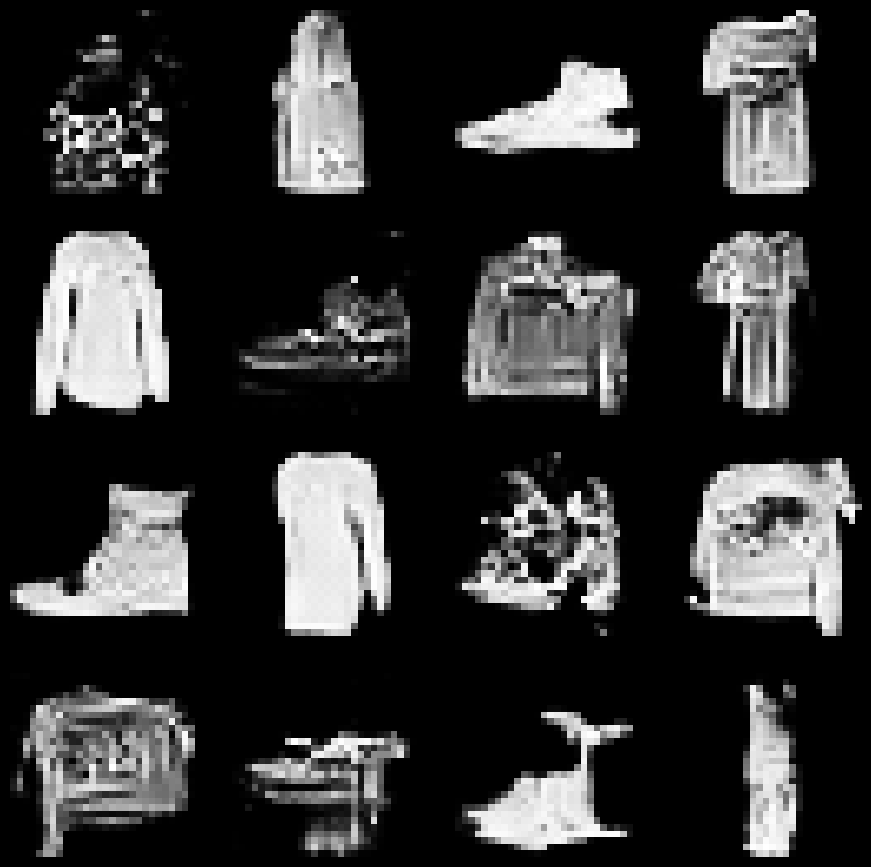

4/4 [==============================] - 0s 3ms/step
6000 [D loss: 0.257218, accuracy: 89.45%] [G loss: 2.952729]
1/1 [==============================] - 0s 16ms/step


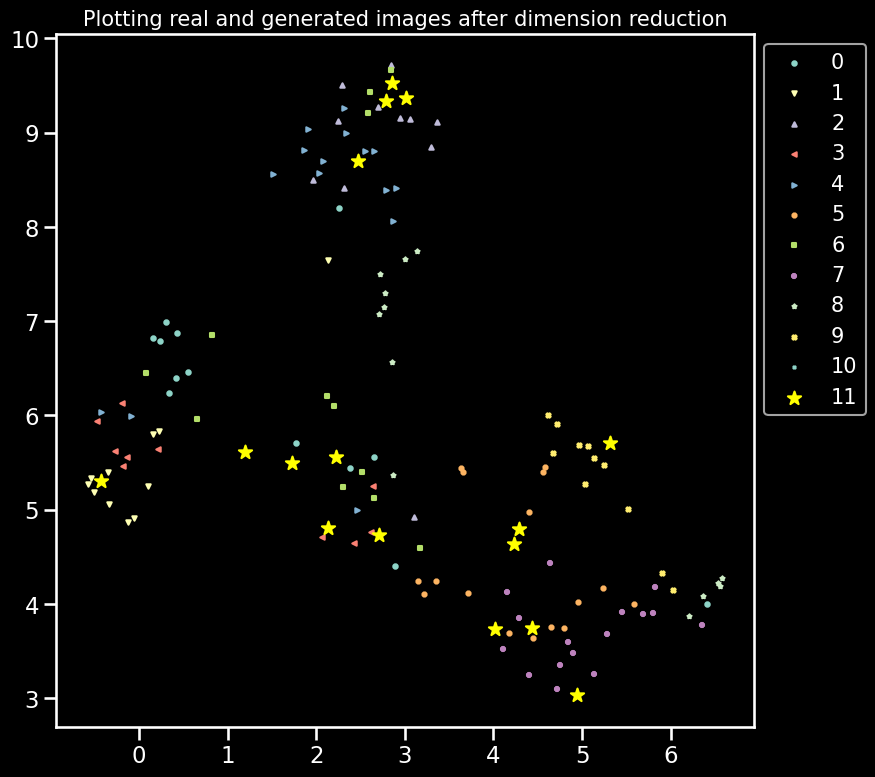

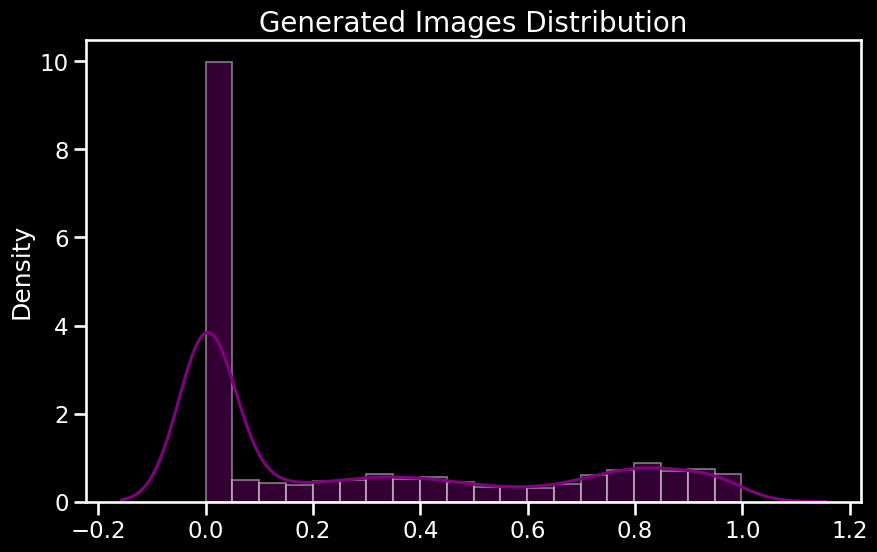

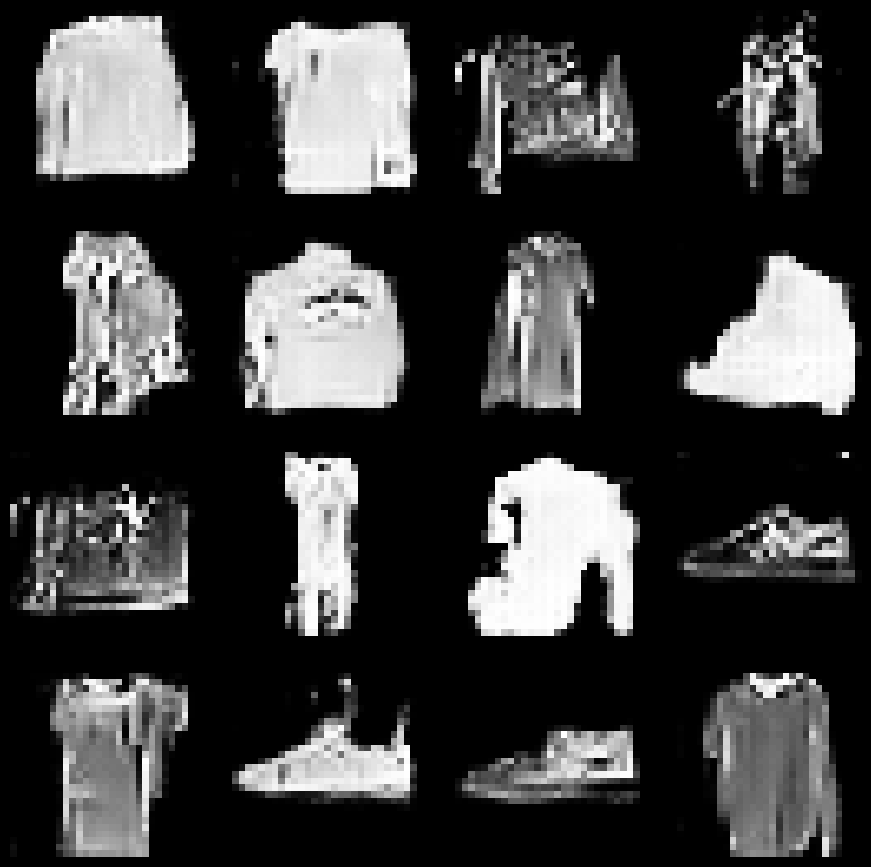

4/4 [==============================] - 0s 3ms/step
6400 [D loss: 0.437829, accuracy: 82.81%] [G loss: 1.912551]
1/1 [==============================] - 0s 25ms/step


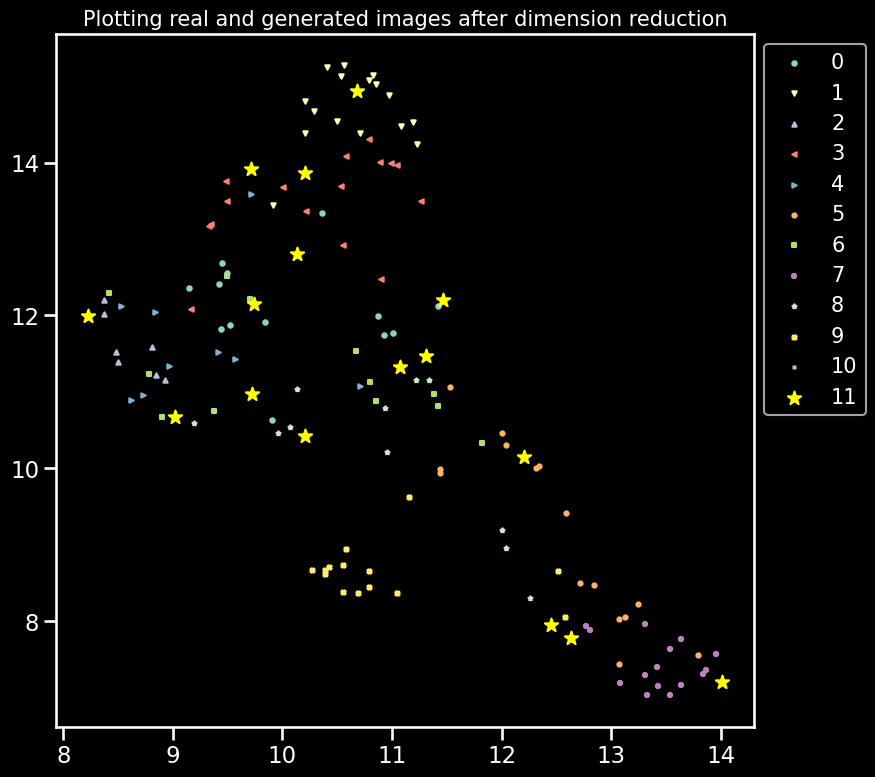

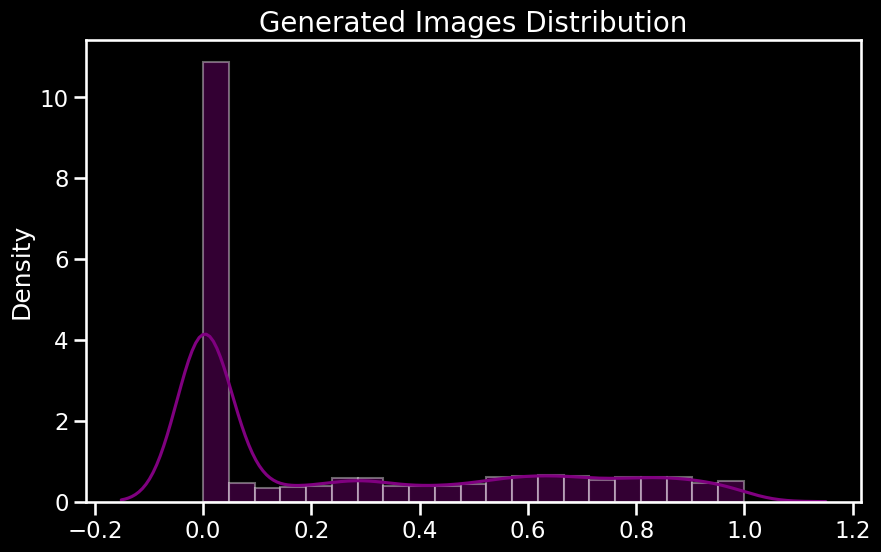

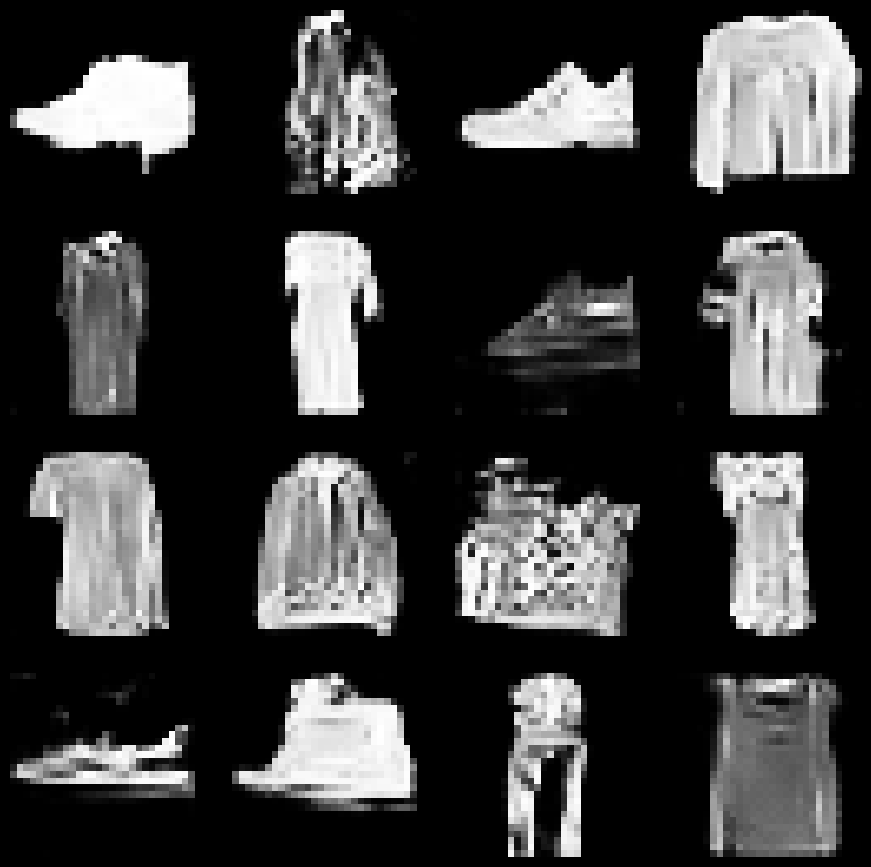

4/4 [==============================] - 0s 3ms/step
6800 [D loss: 0.289287, accuracy: 86.72%] [G loss: 2.429111]
1/1 [==============================] - 0s 17ms/step


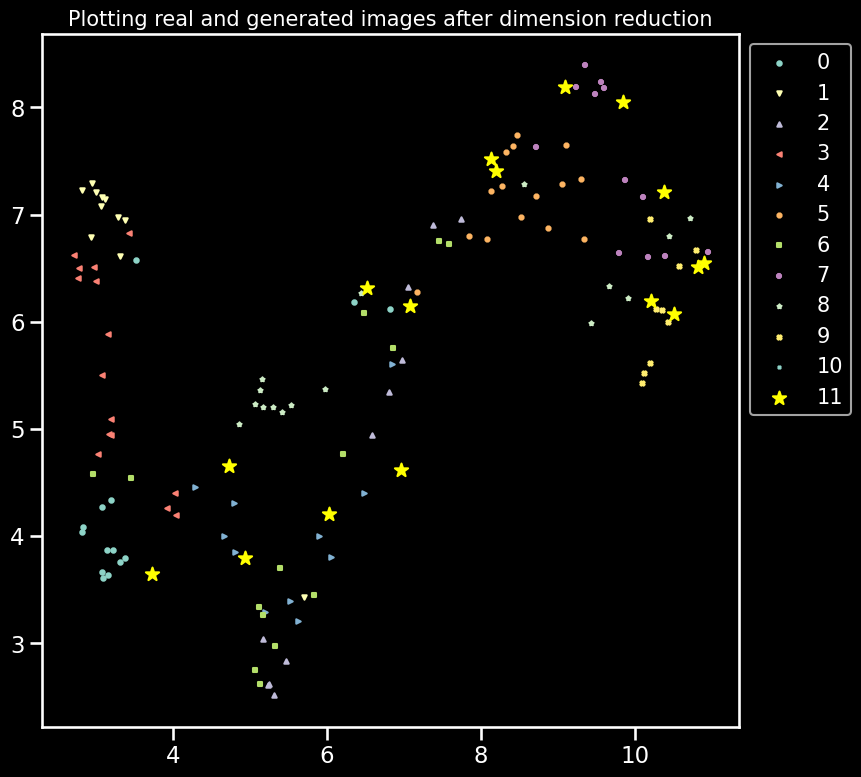

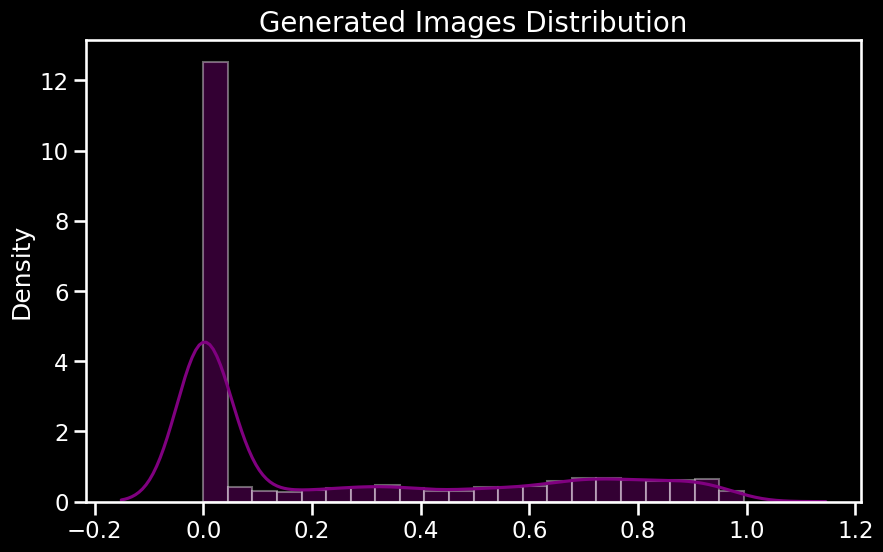

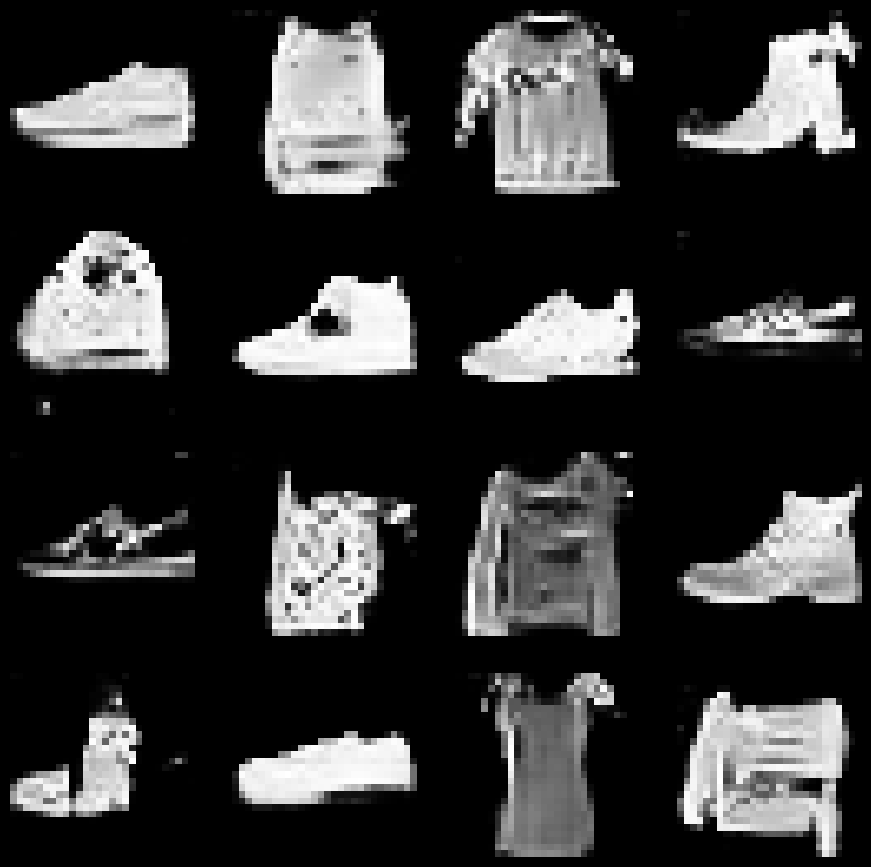

4/4 [==============================] - 0s 3ms/step
7200 [D loss: 0.347682, accuracy: 83.59%] [G loss: 1.918531]
1/1 [==============================] - 0s 32ms/step


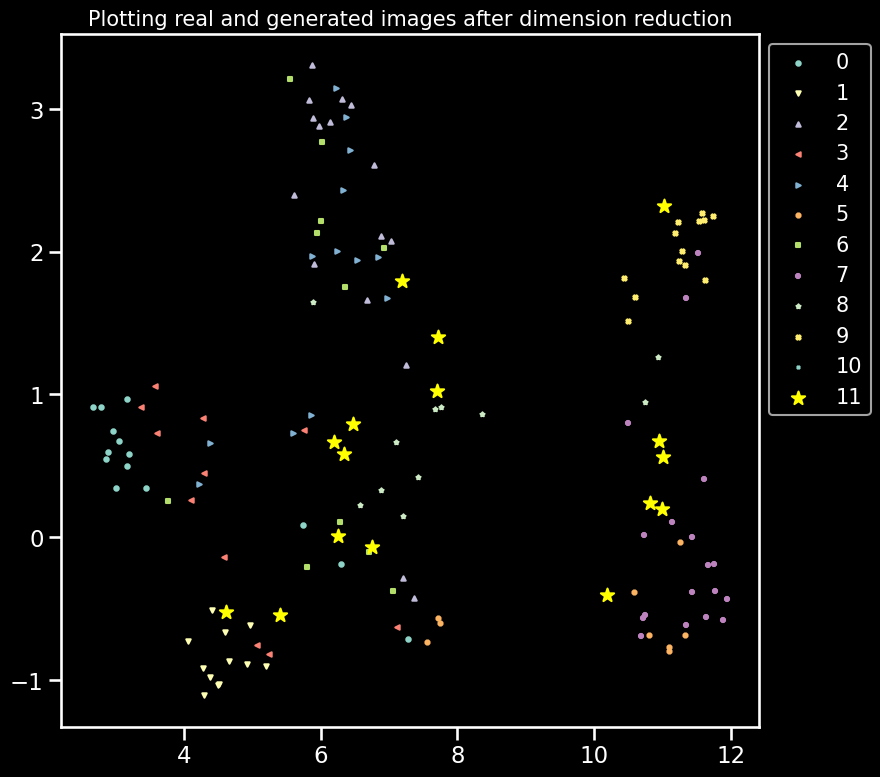

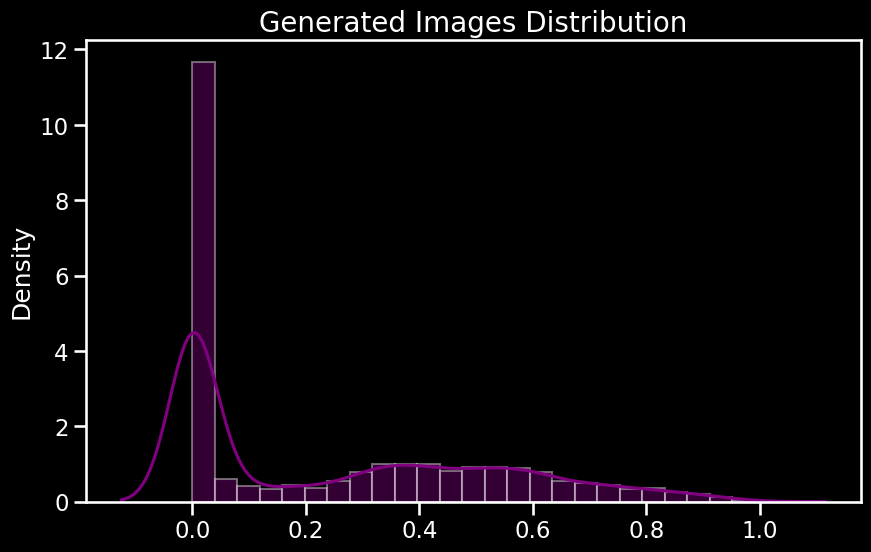

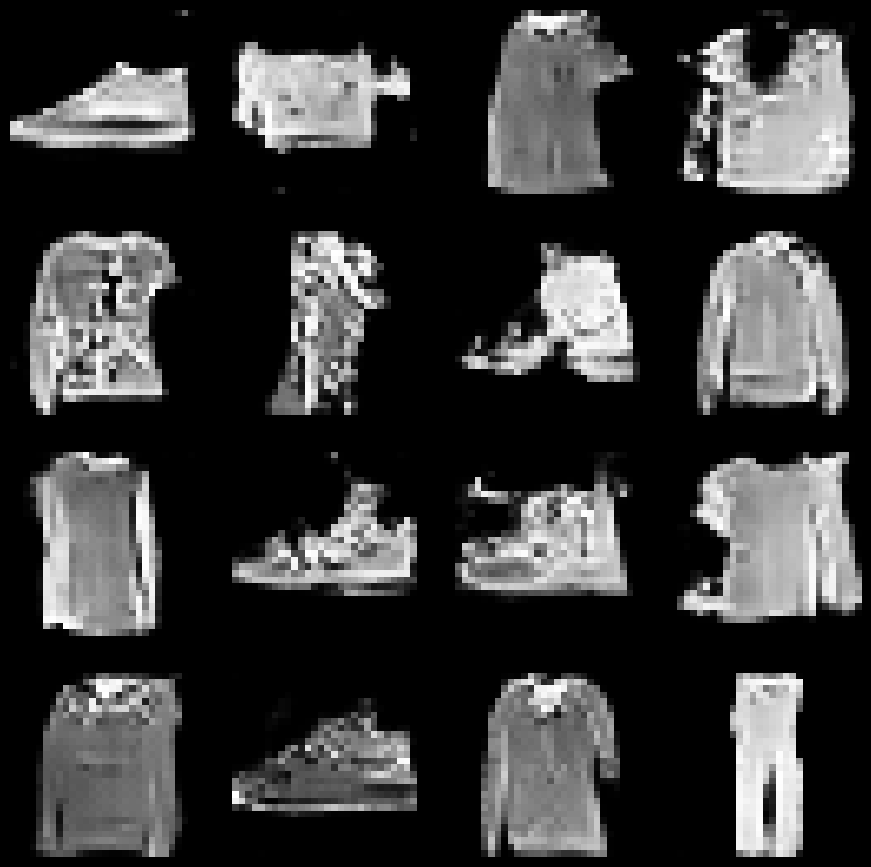

4/4 [==============================] - 0s 3ms/step
7600 [D loss: 0.284602, accuracy: 88.28%] [G loss: 1.747959]
1/1 [==============================] - 0s 27ms/step


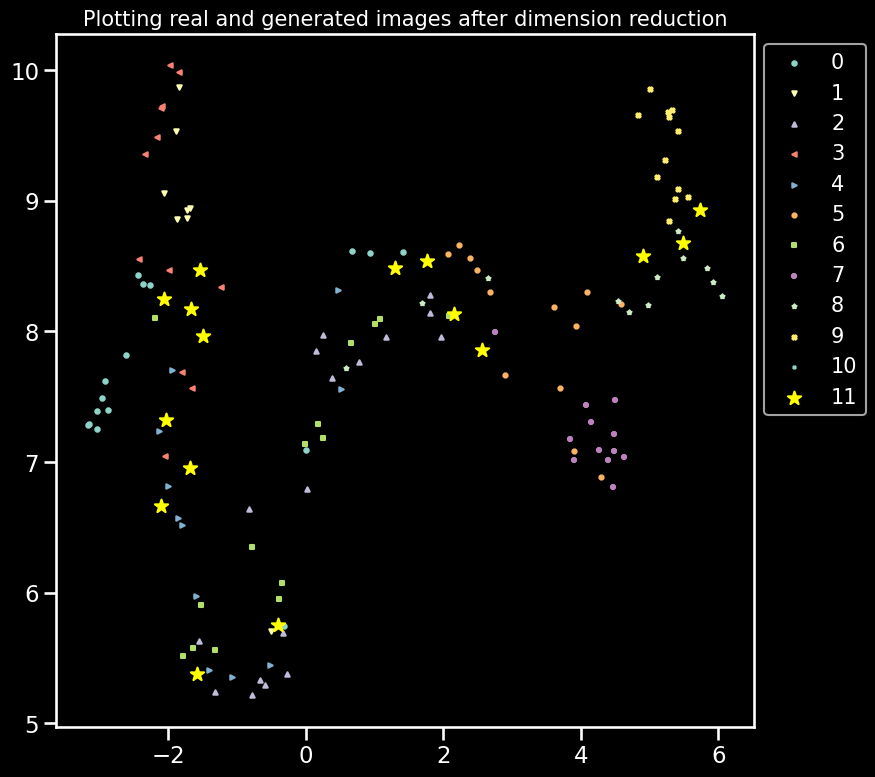

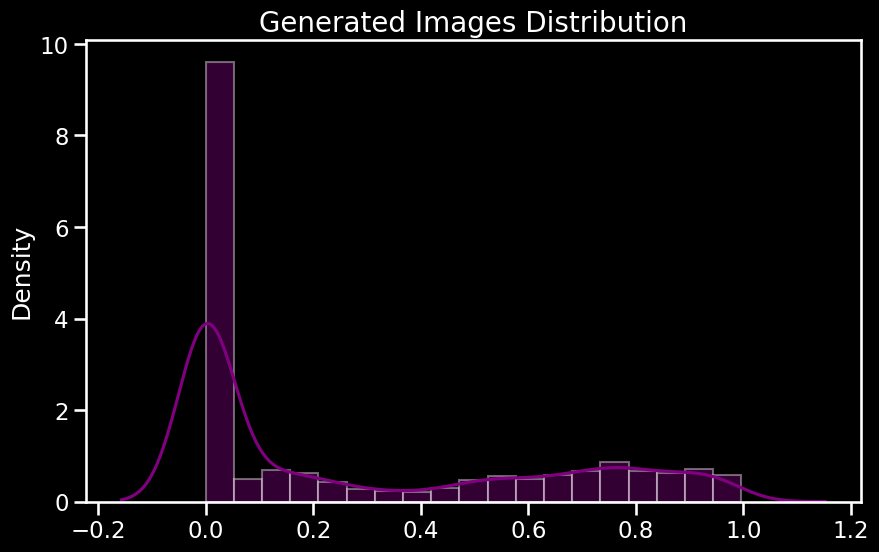

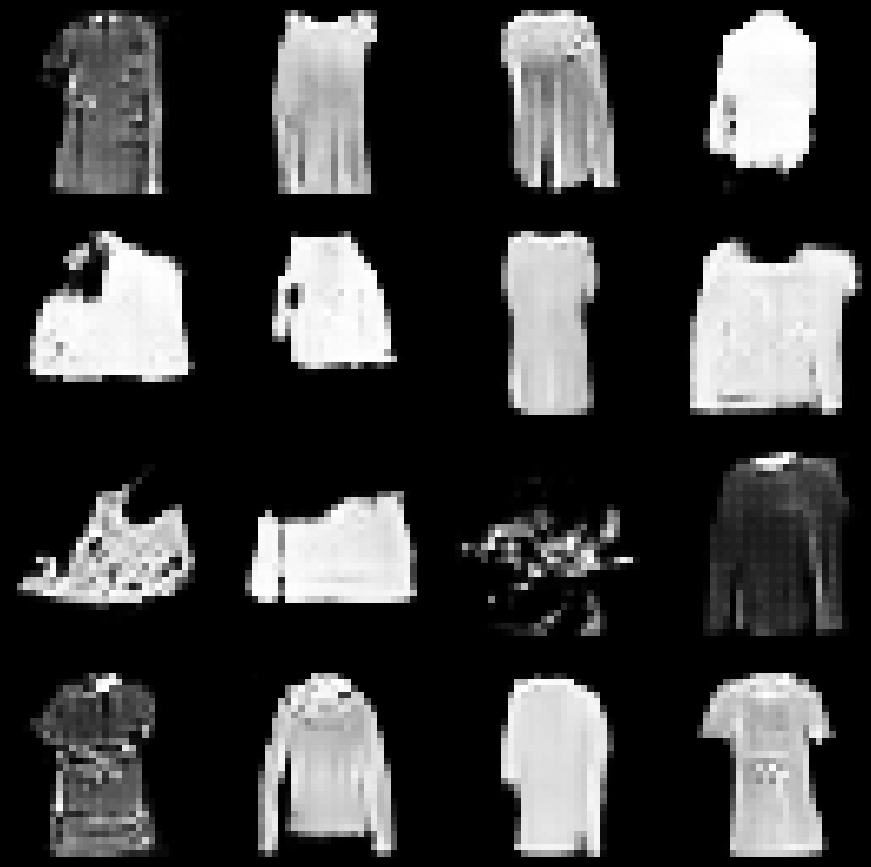

4/4 [==============================] - 0s 3ms/step
8000 [D loss: 0.319709, accuracy: 85.55%] [G loss: 2.179084]
1/1 [==============================] - 0s 26ms/step


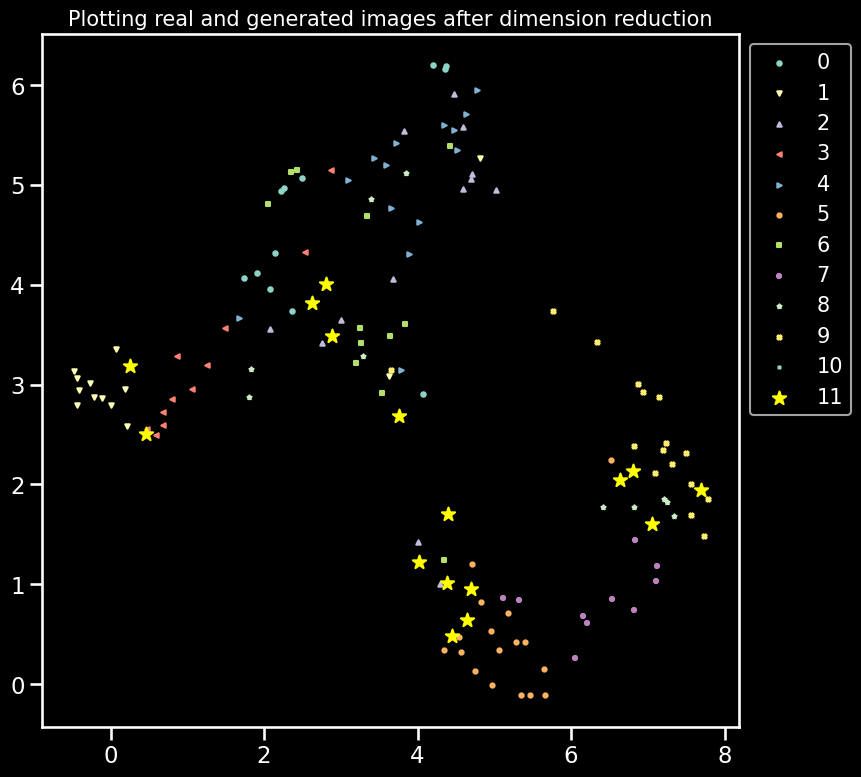

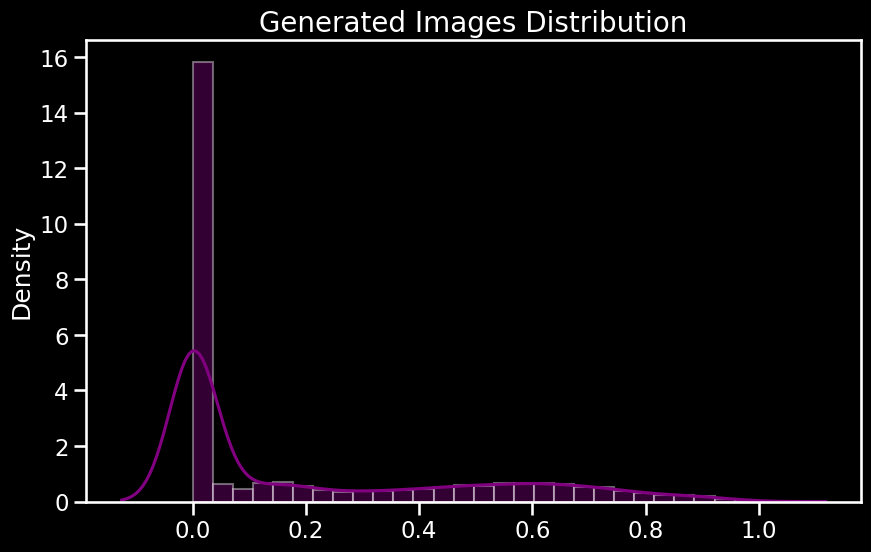

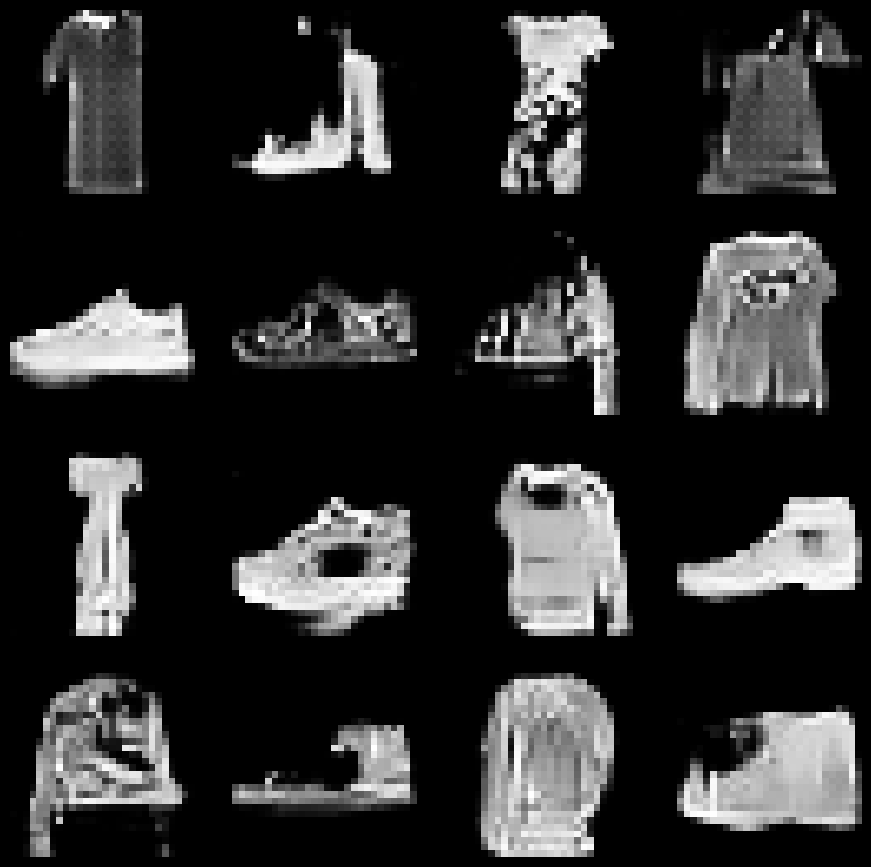

4/4 [==============================] - 0s 3ms/step
8400 [D loss: 0.353829, accuracy: 83.98%] [G loss: 1.895701]
1/1 [==============================] - 0s 18ms/step


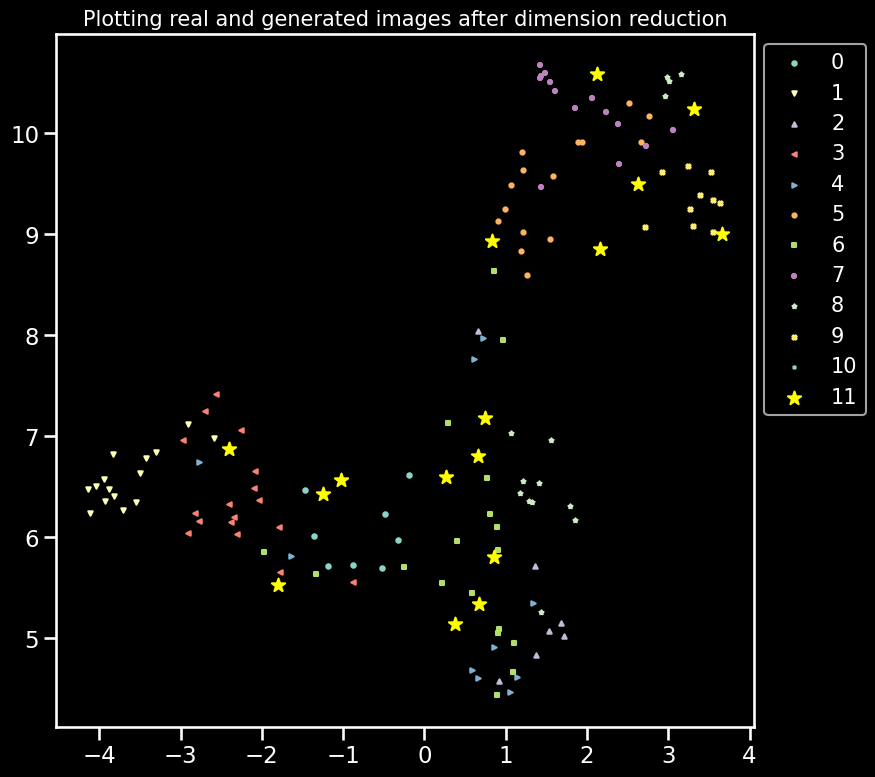

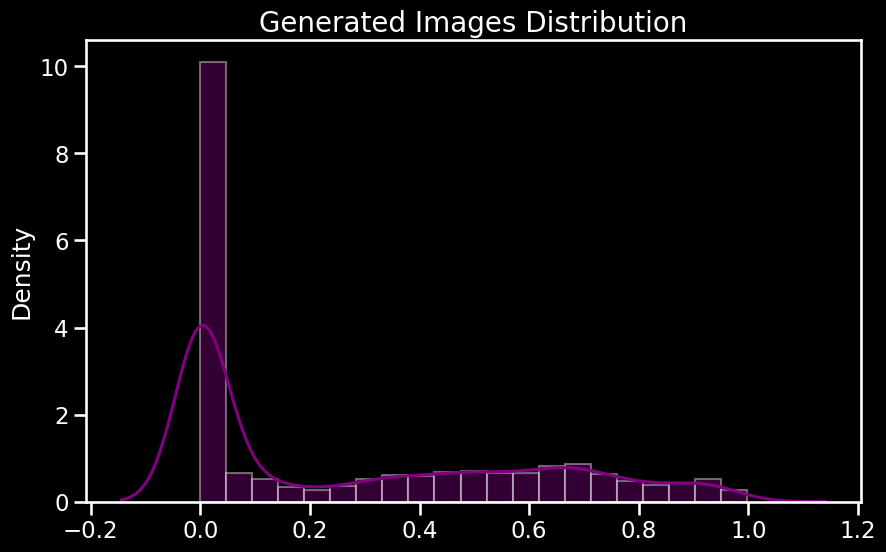

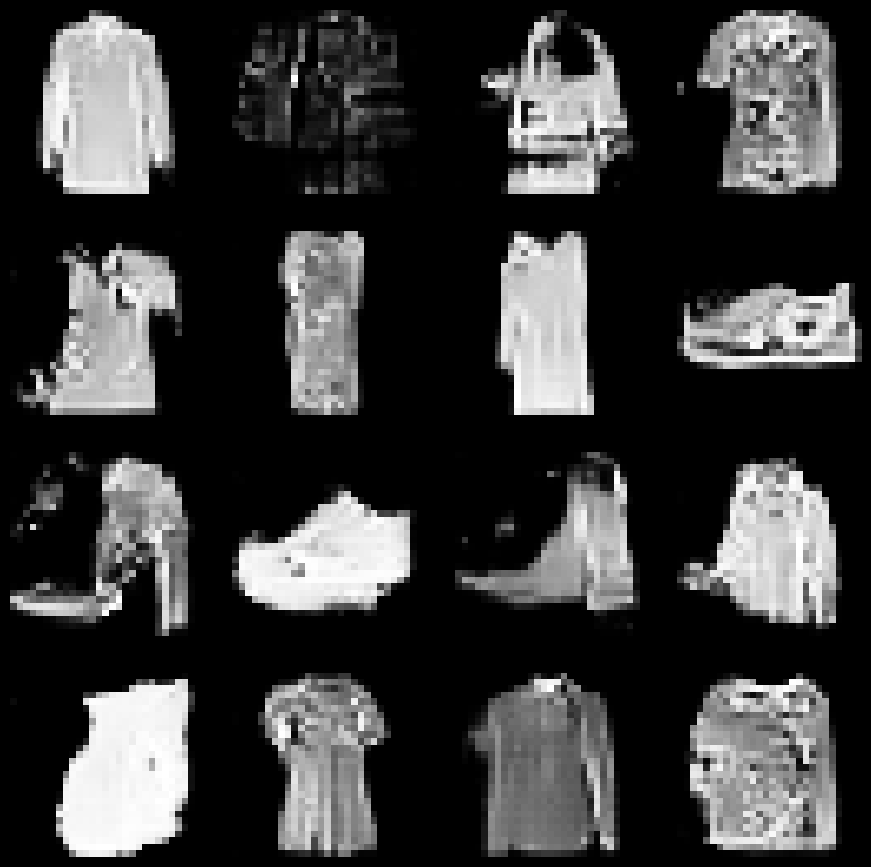

4/4 [==============================] - 0s 3ms/step
8800 [D loss: 0.261002, accuracy: 90.62%] [G loss: 2.244303]
1/1 [==============================] - 0s 18ms/step


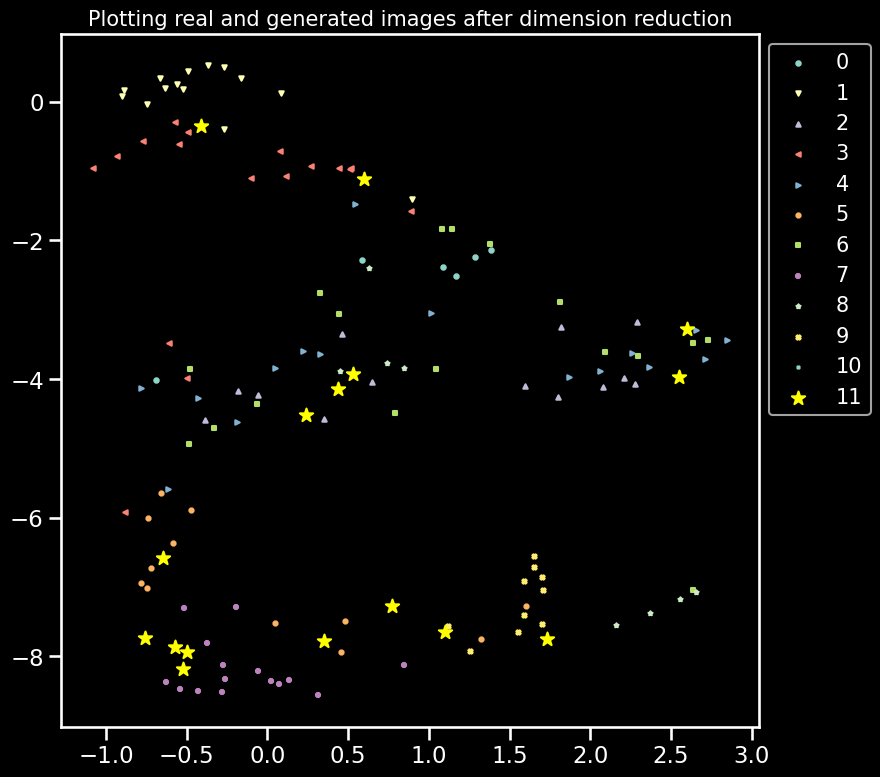

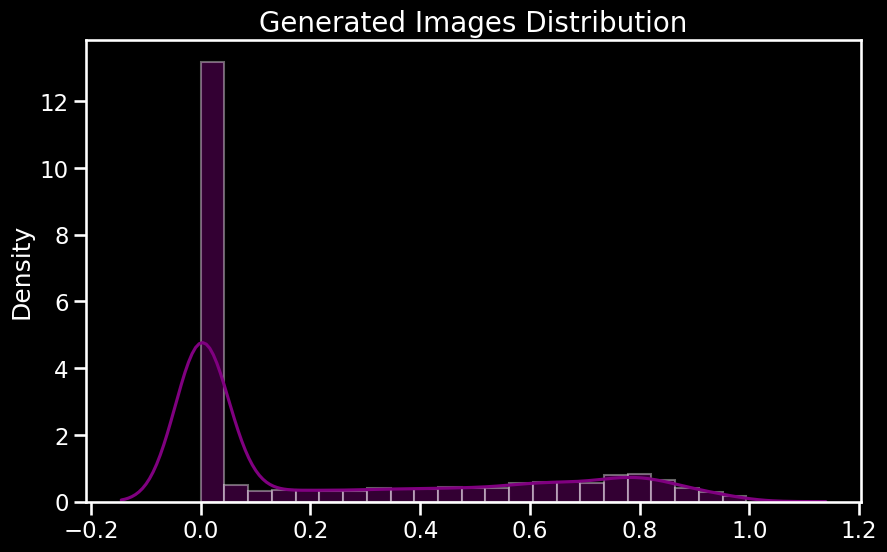

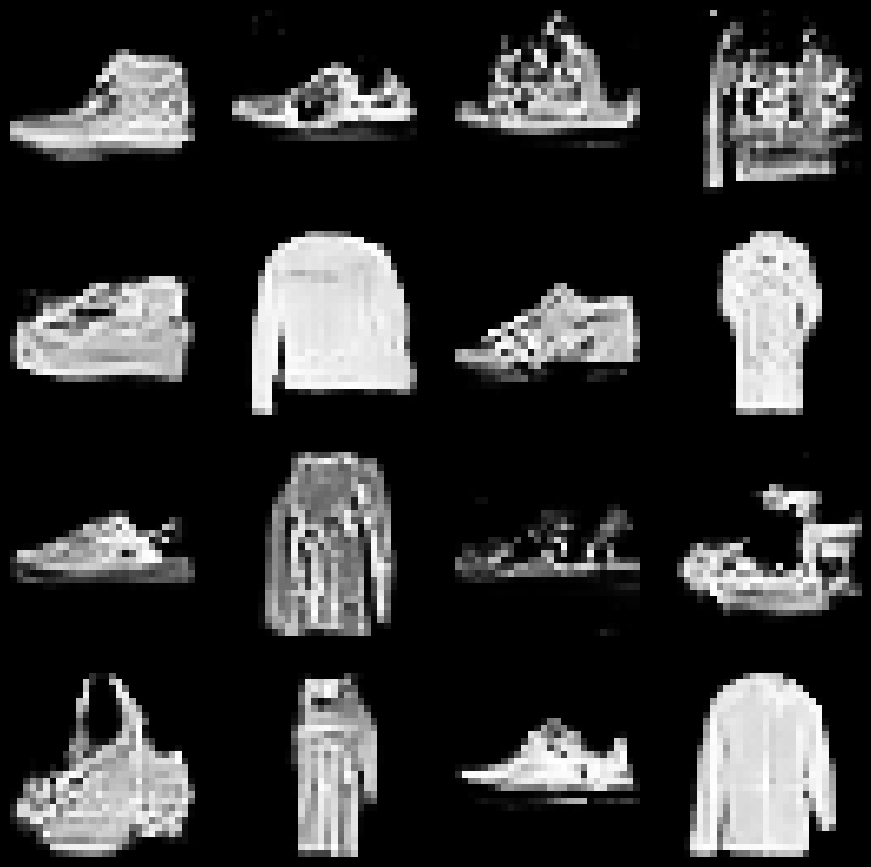

4/4 [==============================] - 0s 3ms/step
9200 [D loss: 0.323744, accuracy: 89.84%] [G loss: 2.384914]
1/1 [==============================] - 0s 17ms/step


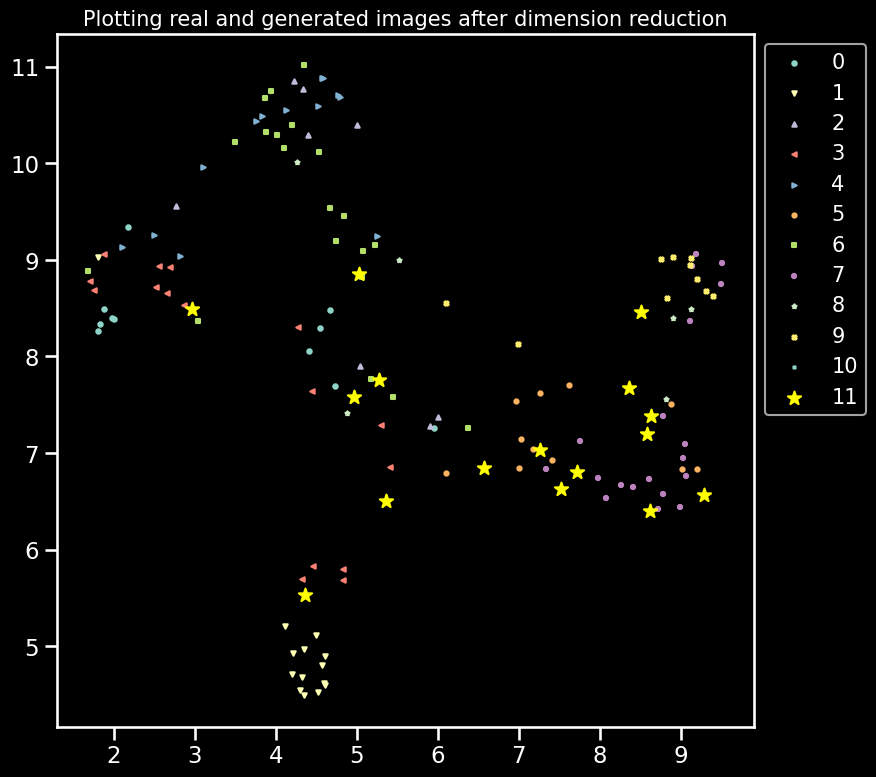

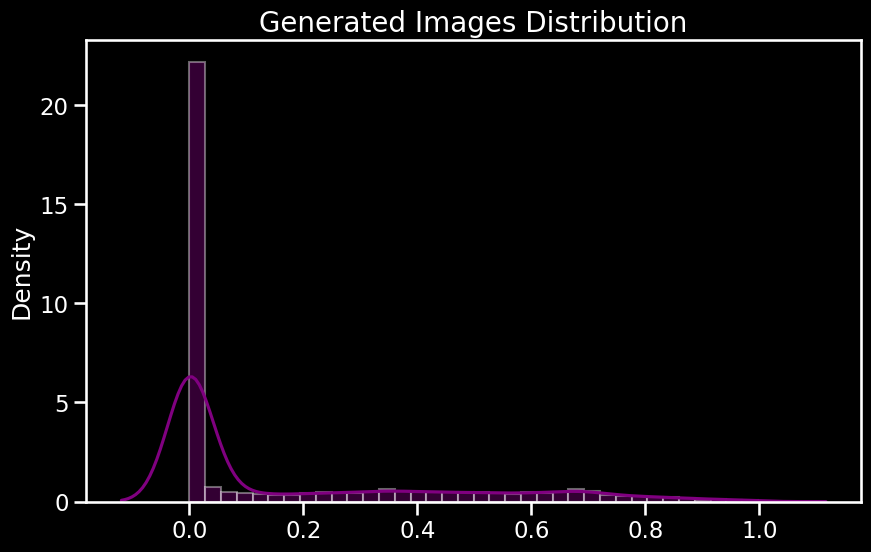

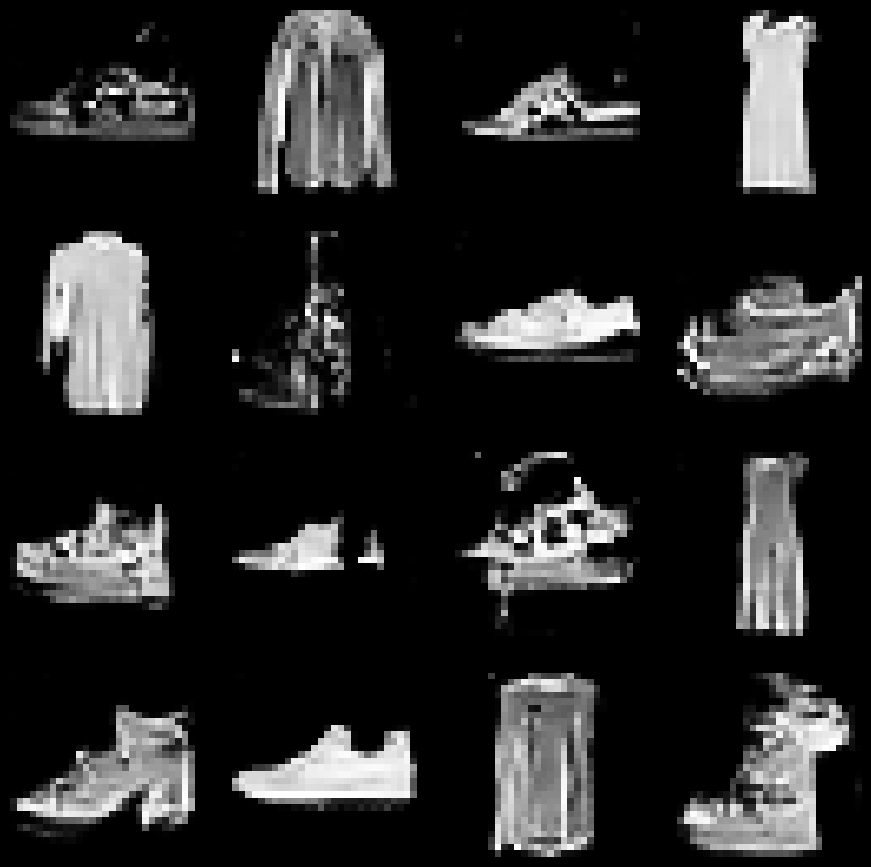

4/4 [==============================] - 0s 4ms/step
9600 [D loss: 0.299613, accuracy: 87.11%] [G loss: 2.022672]
1/1 [==============================] - 0s 17ms/step


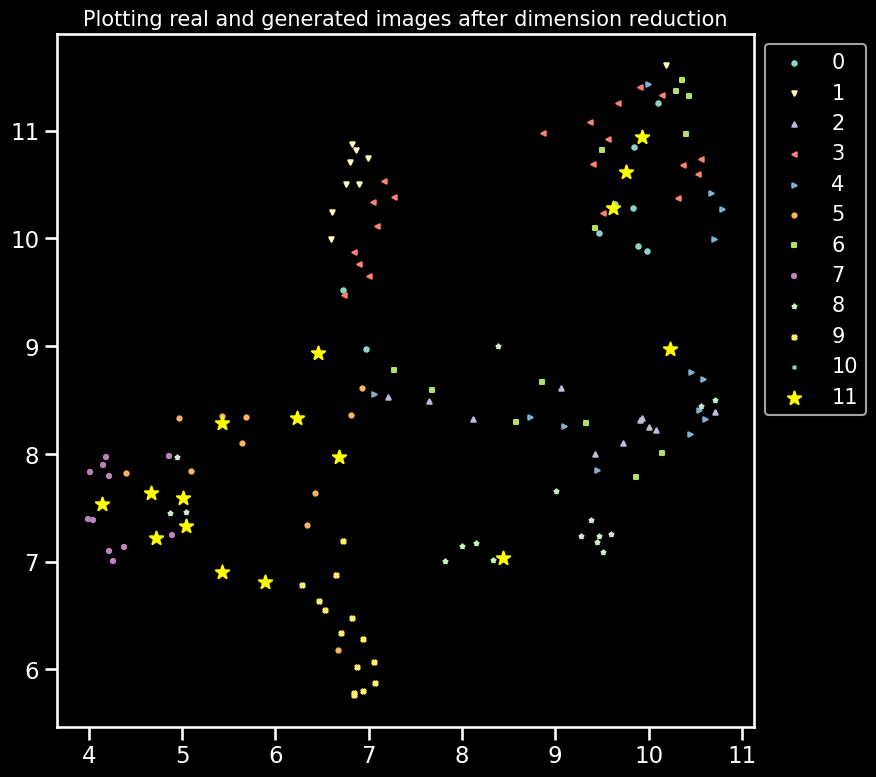

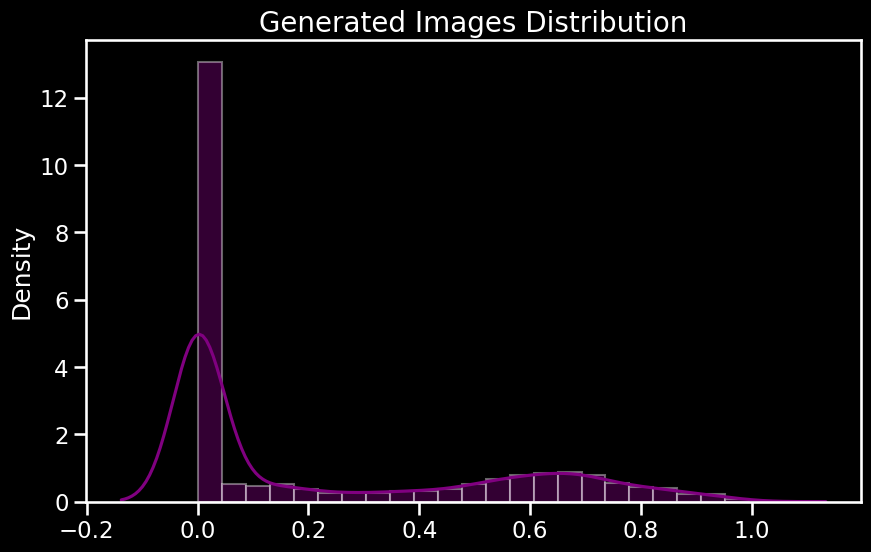

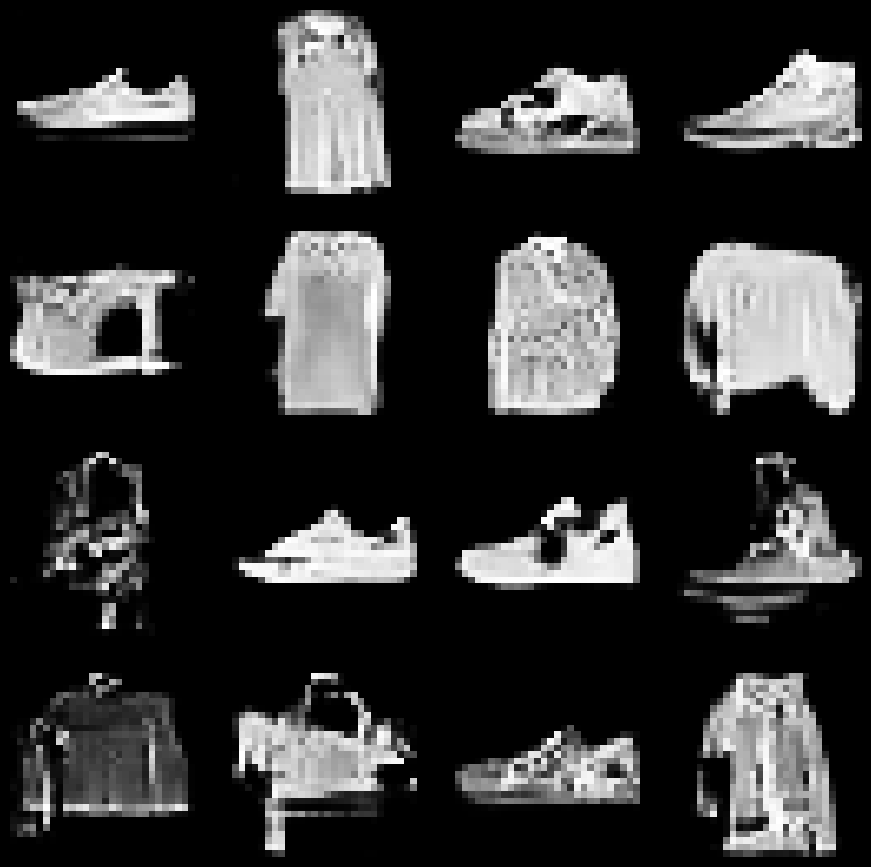

4/4 [==============================] - 0s 4ms/step
10000 [D loss: 0.372164, accuracy: 84.38%] [G loss: 2.197602]
1/1 [==============================] - 0s 31ms/step


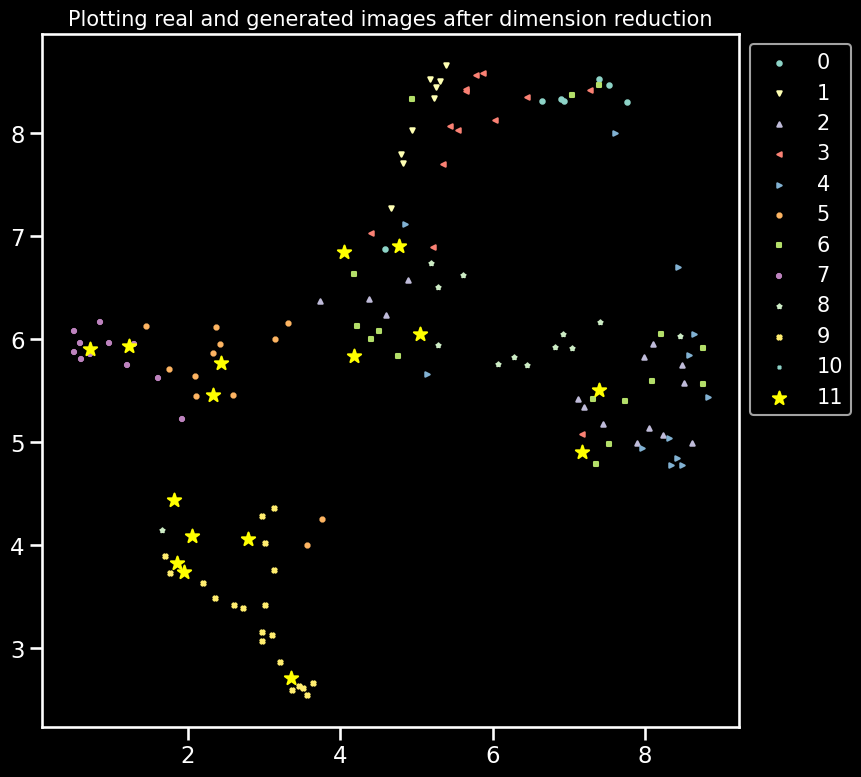

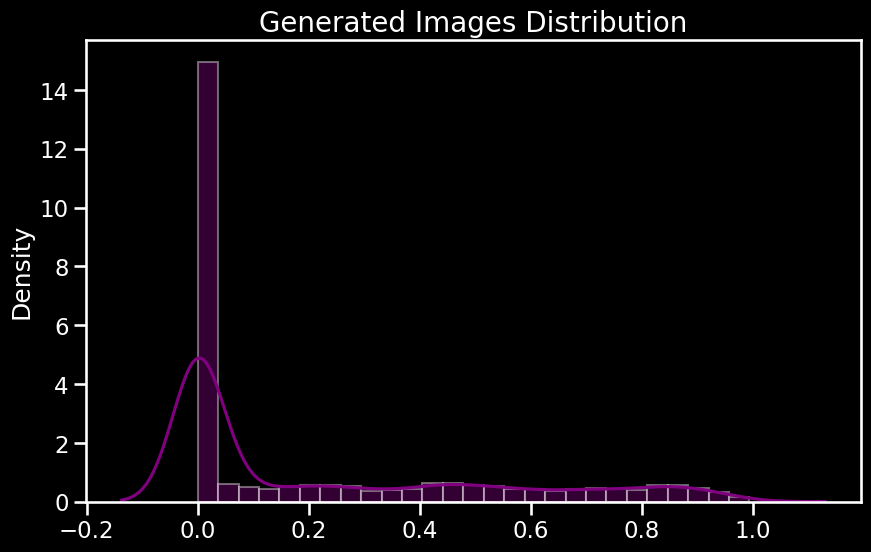

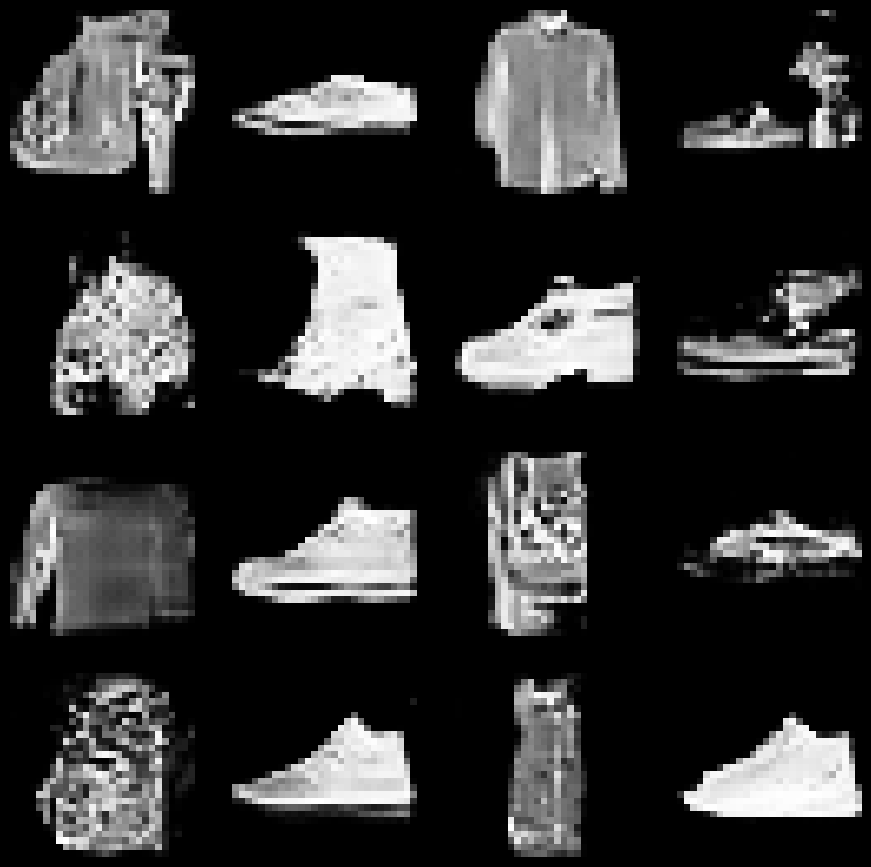

In [ ]:
# DCGAN training for a specified number of iterations
train(iterations, batch_size, sample_interval)

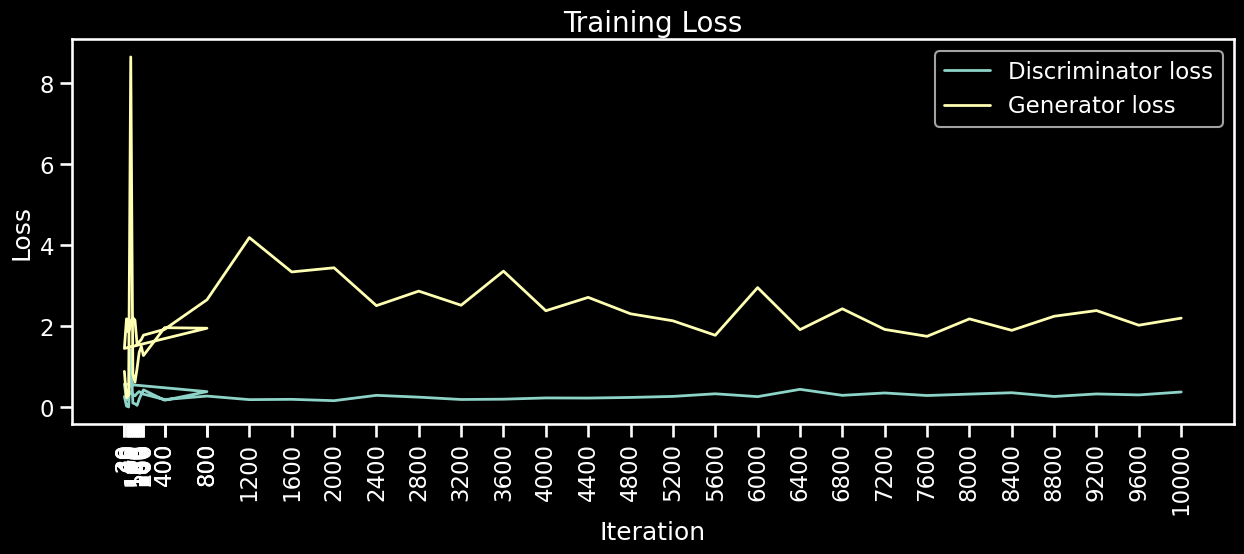

In [ ]:
losses = np.array(losses)

# Training loss graph of discriminant and generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss",linewidth=2)
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

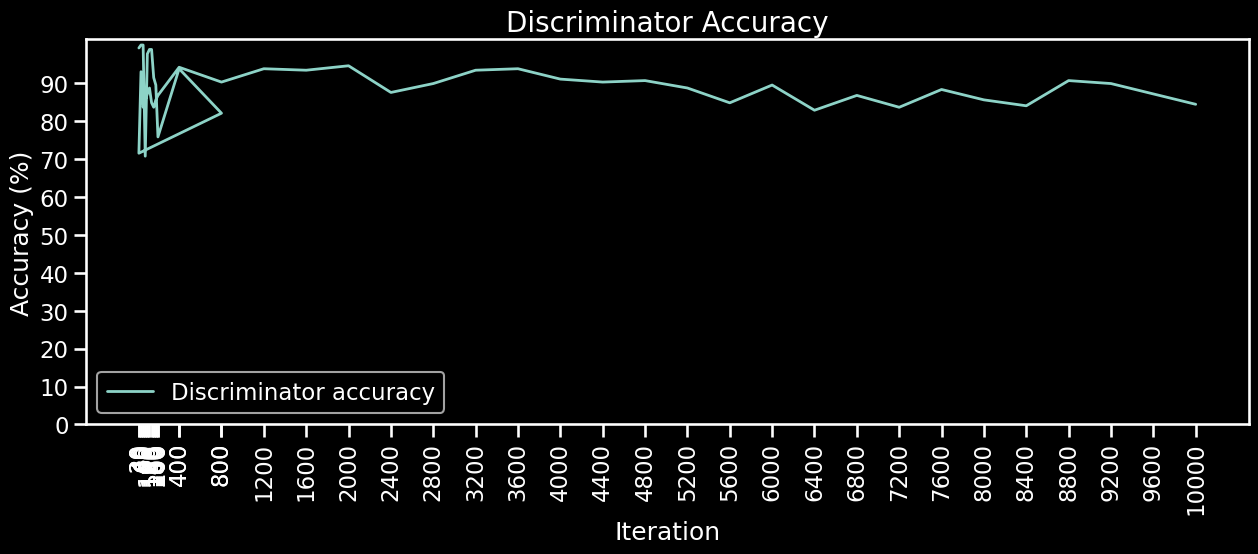

In [ ]:
accuracies = np.array(accuracies)

# Discriminator Accuracy Graph
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 10))

plt.title("Discriminator Accuracy",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()